In [69]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import pickle
import itertools
# from neural_network_classes import Net3

In [33]:
from Net3 import Net3
from Net5 import Net5
from helper_functions import train_test_loaders

In [34]:
skip_training = False
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device {device} device")

using device mps device


In [63]:
data_folder = '../../Data/Training/wavelet_pickle_data'
results_folder = '../../Results/'
sensor_specific_folder = "sensor_specific/"

In [36]:
exclude_features = ['TIMESTAMP', 'pit_number', 'Redox_error_flag']

### Main parameters

In [38]:
epochs = 20
batch_size_train = 1000

In [39]:
def comparison_plot(Ms, train_error_1, test_error_1, train_error_2, test_error_2, error_1_name, error_2_name):
    
    fig = plt.figure()

    ax1 = plt.gca()
    

    ax1.plot(Ms, train_error_1, c = "blue", label = "train_" + error_1_name)
    ax1.plot(Ms, test_error_1, c = "red", label = "test_" + error_1_name)
    ax1.legend(loc = 0)

    ax1.set_xlabel("# of neurons in a hidden layer")
    ax1.set_ylabel("error") 

    ax2 = ax1.twinx() 

    ax2.plot(Ms, train_error_2, c = "cyan", label = "train_" + error_2_name)
    ax2.plot(Ms, test_error_2, c = "orange", label = "test_" + error_2_name)
    ax2.legend(loc = 0)

    ax1.set_xlabel("# of neurons in a hidden layer")
    ax1.set_ylabel("error") 

    
    ax2.legend(loc = 1)    

    fig.tight_layout()
    plt.legend()
    plt.show(block = False)

    return None

In [40]:
def plot_predicted_2023(predicted, test_X_2023, sensor = None):

    if sensor == None: 
        for i in np.arange(1,6):
            fig = plt.figure(figsize = (40,15))
            ax = plt.gca()
            for j in np.arange(1,5):
                ax.scatter(test_X_2023.loc[test_X_2023["pit_number"] == j, "TIMESTAMP"], test_X_2023.loc[test_X_2023["pit_number"] == j, ["Redox_Avg("+ str(i)+ ")"]], color = "green", alpha = 0.05, s = 1)
                ax.scatter(test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["TIMESTAMP"]], test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["Redox_Avg("+ str(i)+ ")"]], color = "red", alpha = 1, s = 1)
            plt.show(block = False)
  
    if sensor != None: 
        
        for j in np.arange(1,5):
            fig, ax = plt.subplots(figsize = (40,15))
            ax.set_title(f"2023 data with the errors predicted by the neural network model")    
            ax.scatter(test_X_2023.loc[test_X_2023["pit_number"] == j, "TIMESTAMP"], test_X_2023.loc[test_X_2023["pit_number"] == j, ["Redox_Avg("+ str(sensor)+ ")"]], color = "green", alpha = 0.5, s = 1)
            x = test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["TIMESTAMP"]]
            y = test_X_2023.loc[predicted & (test_X_2023["pit_number"] == j), ["Redox_Avg("+ str(sensor)+ ")"]]
            ax.scatter(x = x, y = y, color = "red", s = 1)
            plt.show(block = False)

In [41]:
def df_storing(df, sensor, results_folder = results_folder, sensor_specific_folder = sensor_specific_folder, architecture = Net3, optimizer = "Adam", lr = 0.01, weight = [2, 7]):
    
    if architecture == Net3: 
        arch = 3
    else: arch = 5

    filename = f"df_sensor_{sensor}_" + str(arch) + "_layers_" + optimizer + "_" + str(lr) + "_weights_" + str(weight[0]) + "_" + str(weight[1])
    pickle.dump(df, open(results_folder + sensor_specific_folder + filename, 'wb'))

    return None

## Get the data 

### 2022 ALL SENSORS

In [139]:
# Get train and test data for 2022

# Main folders

folder_2022 = f'{data_folder}/2022'
scaled_2022 = f'{folder_2022}/Scaled'

# 2022 Folder
X_train_scaled_2022_folder = f'{scaled_2022}/X_train_scaled.pkl'
X_test_scaled_2022_folder = f'{scaled_2022}/X_test_scaled.pkl'
X_test_2022_folder = f'{folder_2022}/X_test.pkl'
y_train_2022_folder = f'{folder_2022}/y_train.pkl'
y_test_2022_folder = f'{folder_2022}/y_test.pkl'

# 2022 data
X_train_scaled_2022 = pd.read_pickle(open(X_train_scaled_2022_folder, 'rb'))
X_test_scaled_2022 = pd.read_pickle(open(X_test_scaled_2022_folder, 'rb'))
X_test_2022 = pd.read_pickle(open(X_test_2022_folder, 'rb'))
y_train_2022 = pd.read_pickle(open(y_train_2022_folder, 'rb'))
y_test_2022 = pd.read_pickle(open(y_test_2022_folder, 'rb'))

# 2023 folders
test_scaled_2023_folder = f'{data_folder}/2023/Scaled/test_scaled.pkl'
test_2023_folder = f'{data_folder}/2023/test.pkl'

# 2023 data
test_scaled_2023 = pd.read_pickle(open(test_scaled_2023_folder, 'rb'))
test_2023 = pd.read_pickle(open(test_2023_folder, 'rb'))

# Train X
train_X = X_train_scaled_2022.loc[:,~X_train_scaled_2022.columns.isin(exclude_features)]
train_X = torch.Tensor(train_X.to_numpy().astype("float32"))
# print(train_X.shape)

# Test X
test_X = X_test_scaled_2022.loc[:,~X_test_scaled_2022.columns.isin(exclude_features)]
test_X = torch.Tensor(test_X.to_numpy().astype("float32"))

# Train y
train_y = torch.Tensor(y_train_2022.to_numpy().ravel())
train_y = train_y.to(dtype=torch.int32)

# Test y
test_y = torch.Tensor(y_test_2022.to_numpy().ravel())
test_y = test_y.to(dtype=torch.int32)

# Test_2023

test_X_scaled_2023 = test_scaled_2023.loc[:,~test_scaled_2023.columns.isin(exclude_features)]
test_X_scaled_2023 = torch.Tensor(test_X_scaled_2023.to_numpy().astype("float32")).to(device)


In [65]:
sensor_data = dict()

# Main folders
folder_2022_sensors = f'{data_folder}/2022_sensors'
scaled_2022_sensors = f'{folder_2022_sensors}/Scaled'

sensors = np.arange(1,6)

for sensor in sensors:
    # 2022 sensors folder
    X_train_scaled_2022_sensor_folder = f'{scaled_2022_sensors}/X_train_scaled_sensor_{sensor}.pkl'
    X_test_scaled_2022_sensor_folder = f'{scaled_2022_sensors}/X_test_scaled_sensor_{sensor}.pkl'
    X_test_2022_sensor_folder = f'{folder_2022_sensors}/X_test_sensor_{sensor}.pkl'
    y_train_2022_sensor_folder = f'{folder_2022_sensors}/y_train_sensor_{sensor}.pkl'
    y_test_2022_sensor_folder = f'{folder_2022_sensors}/y_test_sensor_{sensor}.pkl'

    # 2022 sensors data
    X_train_scaled_2022_sensor = pd.read_pickle(open(X_train_scaled_2022_sensor_folder, 'rb'))
    X_test_scaled_2022_sensor = pd.read_pickle(open(X_test_scaled_2022_sensor_folder, 'rb'))
    X_test_2022_sensor = pd.read_pickle(open(X_test_2022_sensor_folder, 'rb'))
    y_train_2022_sensor = pd.read_pickle(open(y_train_2022_sensor_folder, 'rb'))
    y_test_2022_sensor = pd.read_pickle(open(y_test_2022_sensor_folder, 'rb'))

    # 2023 sensors folders
    test_scaled_2023_sensor_folder = f'{data_folder}/2023_sensors/Scaled/test_scaled_sensor_{sensor}.pkl'
    test_2023_sensor_folder = f'{data_folder}/2023_sensors/test_sensor_{sensor}.pkl'

    # 2023 sensors data
    test_scaled_2023_sensor = pd.read_pickle(open(test_scaled_2023_sensor_folder, 'rb'))
    test_2023_sensor = pd.read_pickle(open(test_2023_sensor_folder, 'rb'))

    sensor_data[f'sensor_{sensor}'] = {
        "X_train_scaled": X_train_scaled_2022_sensor,
        "X_test_scaled": X_test_scaled_2022_sensor,
        "X_test": X_test_2022_sensor,
        "y_train": y_train_2022_sensor,
        "y_test": y_test_2022_sensor,
        "test_scaled_2023": test_scaled_2023_sensor,
        "test_2023": test_2023_sensor
    }

In [160]:
# !!! though the folder names and dataset names say scaled, this is unscaled data - kept the names with scales for the reuse of the functions as they are 
'''
sensor_data = dict()

# Main folders
folder_2022_sensors = f'{data_folder}/2022_sensors'
# scaled_2022_sensors = f'{folder_2022_sensors}/Scaled'

sensors = np.arange(1,6)

for sensor in sensors:
    # 2022 sensors folder
    X_train_scaled_2022_sensor_folder = f'{folder_2022_sensors}/X_train_sensor_{sensor}.pkl'
    X_test_scaled_2022_sensor_folder = f'{folder_2022_sensors}/X_test_sensor_{sensor}.pkl'
    X_test_2022_sensor_folder = f'{folder_2022_sensors}/X_test_sensor_{sensor}.pkl'
    y_train_2022_sensor_folder = f'{folder_2022_sensors}/y_train_sensor_{sensor}.pkl'
    y_test_2022_sensor_folder = f'{folder_2022_sensors}/y_test_sensor_{sensor}.pkl'

    # 2022 sensors data
    X_train_scaled_2022_sensor = pd.read_pickle(open(X_train_scaled_2022_sensor_folder, 'rb'))
    X_test_scaled_2022_sensor = pd.read_pickle(open(X_test_scaled_2022_sensor_folder, 'rb'))
    X_test_2022_sensor = pd.read_pickle(open(X_test_2022_sensor_folder, 'rb'))
    y_train_2022_sensor = pd.read_pickle(open(y_train_2022_sensor_folder, 'rb'))
    y_test_2022_sensor = pd.read_pickle(open(y_test_2022_sensor_folder, 'rb'))

    # 2023 sensors folders
    test_scaled_2023_sensor_folder = f'{data_folder}/2023_sensors/test_sensor_{sensor}.pkl'
    test_2023_sensor_folder = f'{data_folder}/2023_sensors/test_sensor_{sensor}.pkl'

    # 2023 sensors data
    test_scaled_2023_sensor = pd.read_pickle(open(test_scaled_2023_sensor_folder, 'rb'))
    test_2023_sensor = pd.read_pickle(open(test_2023_sensor_folder, 'rb'))

    sensor_data[f'sensor_{sensor}'] = {
        "X_train_scaled": X_train_scaled_2022_sensor,
        "X_test_scaled": X_test_scaled_2022_sensor,
        "X_test": X_test_2022_sensor,
        "y_train": y_train_2022_sensor,
        "y_test": y_test_2022_sensor,
        "test_scaled_2023": test_scaled_2023_sensor,
        "test_2023": test_2023_sensor
    }
'''

In [140]:
train_loader, test_loader = train_test_loaders(train_X, train_y, test_X, test_y, batch_size_train = 1000, batch_size_test = 1000)

In [141]:
def model_comparison(Ms = [5, 10, 25, 50], lr = 0.01, plotting_graphs = True, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.Adam, architecture = Net3, weight = [2.0, 7.0], epochs = 30):
    
    models = dict()

    train_acc_values = list()
    train_loss_values = list()
    train_rec_values = list()
    test_acc_values = list()
    test_loss_values = list()
    test_rec_values = list()
    

    for i, M in enumerate(Ms):

        model = architecture(n_features = train_X.shape[1], M = M)
        model.to(device)
        model.model_evaluation(device, lr = 0.01, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.Adam, epochs = epochs, weight = torch.tensor(weight).to(device))
        model.predict(test_X_scaled_2023)

        if plotting_graphs == True:
            fig = plt.figure()
            ax = plt.gca()
            ax.loglog(model.trajectory_train_loss, c = "green", label = "train")
            ax.loglog(model.trajectory_test_loss, c = "blue", label = "test")
            ax.legend()
            plt.show(block = False)

        train_acc_values.append(model.train_acc)
        train_loss_values.append(model.train_loss)
        train_rec_values.append(model.train_rec)
        test_acc_values.append(model.test_acc)
        test_loss_values.append(model.test_loss)
        test_rec_values.append(model.test_rec)

        models[M] = model

    if architecture == Net3:
        arch = 3
    else: 
        arch = 5
    arch_values = [arch for i in np.arange(len(Ms))]
    weight0_values = [weight[0] for i in np.arange(len(Ms))]
    weight1_values = [weight[1] for i in np.arange(len(Ms))]

    train_test_errors_df = pd.DataFrame(list(zip(arch_values, weight0_values, weight1_values, Ms, train_loss_values, train_acc_values, train_rec_values, test_loss_values, test_acc_values, test_rec_values)), columns = ["architecture", "weight_normal", "weight_anomaly", "number_of_units", "train_log_likelihood", "train_accuracy", "train_recall", "test_log_likelihood", "test_accuracy", "test_recall"])    
    
    return models, train_test_errors_df

In [148]:
architecture_parameters = [Net3, Net5]
weight_parameters = [[2.0, 2.0], [2.0, 4.0]]
parameters_options = itertools.product(architecture_parameters, weight_parameters)
models_all_sensors_dict = dict()

Ms_all_sensors = [3, 5, 7, 9, 11, 13, 15]
epochs_all_sensors = 30 
learning_rate_all_sensors = 0.01
optimizer = torch.optim.Adam

----------------------
calculating 'all-sensors' model for the following parameters: architecture - <class 'Net3.Net3'>, weight = [2.0, 2.0]
----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:25<00:00,  2.85s/it]


Number of predicted anomalies for 2023 4057


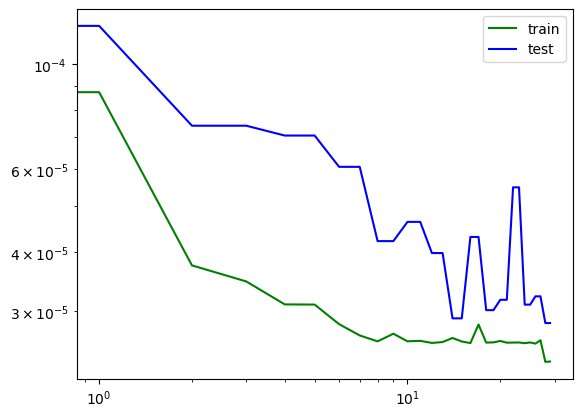

100%|██████████| 30/30 [01:27<00:00,  2.90s/it]


Number of predicted anomalies for 2023 0


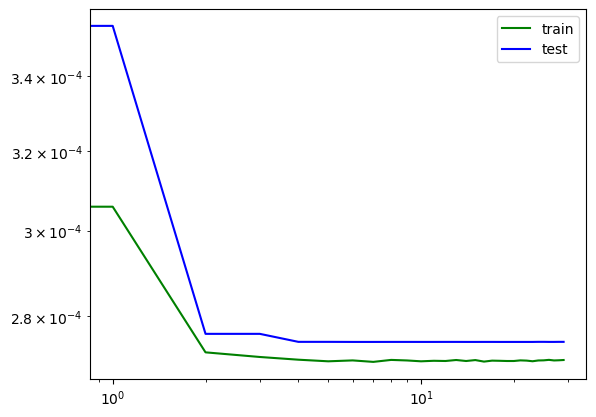

100%|██████████| 30/30 [01:28<00:00,  2.94s/it]


Number of predicted anomalies for 2023 191


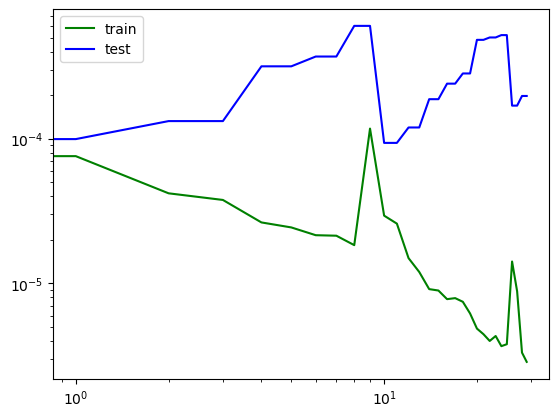

100%|██████████| 30/30 [01:28<00:00,  2.93s/it]


Number of predicted anomalies for 2023 16


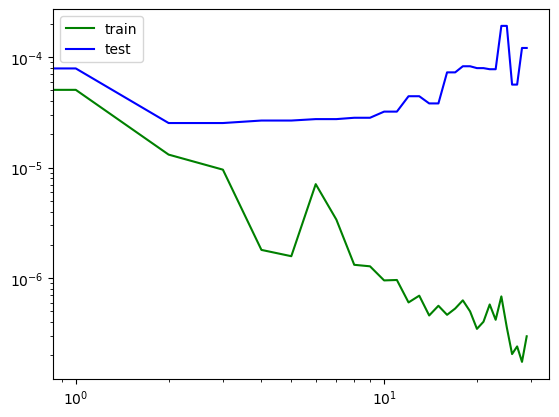

100%|██████████| 30/30 [01:26<00:00,  2.88s/it]


Number of predicted anomalies for 2023 427


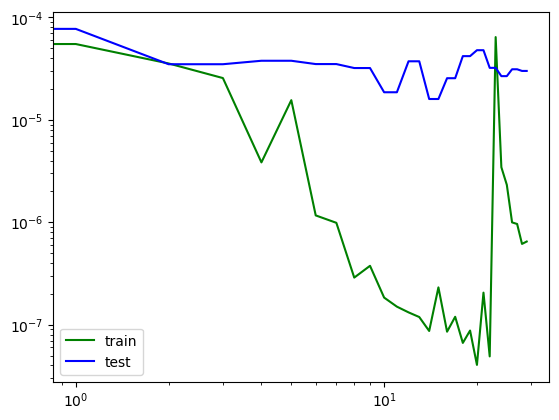

100%|██████████| 30/30 [01:30<00:00,  3.02s/it]


Number of predicted anomalies for 2023 155


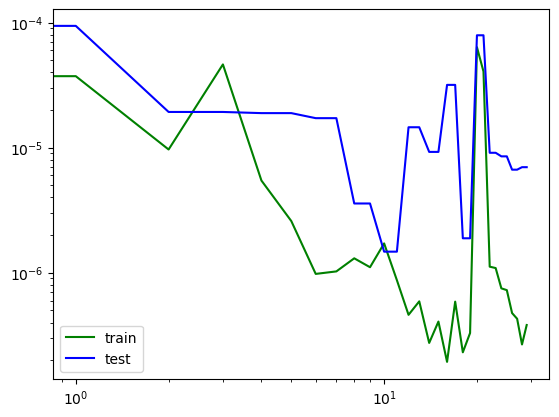

100%|██████████| 30/30 [01:27<00:00,  2.92s/it]


Number of predicted anomalies for 2023 126


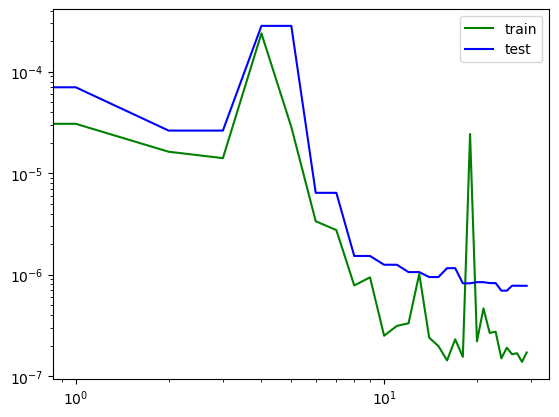

   architecture  weight_normal  weight_anomaly  number_of_units  \
0             3            2.0             2.0                3   
1             3            2.0             2.0                5   
2             3            2.0             2.0                7   
3             3            2.0             2.0                9   
4             3            2.0             2.0               11   
5             3            2.0             2.0               13   
6             3            2.0             2.0               15   

   train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  \
0          2.315954e-05        0.993412      0.999727         2.763904e-05   
1          2.701620e-04        0.924015      0.000000         2.742177e-04   
2          2.172878e-06        0.999648      0.998501         1.617238e-04   
3          1.320525e-06        0.999782      0.997137         3.874578e-05   
4          7.098957e-07        0.999917      0.999046         1.914633e-0

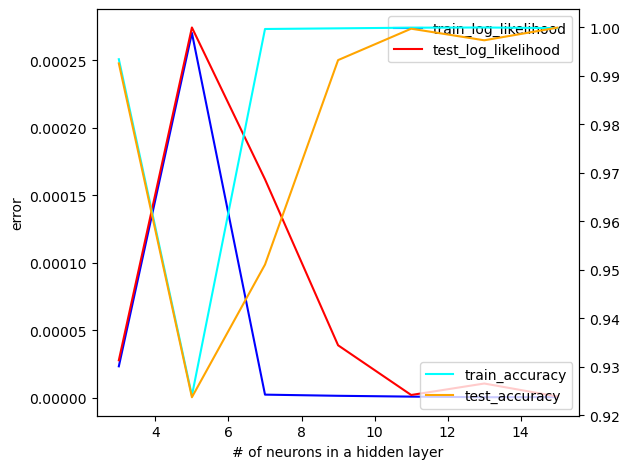

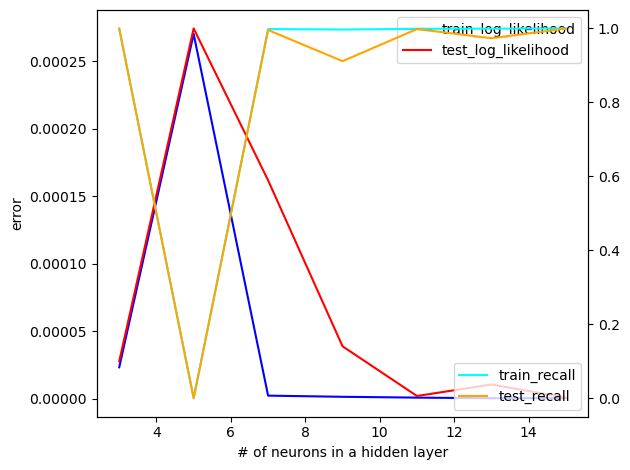

optimal value of the number of units per layer is 15


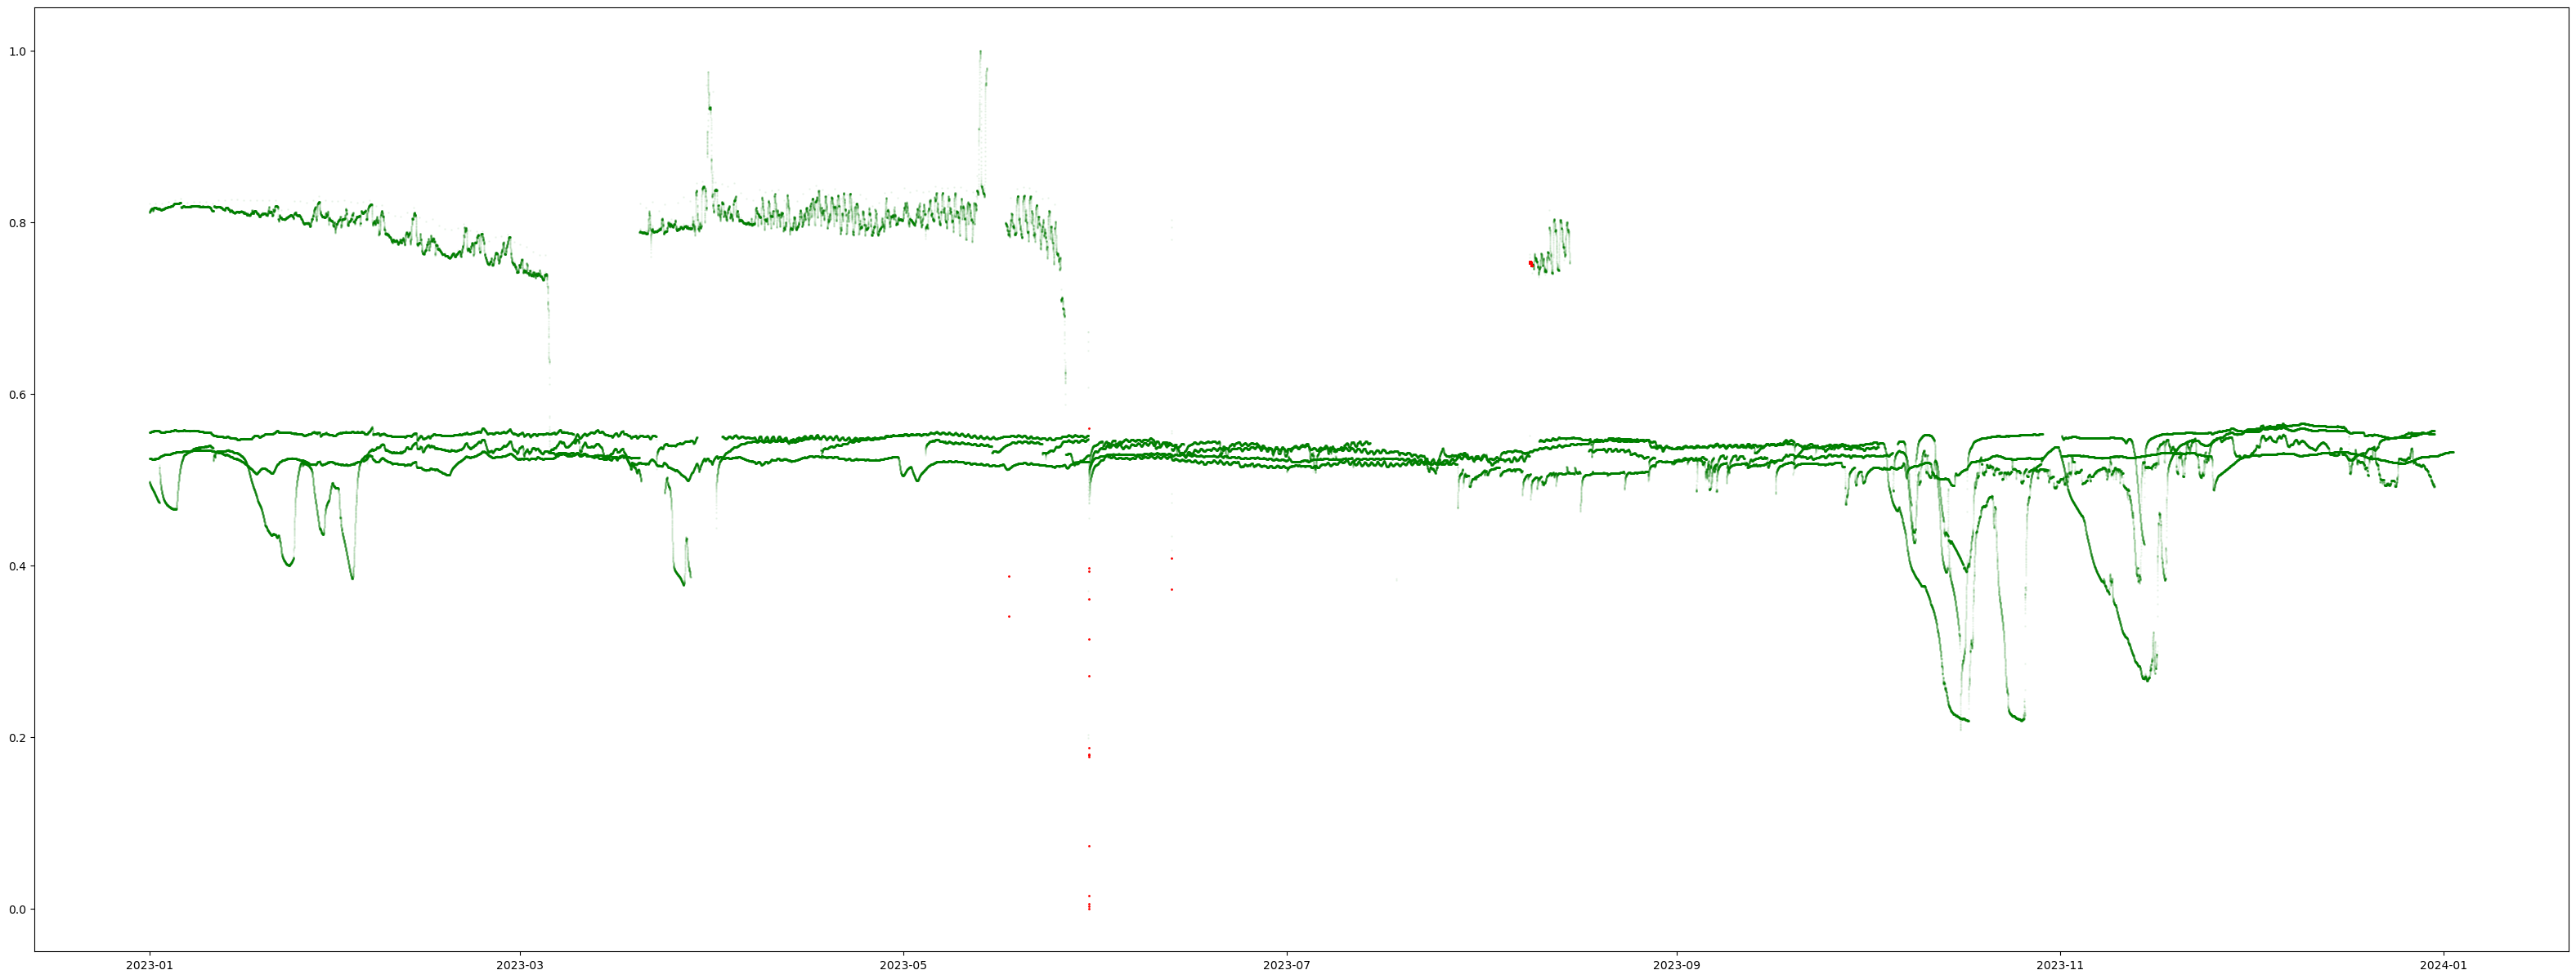

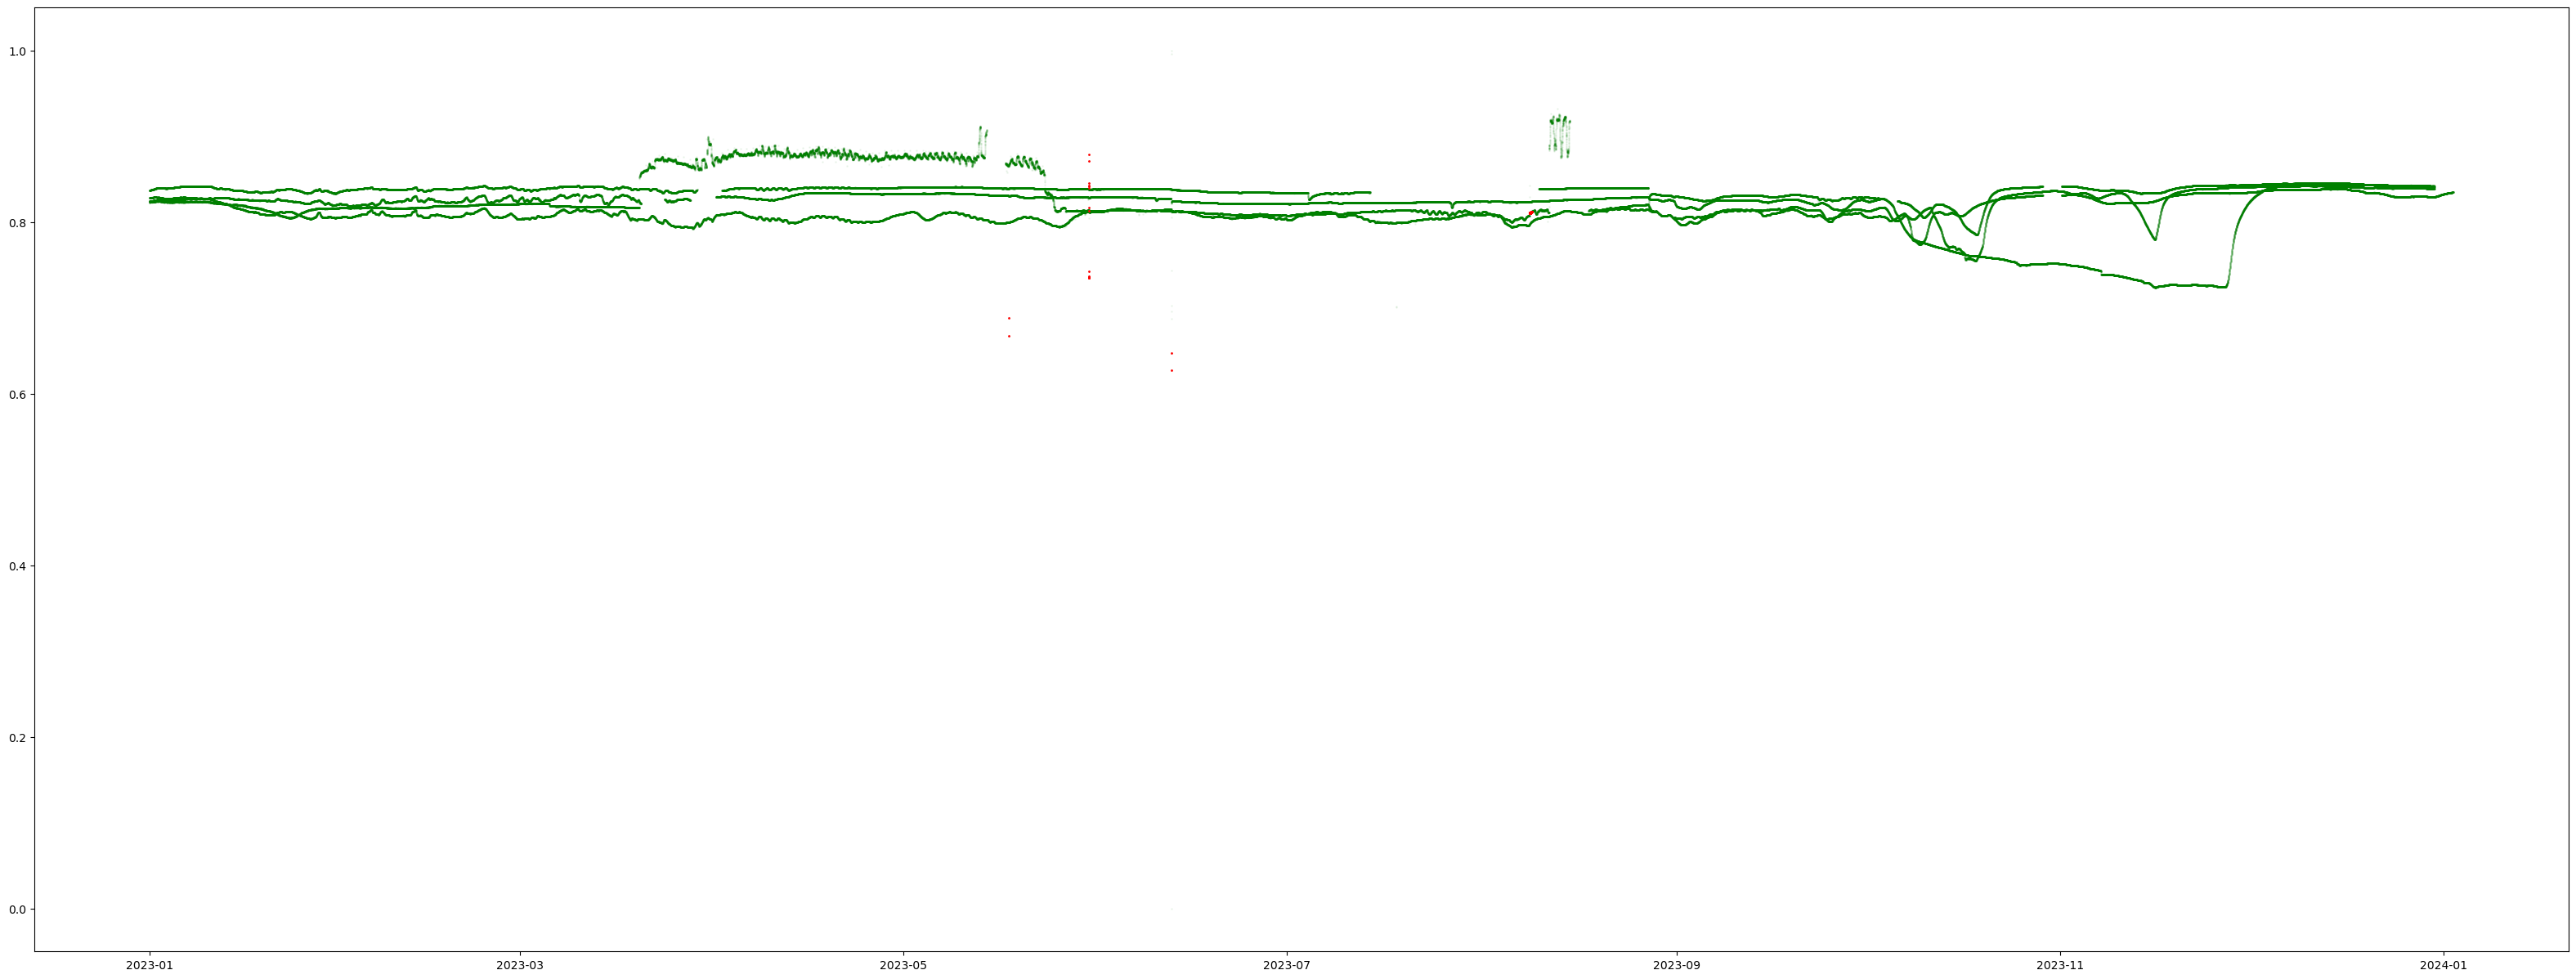

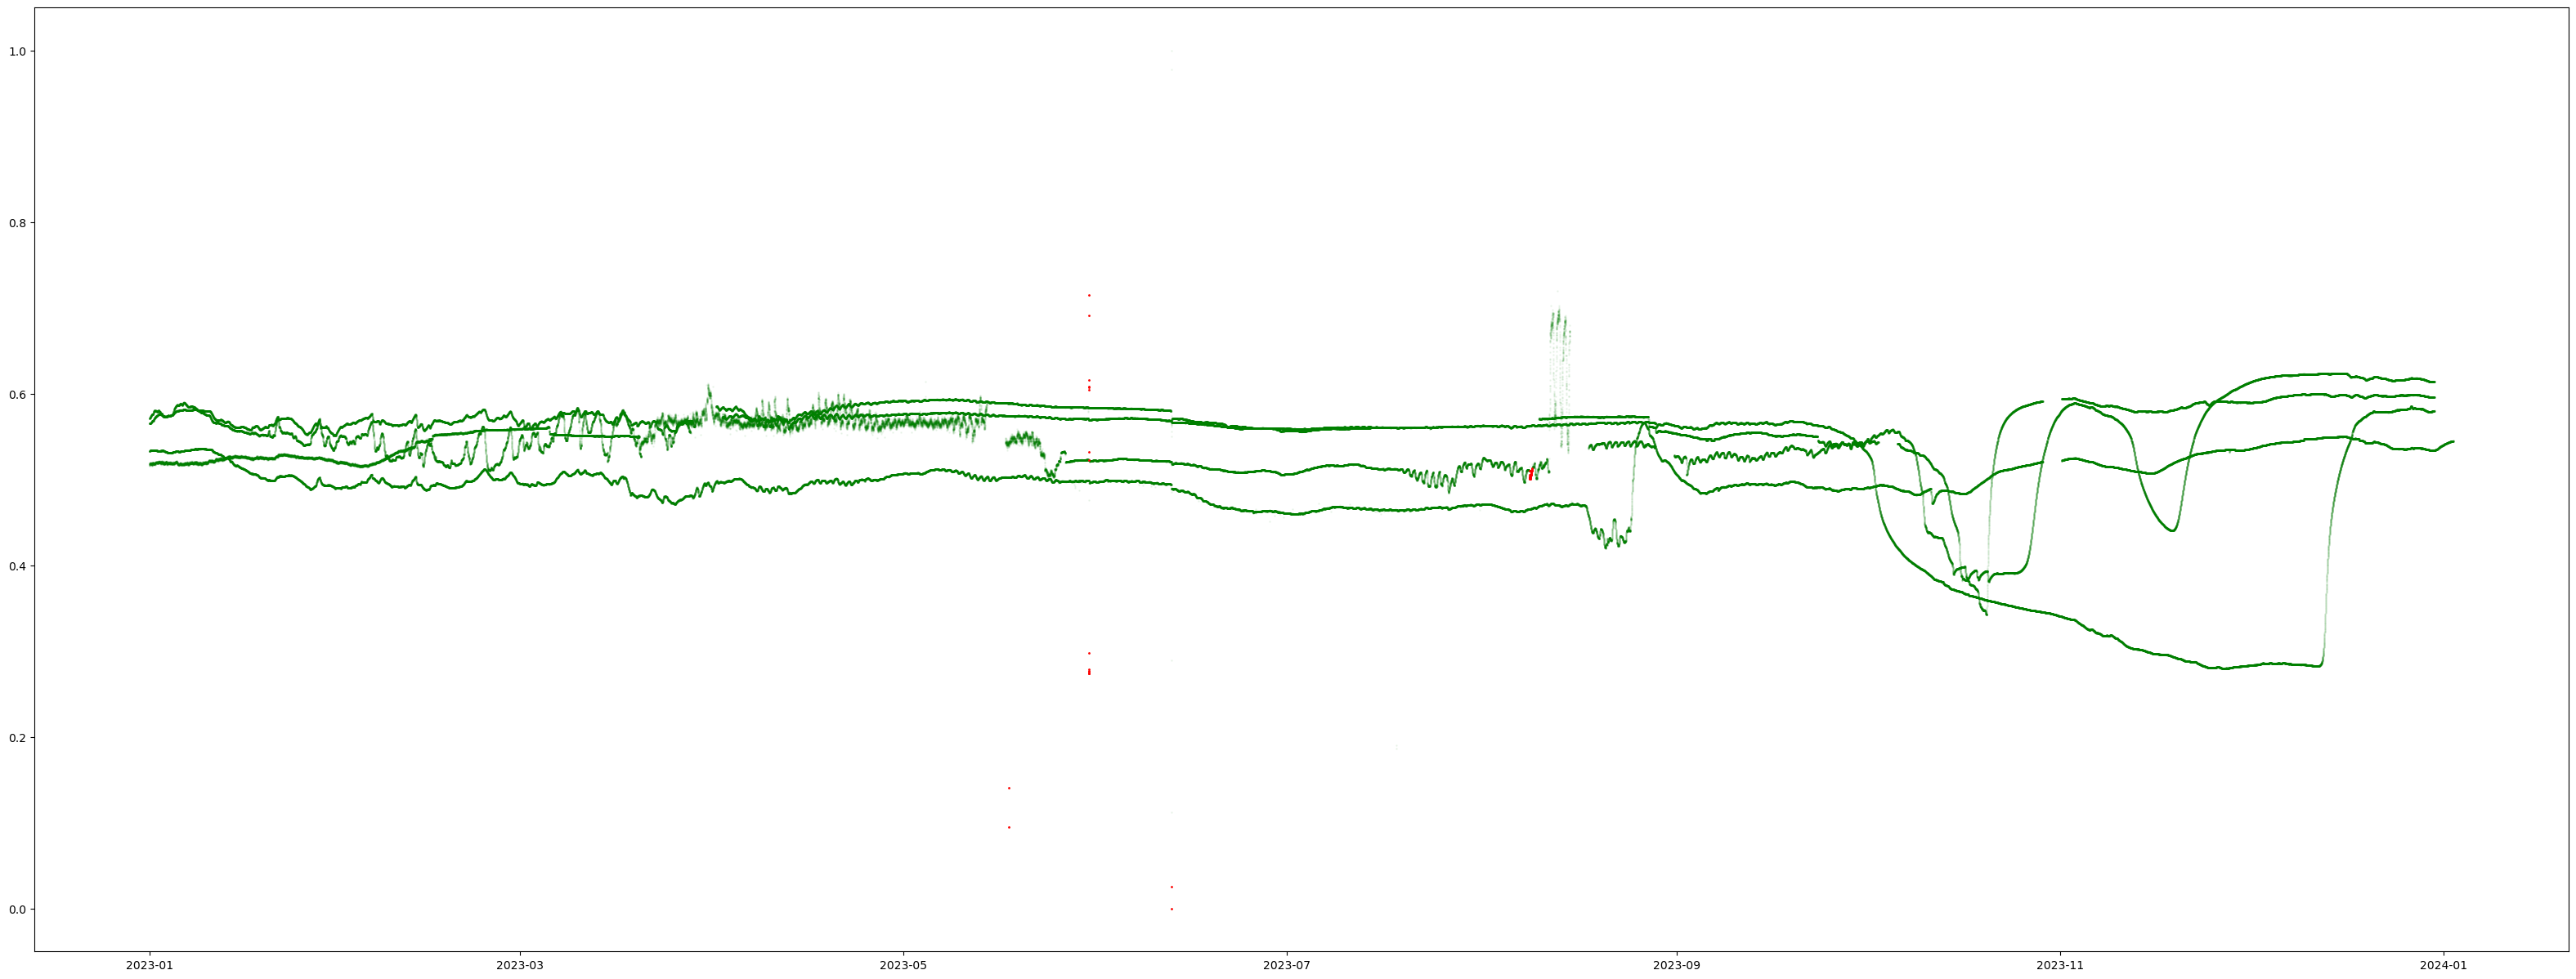

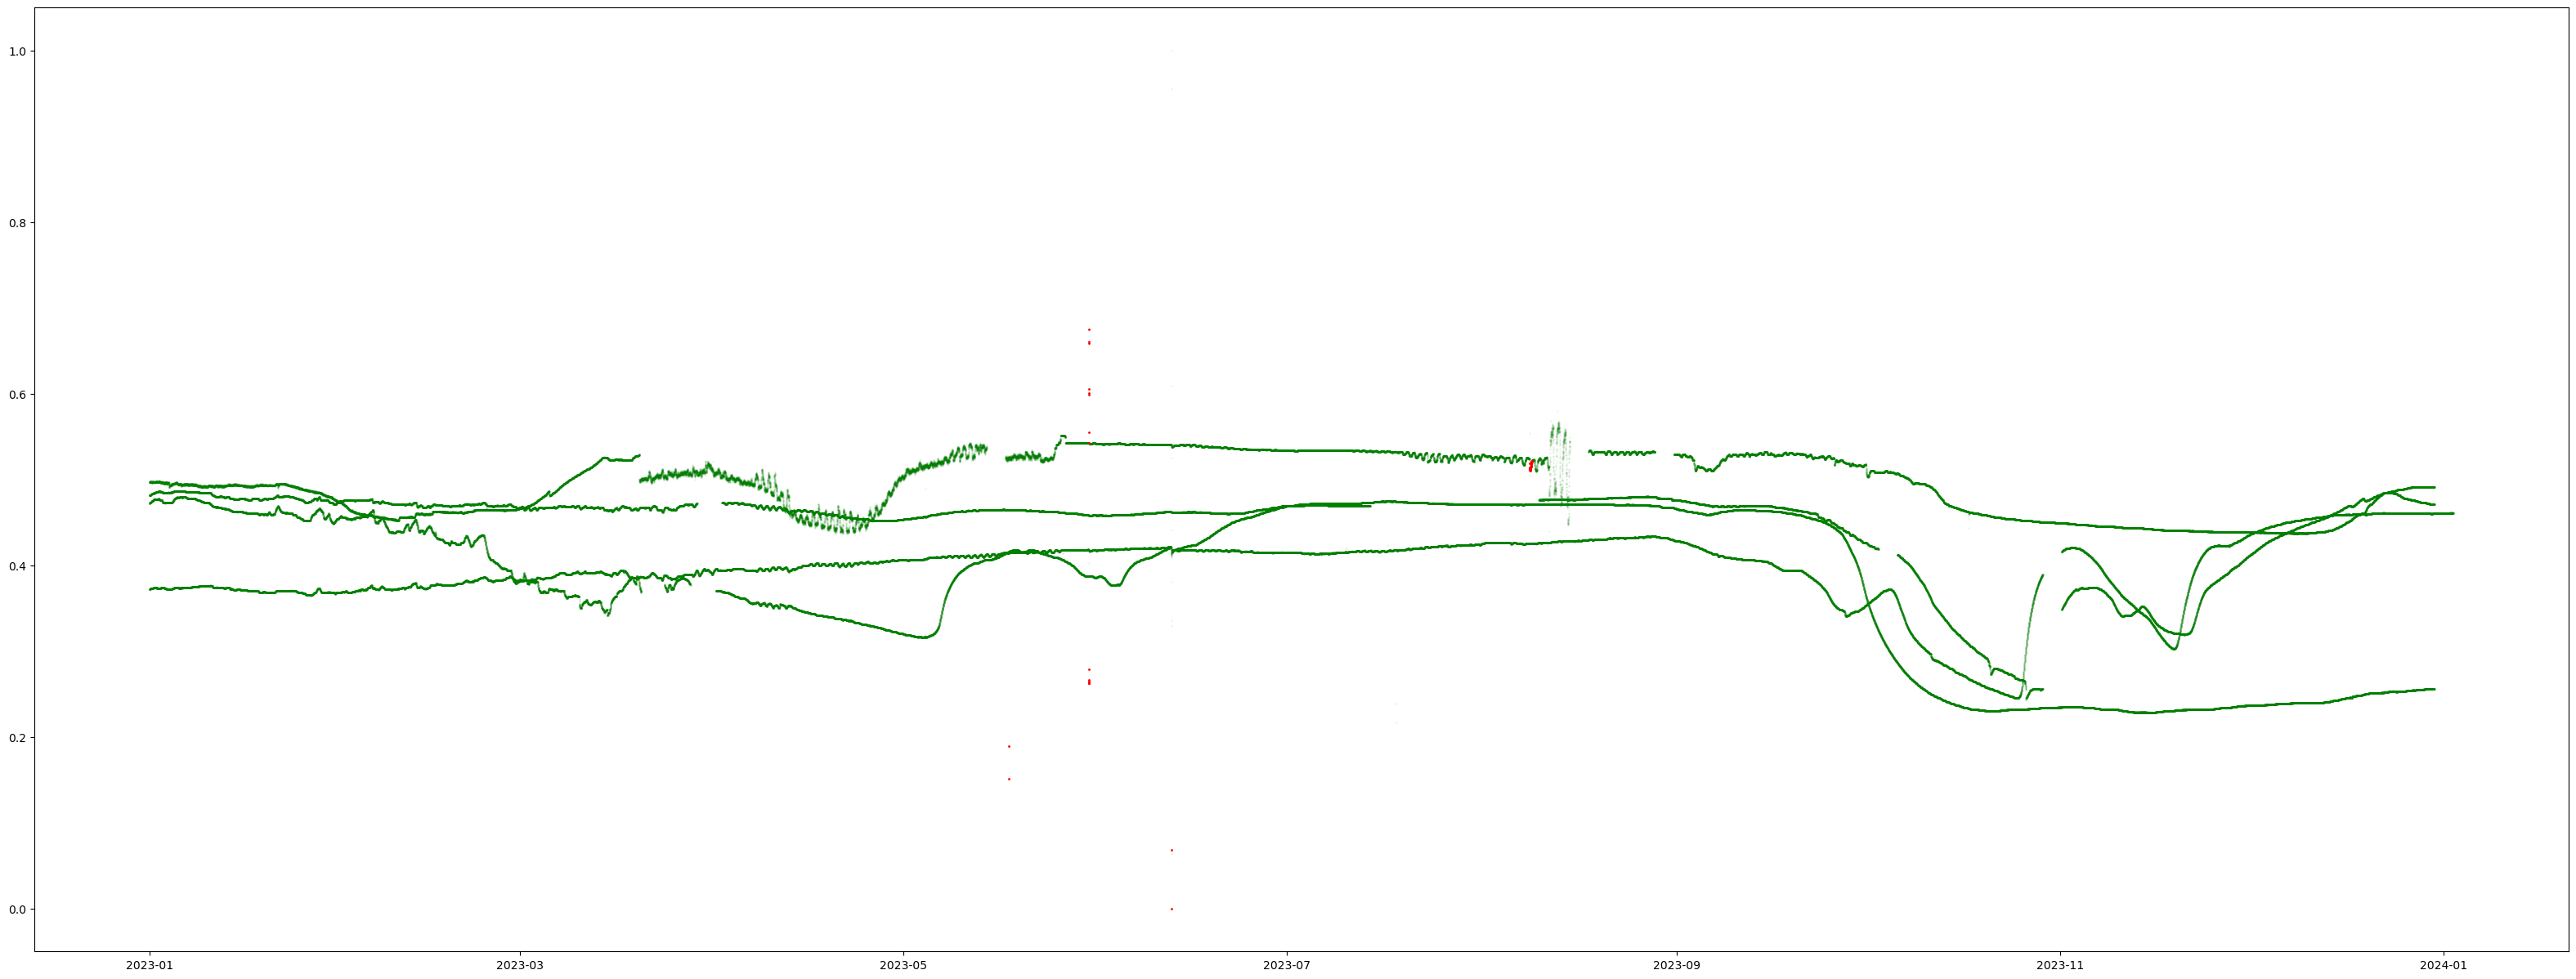

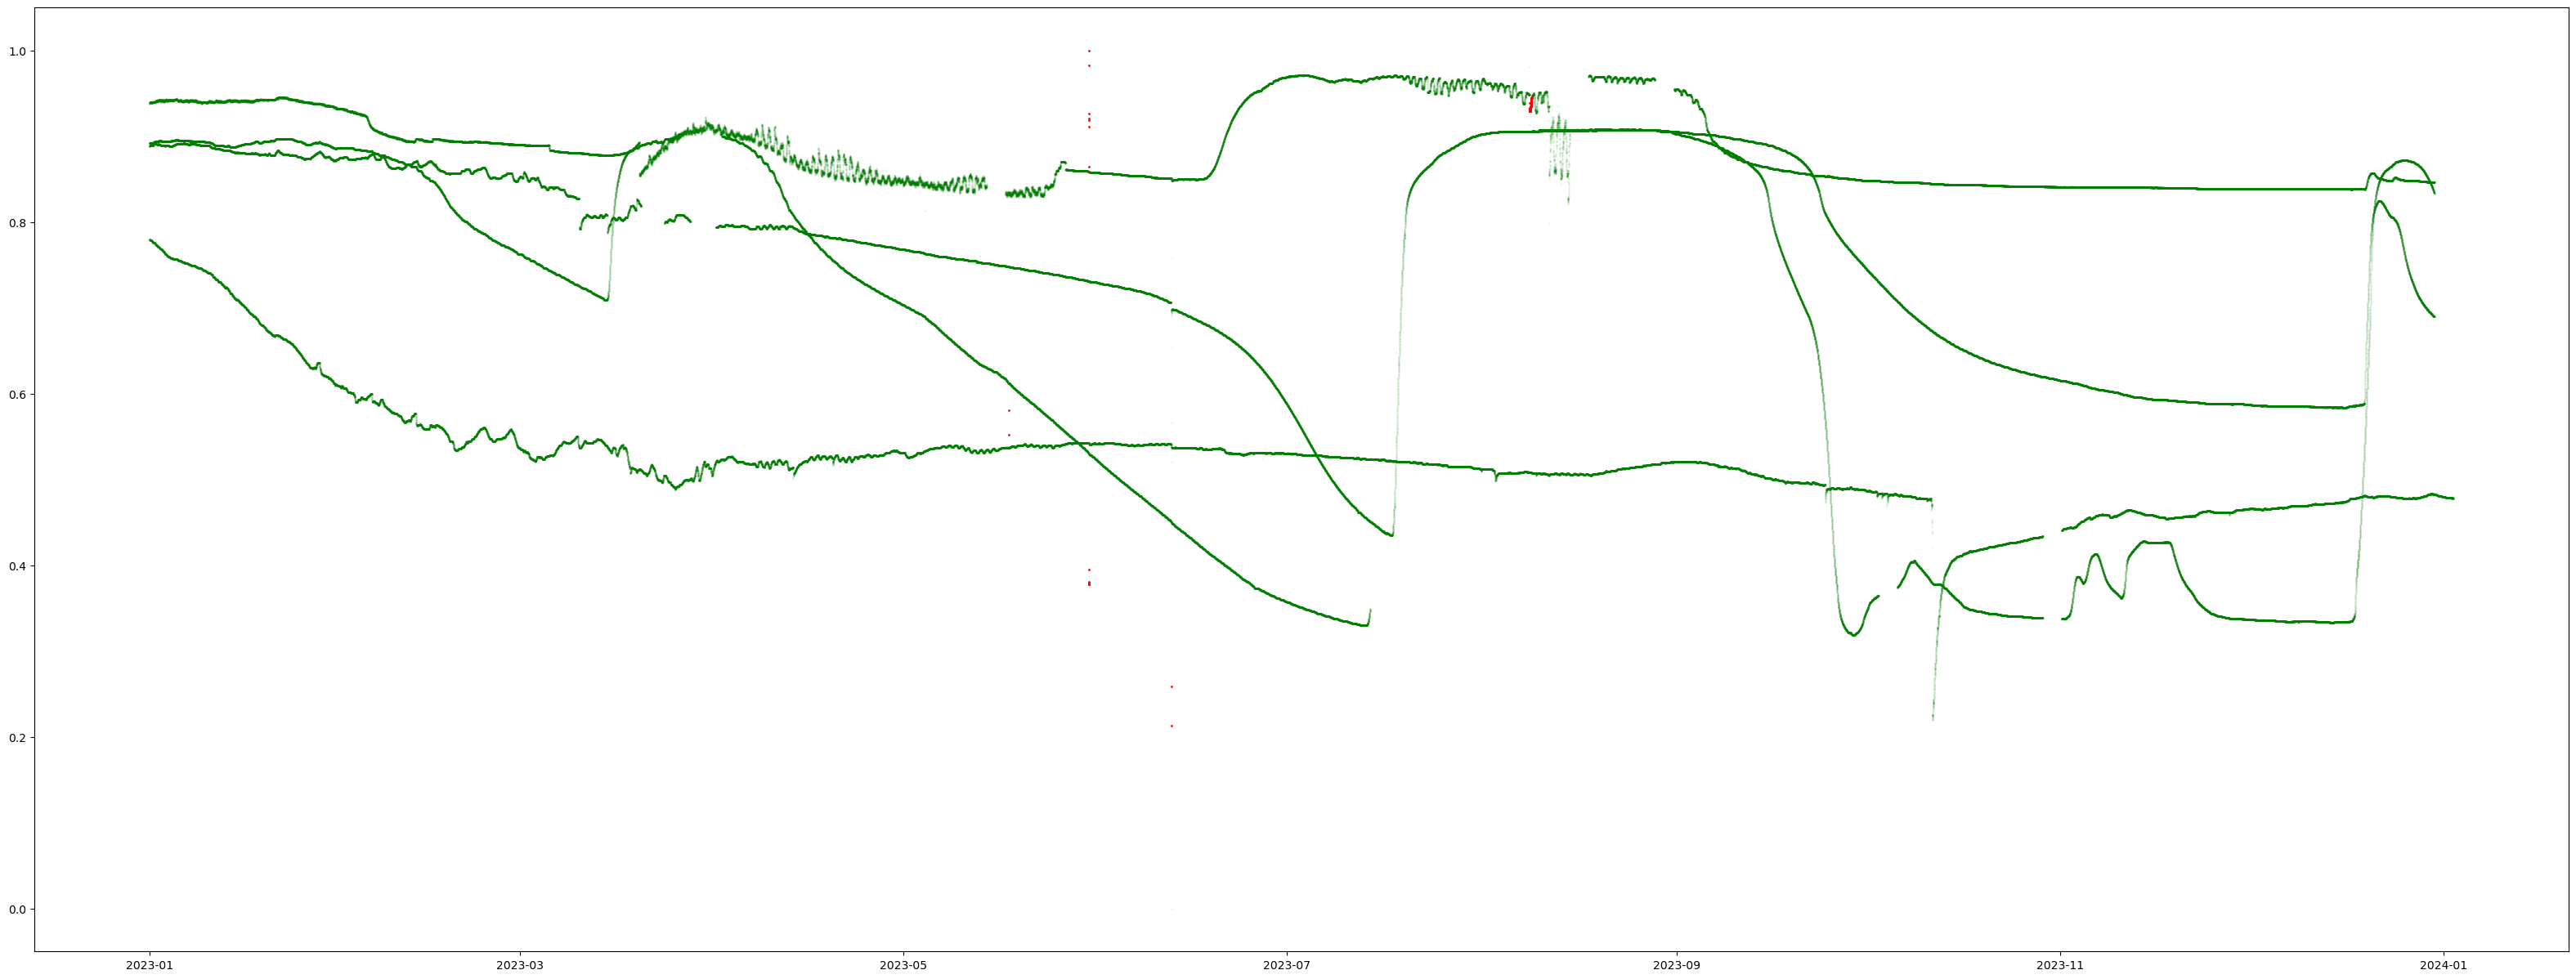

----------------------
calculating 'all-sensors' model for the following parameters: architecture - <class 'Net3.Net3'>, weight = [2.0, 4.0]
----------------------


100%|██████████| 30/30 [01:27<00:00,  2.90s/it]


Number of predicted anomalies for 2023 0


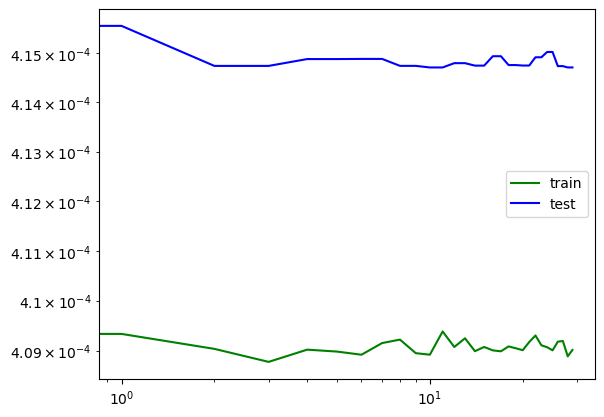

100%|██████████| 30/30 [01:26<00:00,  2.90s/it]


Number of predicted anomalies for 2023 493


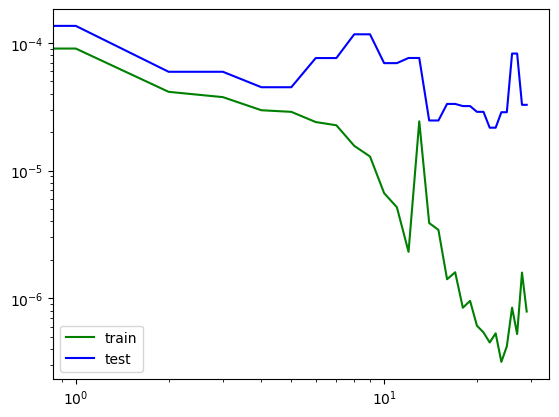

100%|██████████| 30/30 [01:28<00:00,  2.93s/it]


Number of predicted anomalies for 2023 9358


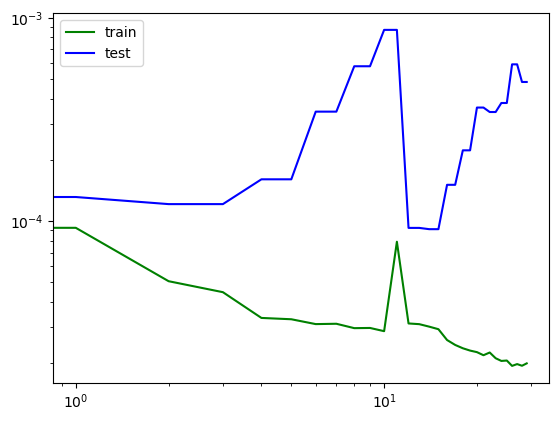

100%|██████████| 30/30 [01:28<00:00,  2.95s/it]


Number of predicted anomalies for 2023 201


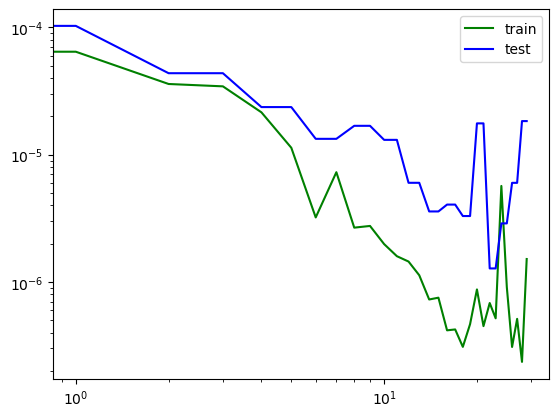

100%|██████████| 30/30 [01:26<00:00,  2.87s/it]


Number of predicted anomalies for 2023 510


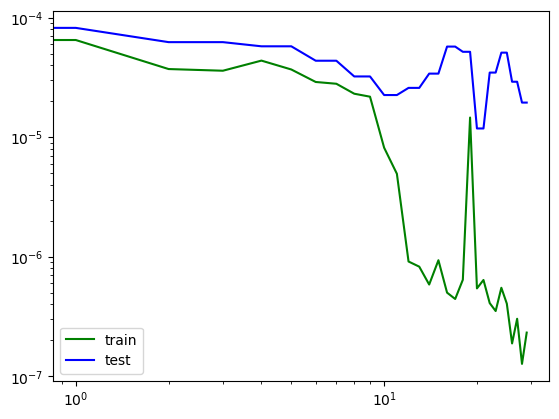

100%|██████████| 30/30 [01:24<00:00,  2.81s/it]


Number of predicted anomalies for 2023 1373


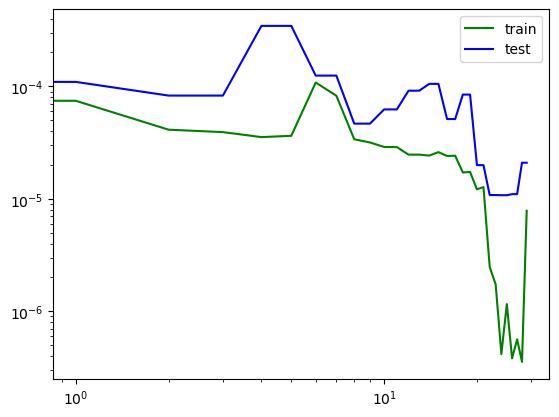

100%|██████████| 30/30 [01:24<00:00,  2.80s/it]


Number of predicted anomalies for 2023 177


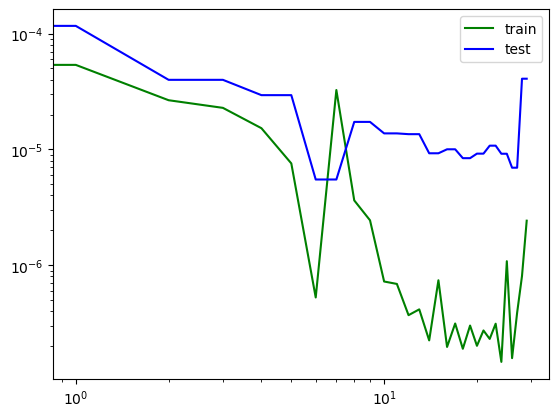

   architecture  weight_normal  weight_anomaly  number_of_units  \
0             3            2.0             4.0                3   
1             3            2.0             4.0                5   
2             3            2.0             4.0                7   
3             3            2.0             4.0                9   
4             3            2.0             4.0               11   
5             3            2.0             4.0               13   
6             3            2.0             4.0               15   

   train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  \
0          4.088223e-04        0.924015      0.000000             0.000415   
1          2.245791e-07        0.999959      0.999727             0.000033   
2          1.983060e-05        0.993381      0.985414             0.000374   
3          3.947287e-07        0.999948      0.999455             0.000005   
4          1.432757e-07        0.999979      0.999864             0.00001

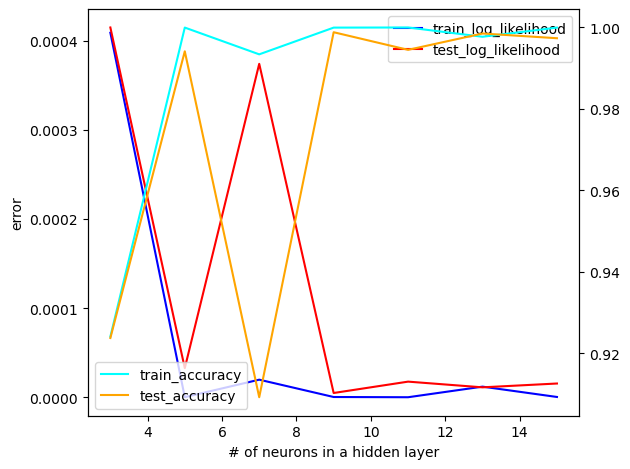

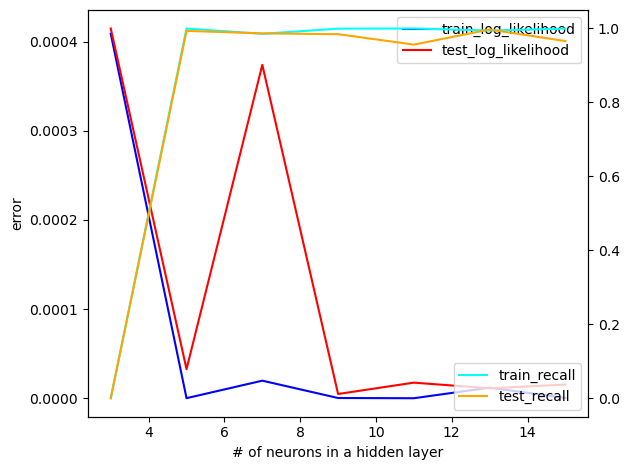

optimal value of the number of units per layer is 13


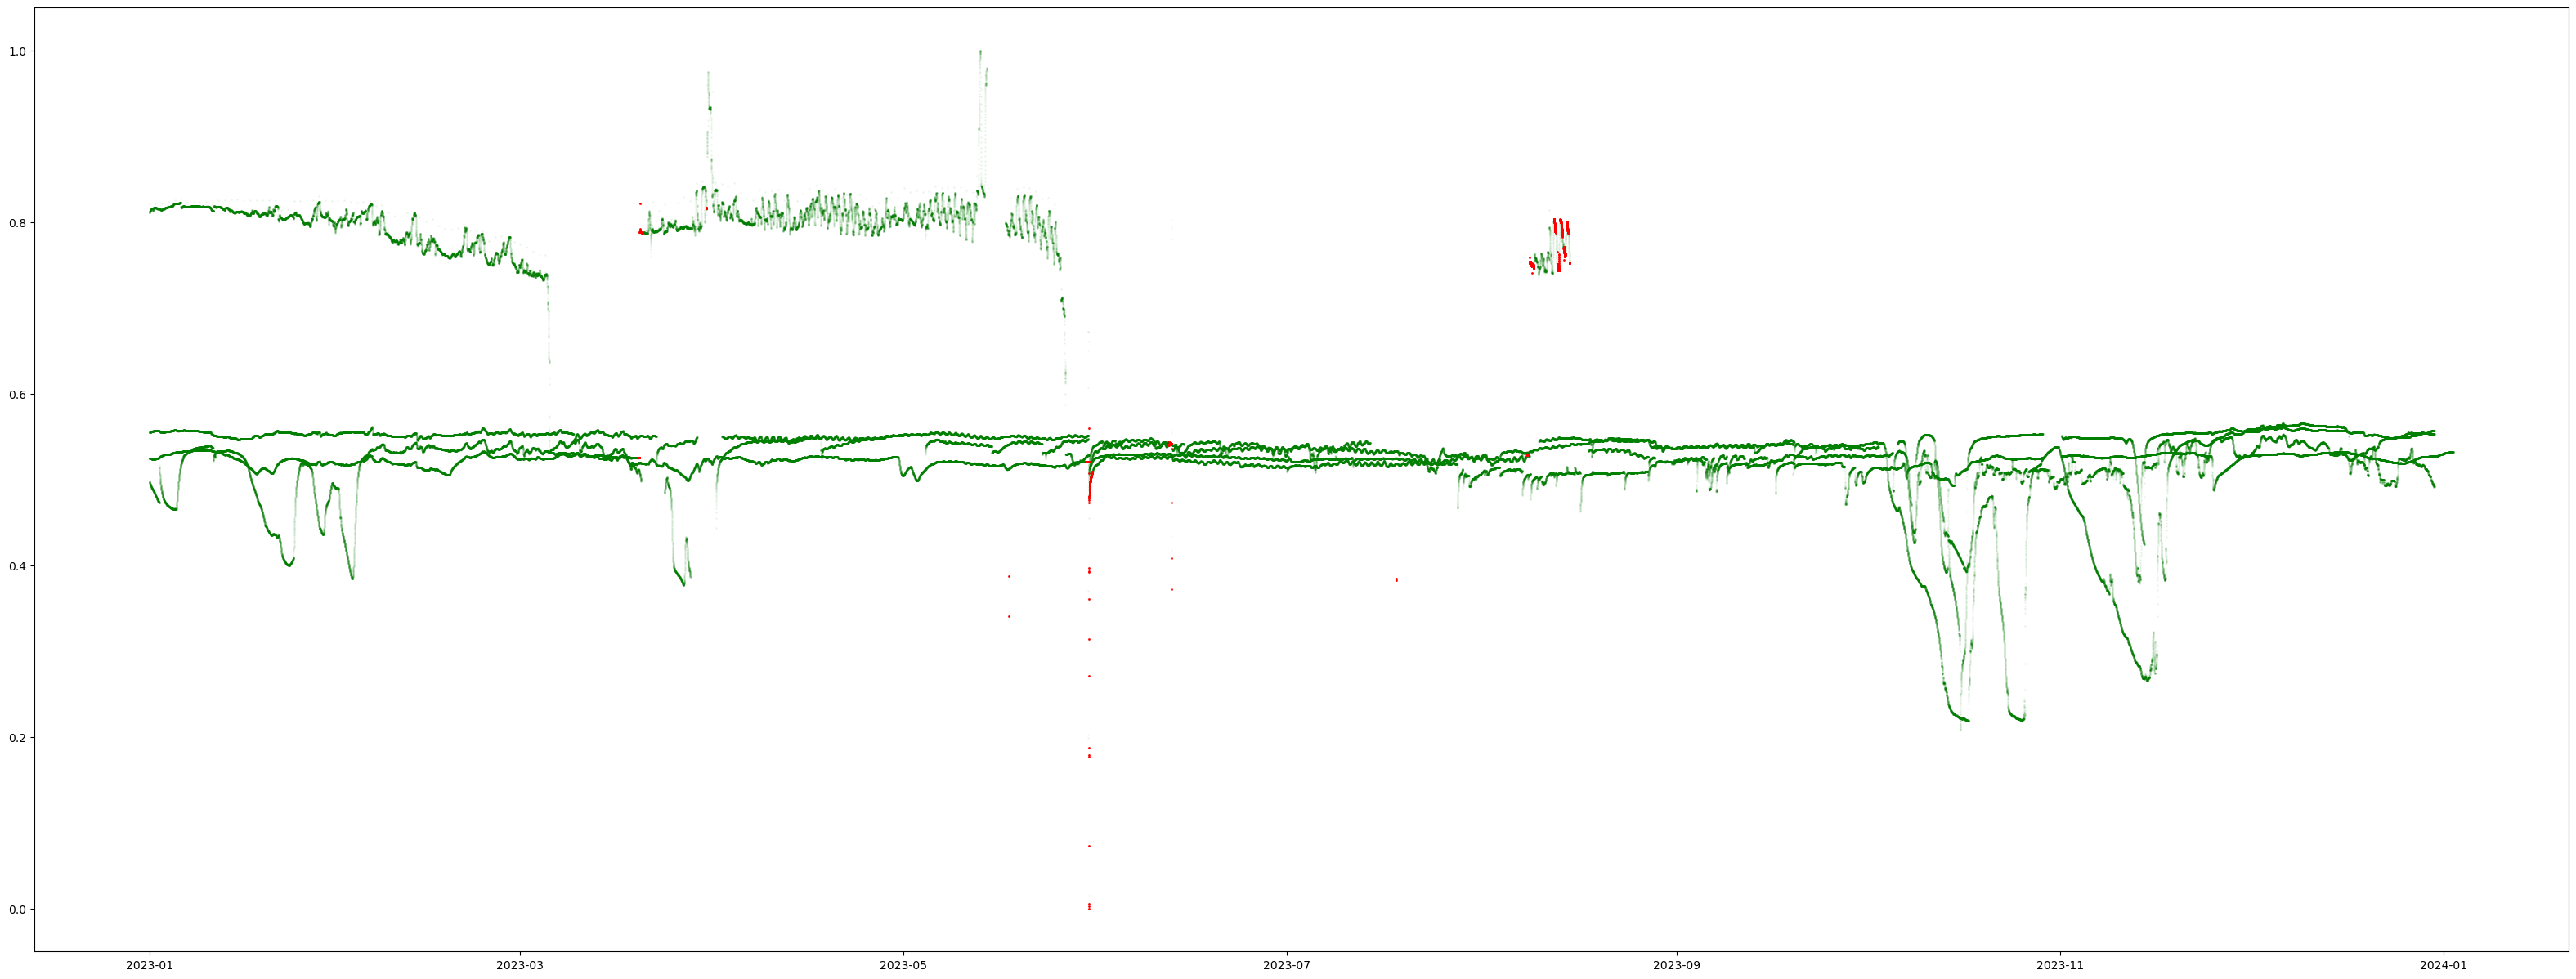

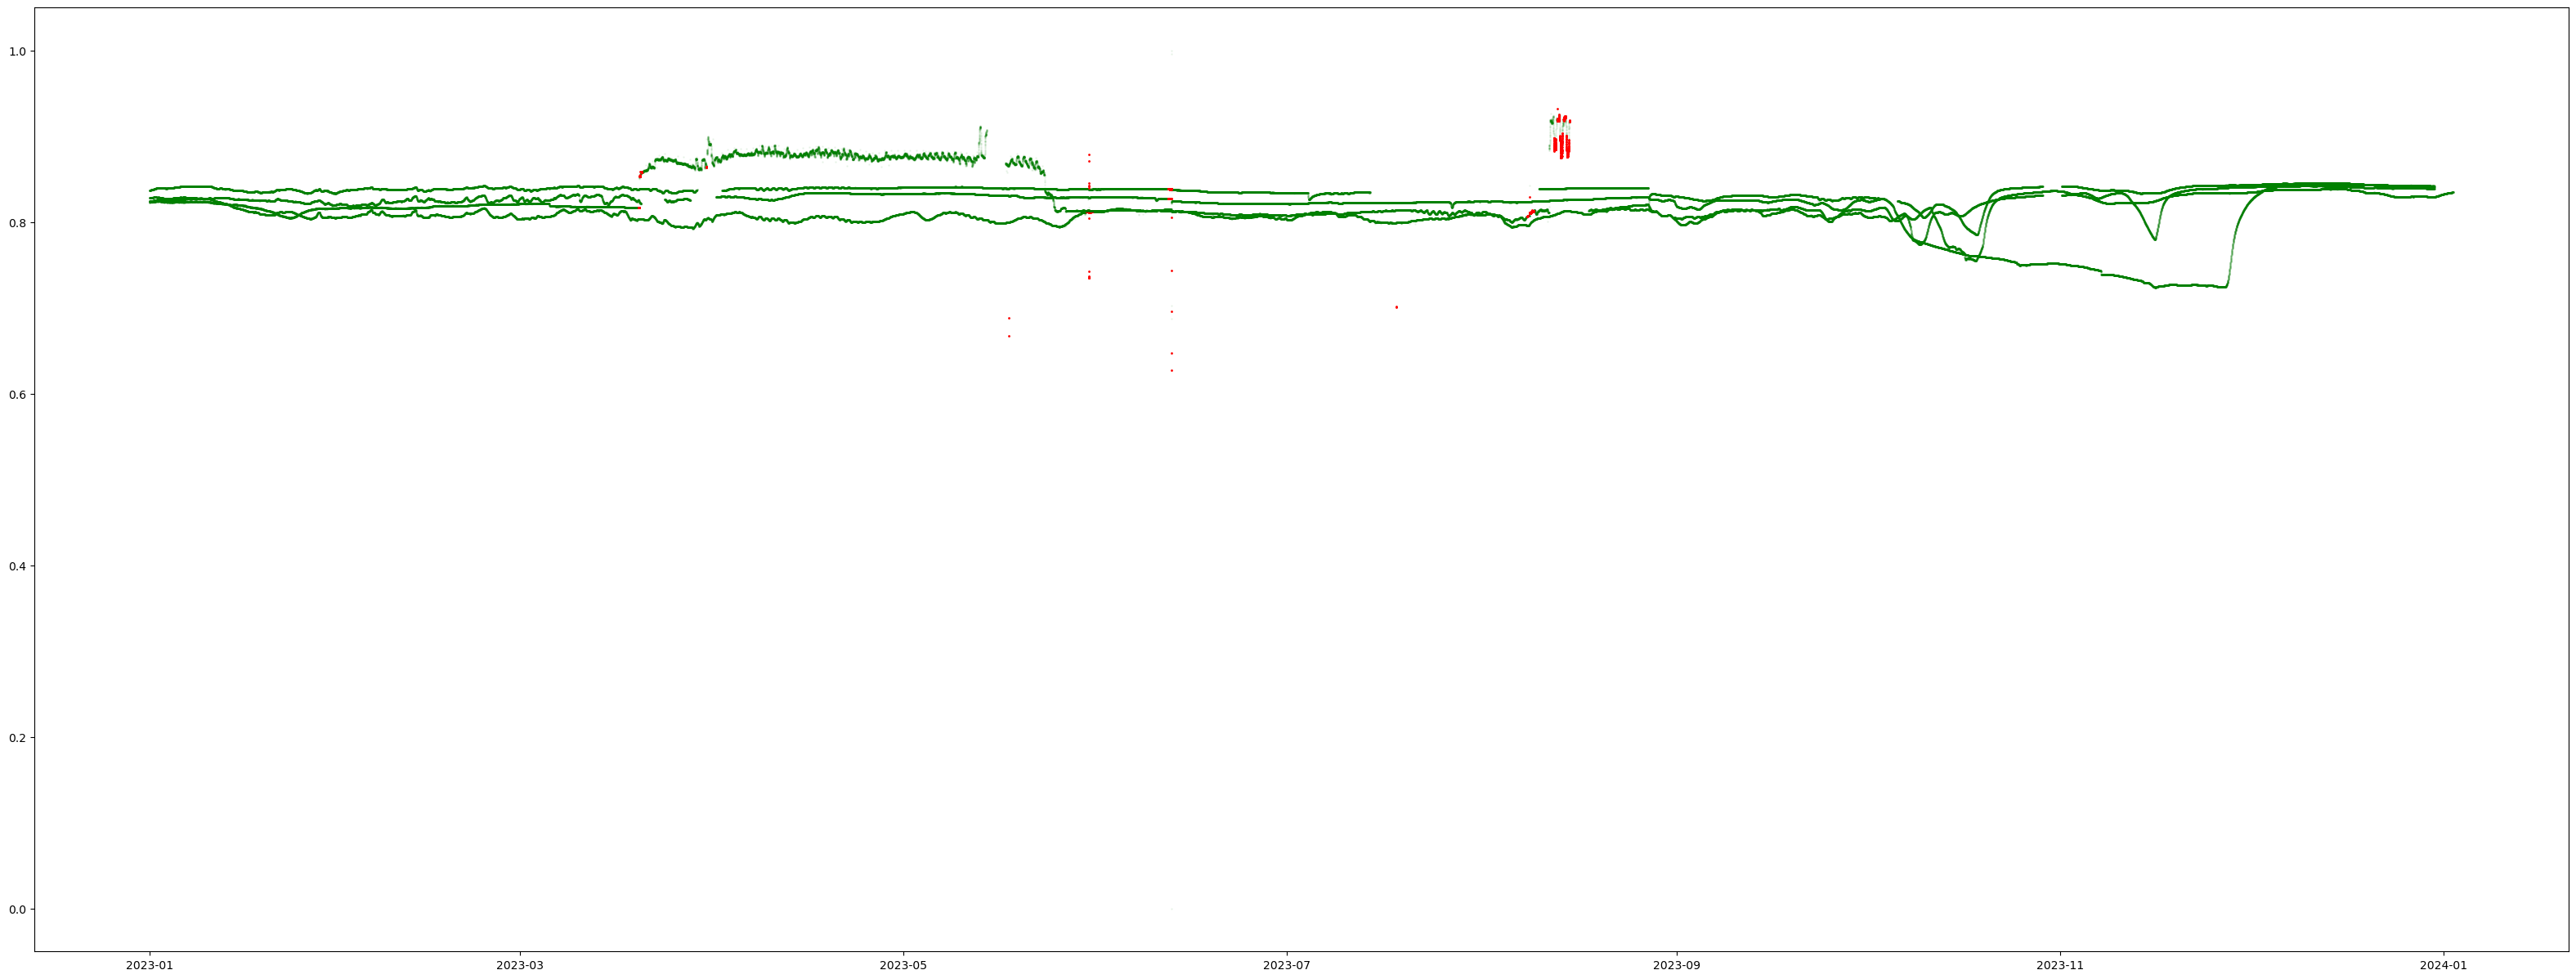

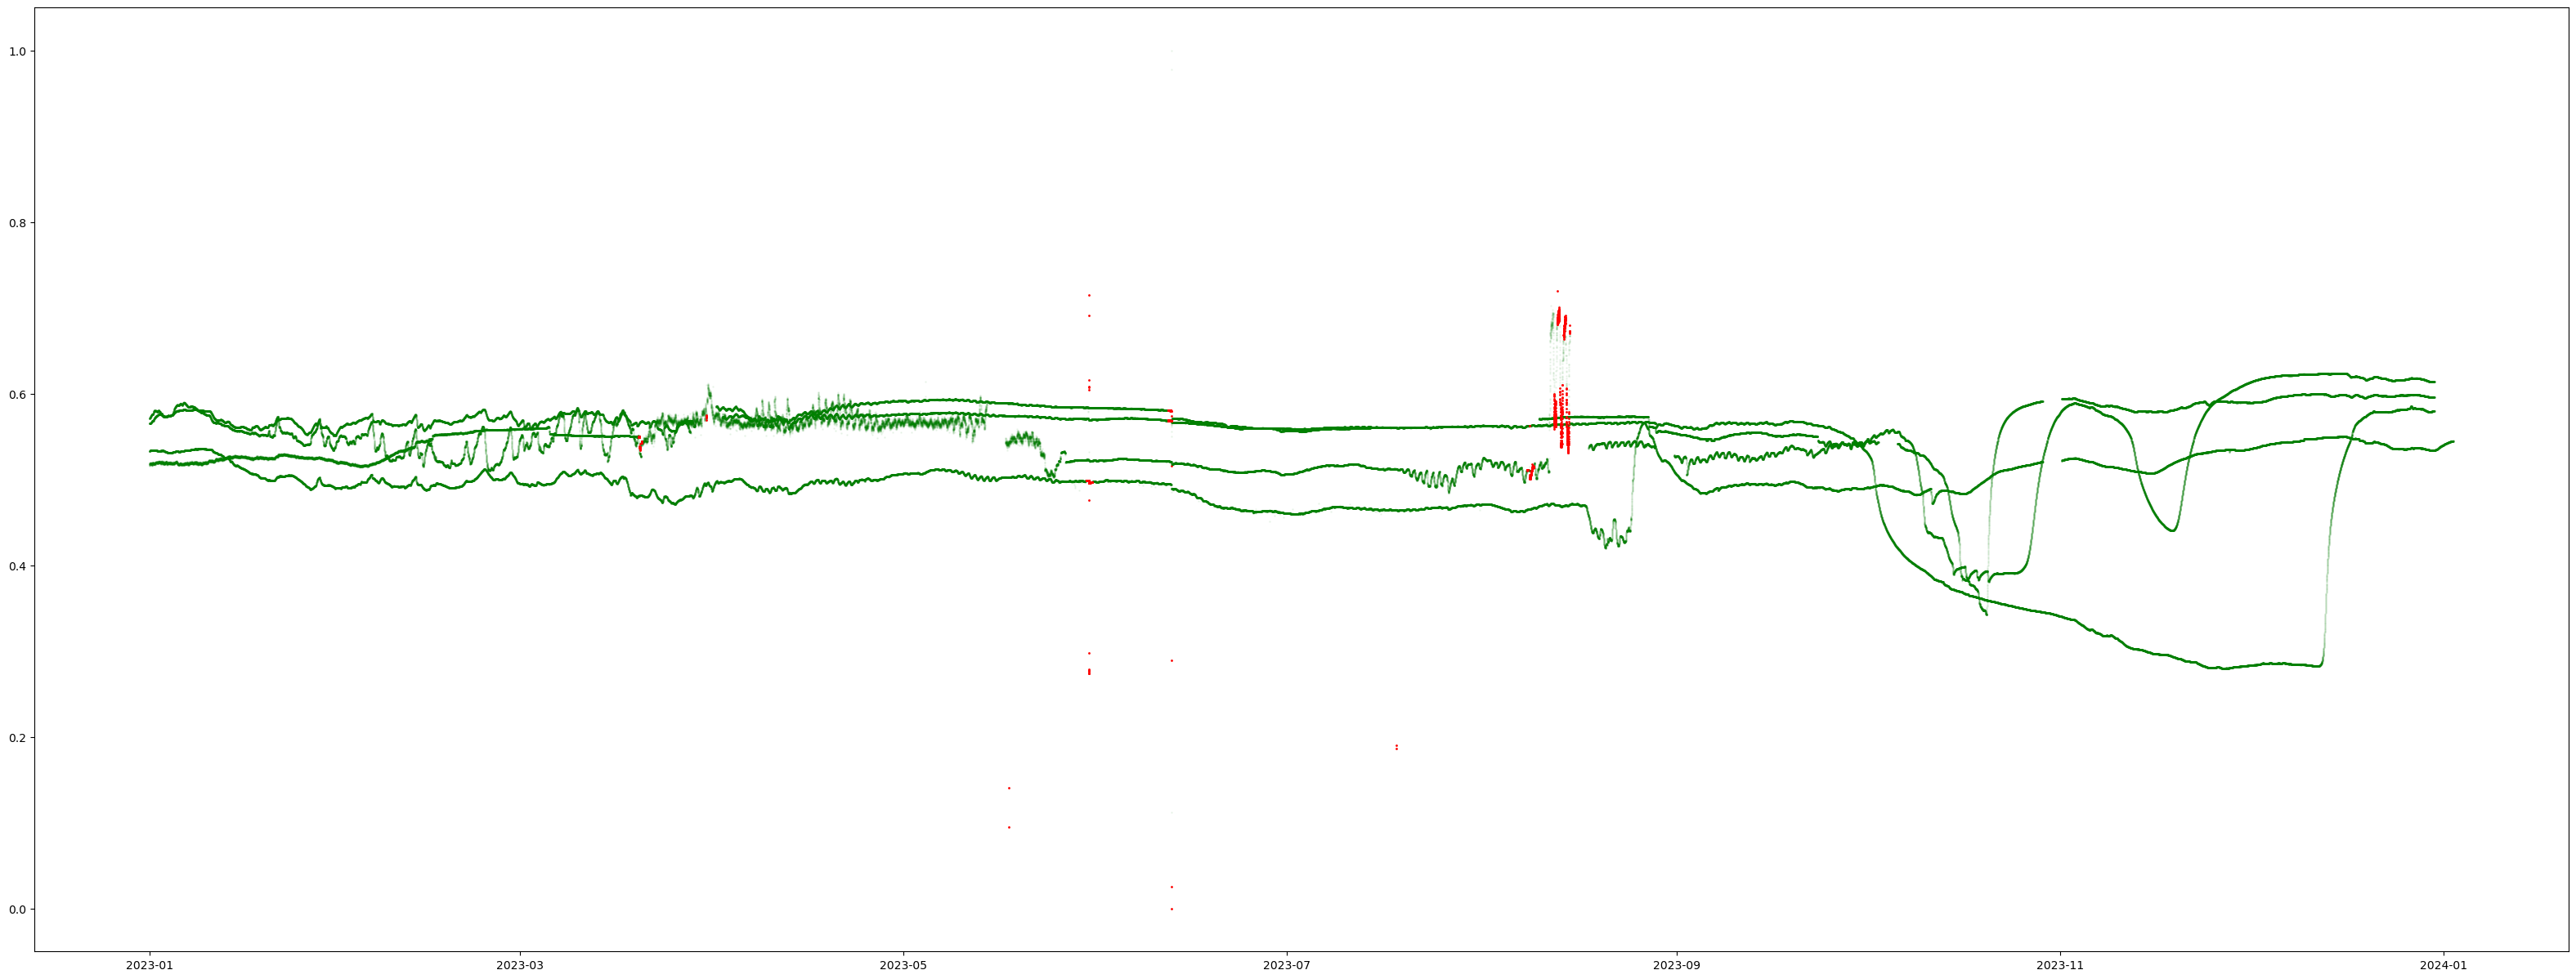

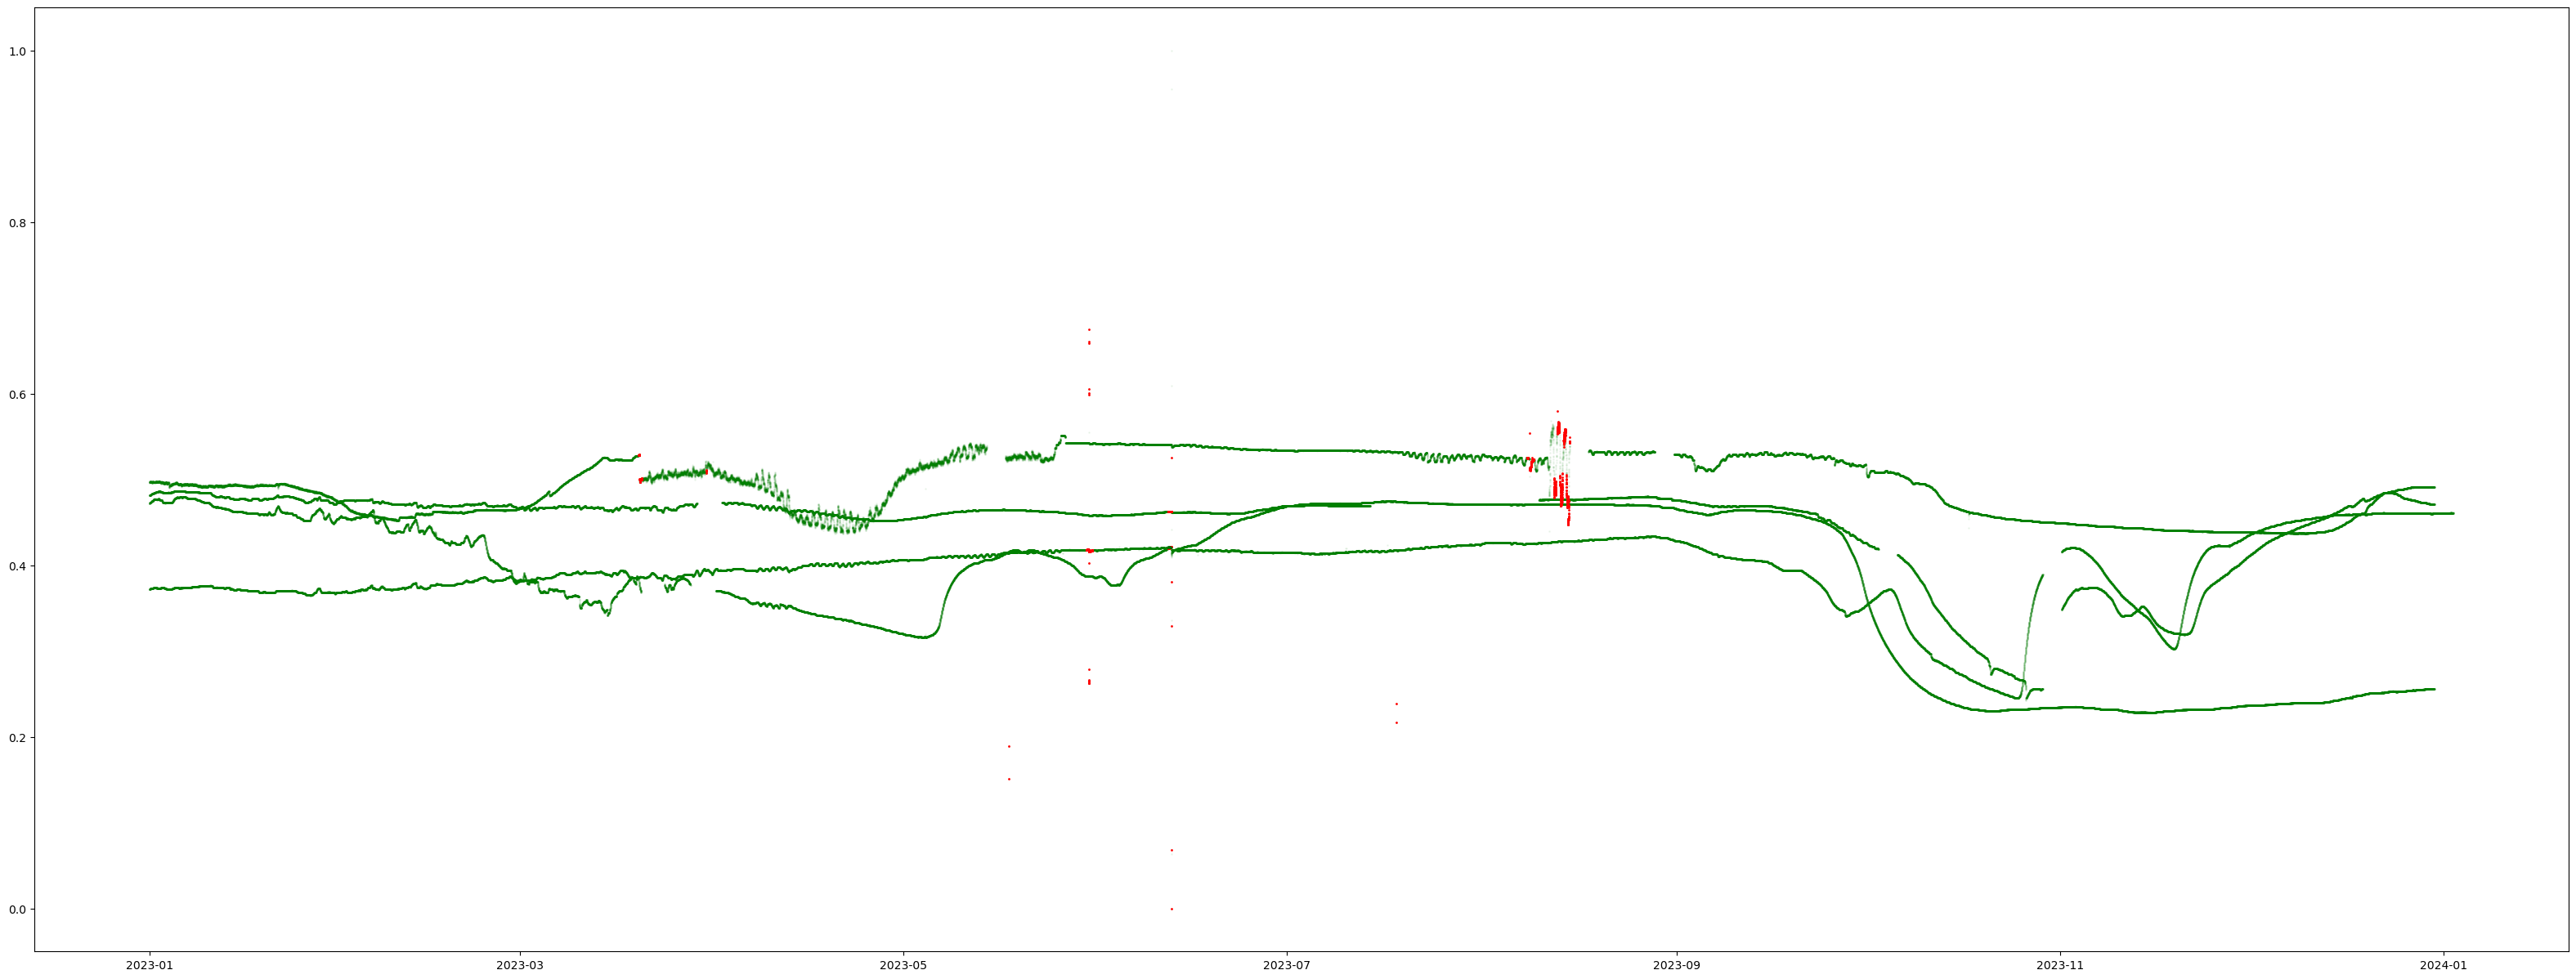

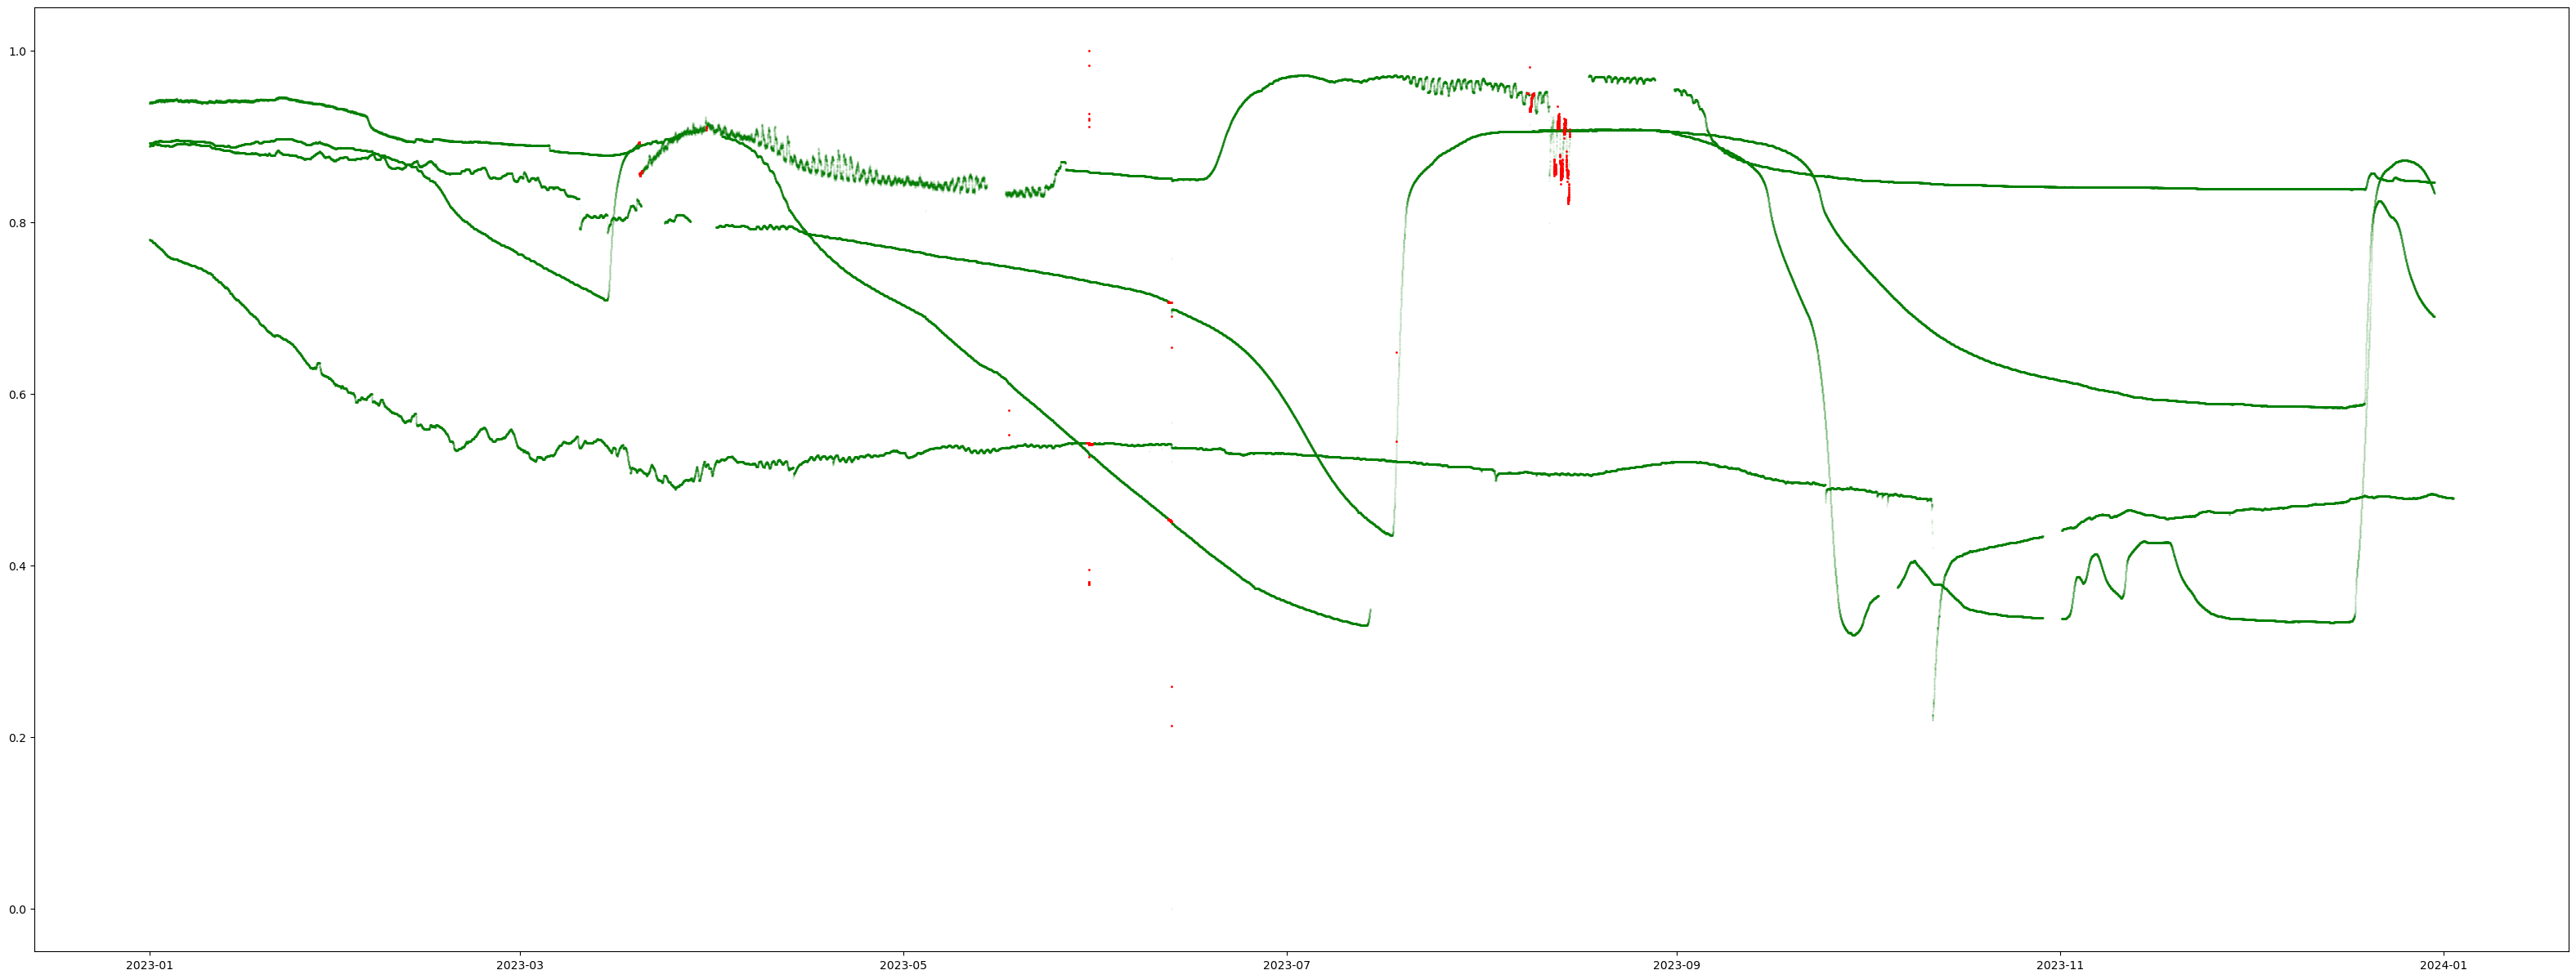

----------------------
calculating 'all-sensors' model for the following parameters: architecture - <class 'Net5.Net5'>, weight = [2.0, 2.0]
----------------------


100%|██████████| 30/30 [01:37<00:00,  3.25s/it]


Number of predicted anomalies for 2023 0


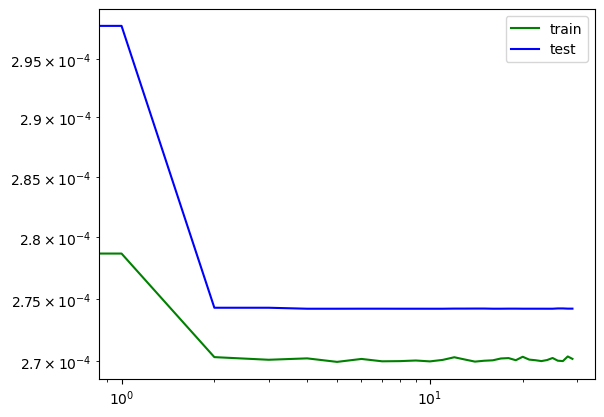

100%|██████████| 30/30 [01:37<00:00,  3.25s/it]


Number of predicted anomalies for 2023 3522


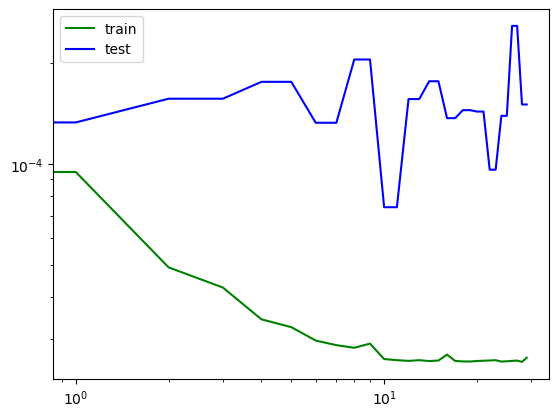

100%|██████████| 30/30 [01:38<00:00,  3.29s/it]


Number of predicted anomalies for 2023 0


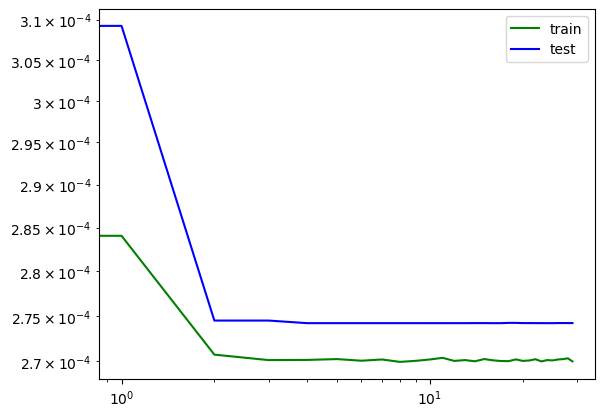

100%|██████████| 30/30 [01:39<00:00,  3.31s/it]


Number of predicted anomalies for 2023 0


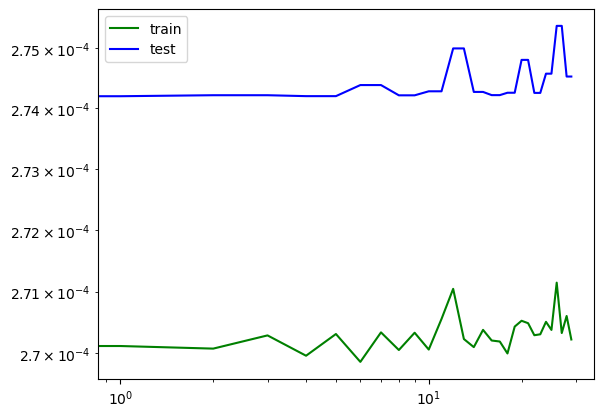

100%|██████████| 30/30 [01:36<00:00,  3.21s/it]


Number of predicted anomalies for 2023 0


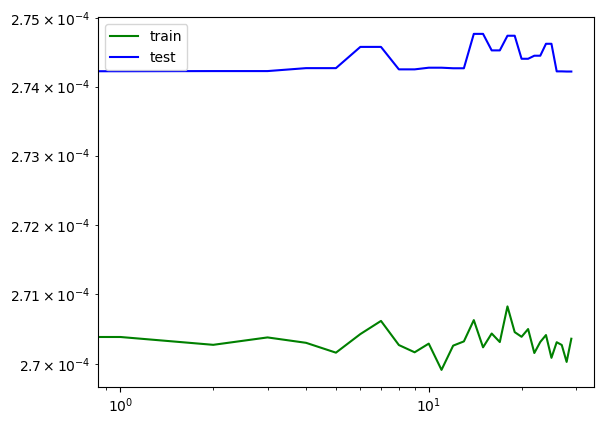

100%|██████████| 30/30 [01:35<00:00,  3.20s/it]


Number of predicted anomalies for 2023 3504


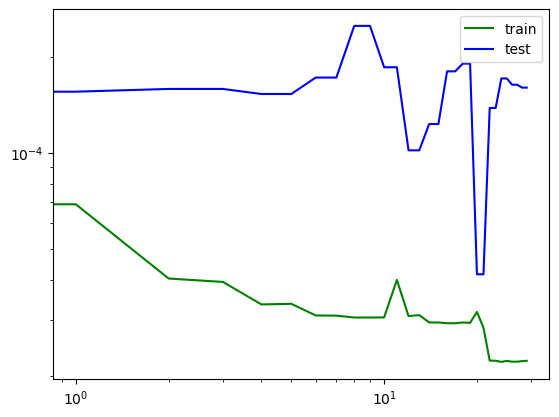

100%|██████████| 30/30 [01:38<00:00,  3.28s/it]


Number of predicted anomalies for 2023 161


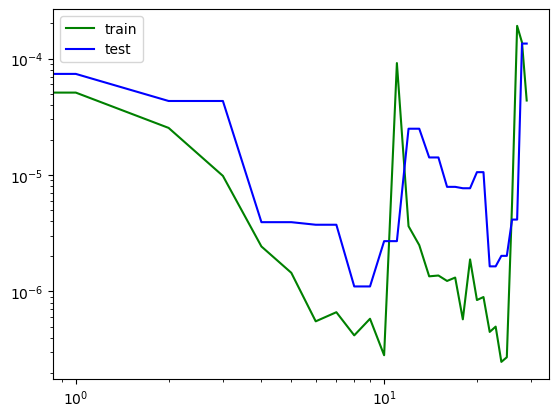

   architecture  weight_normal  weight_anomaly  number_of_units  \
0             5            2.0             2.0                3   
1             5            2.0             2.0                5   
2             5            2.0             2.0                7   
3             5            2.0             2.0                9   
4             5            2.0             2.0               11   
5             5            2.0             2.0               13   
6             5            2.0             2.0               15   

   train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  \
0              0.000270        0.924015      0.000000             0.000274   
1              0.000026        0.992366      0.999727             0.000145   
2              0.000270        0.924015      0.000000             0.000274   
3              0.000270        0.924015      0.000000             0.000274   
4              0.000270        0.924015      0.000000             0.00027

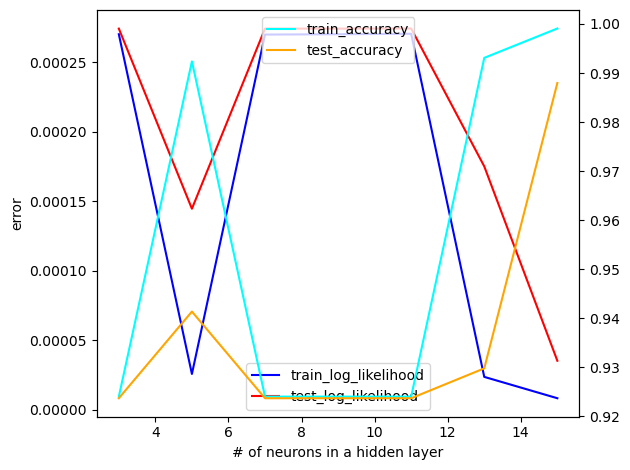

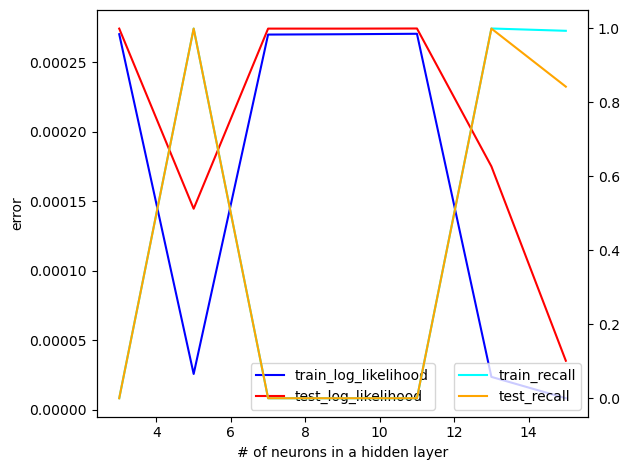

optimal value of the number of units per layer is 5


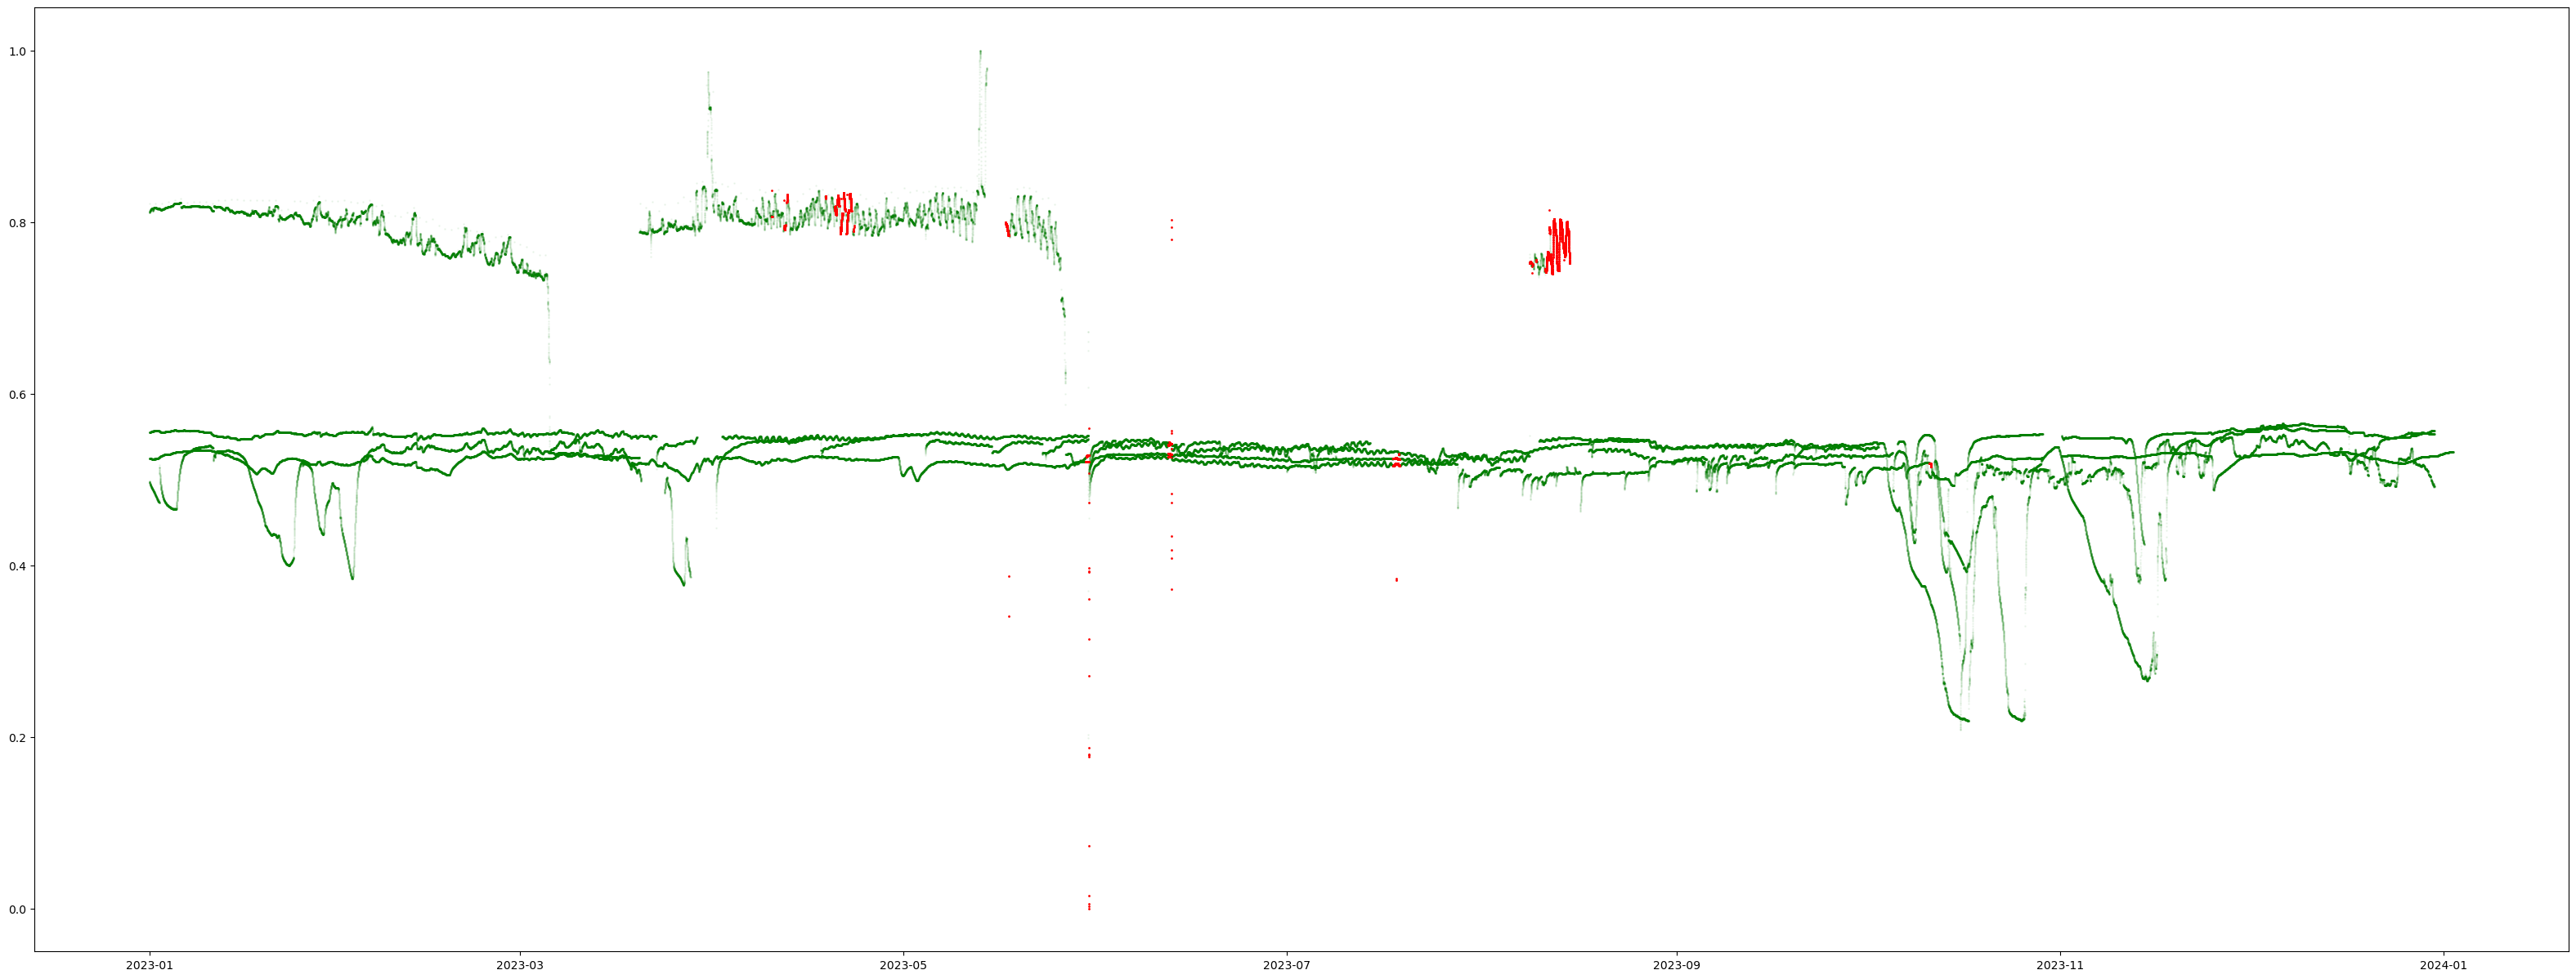

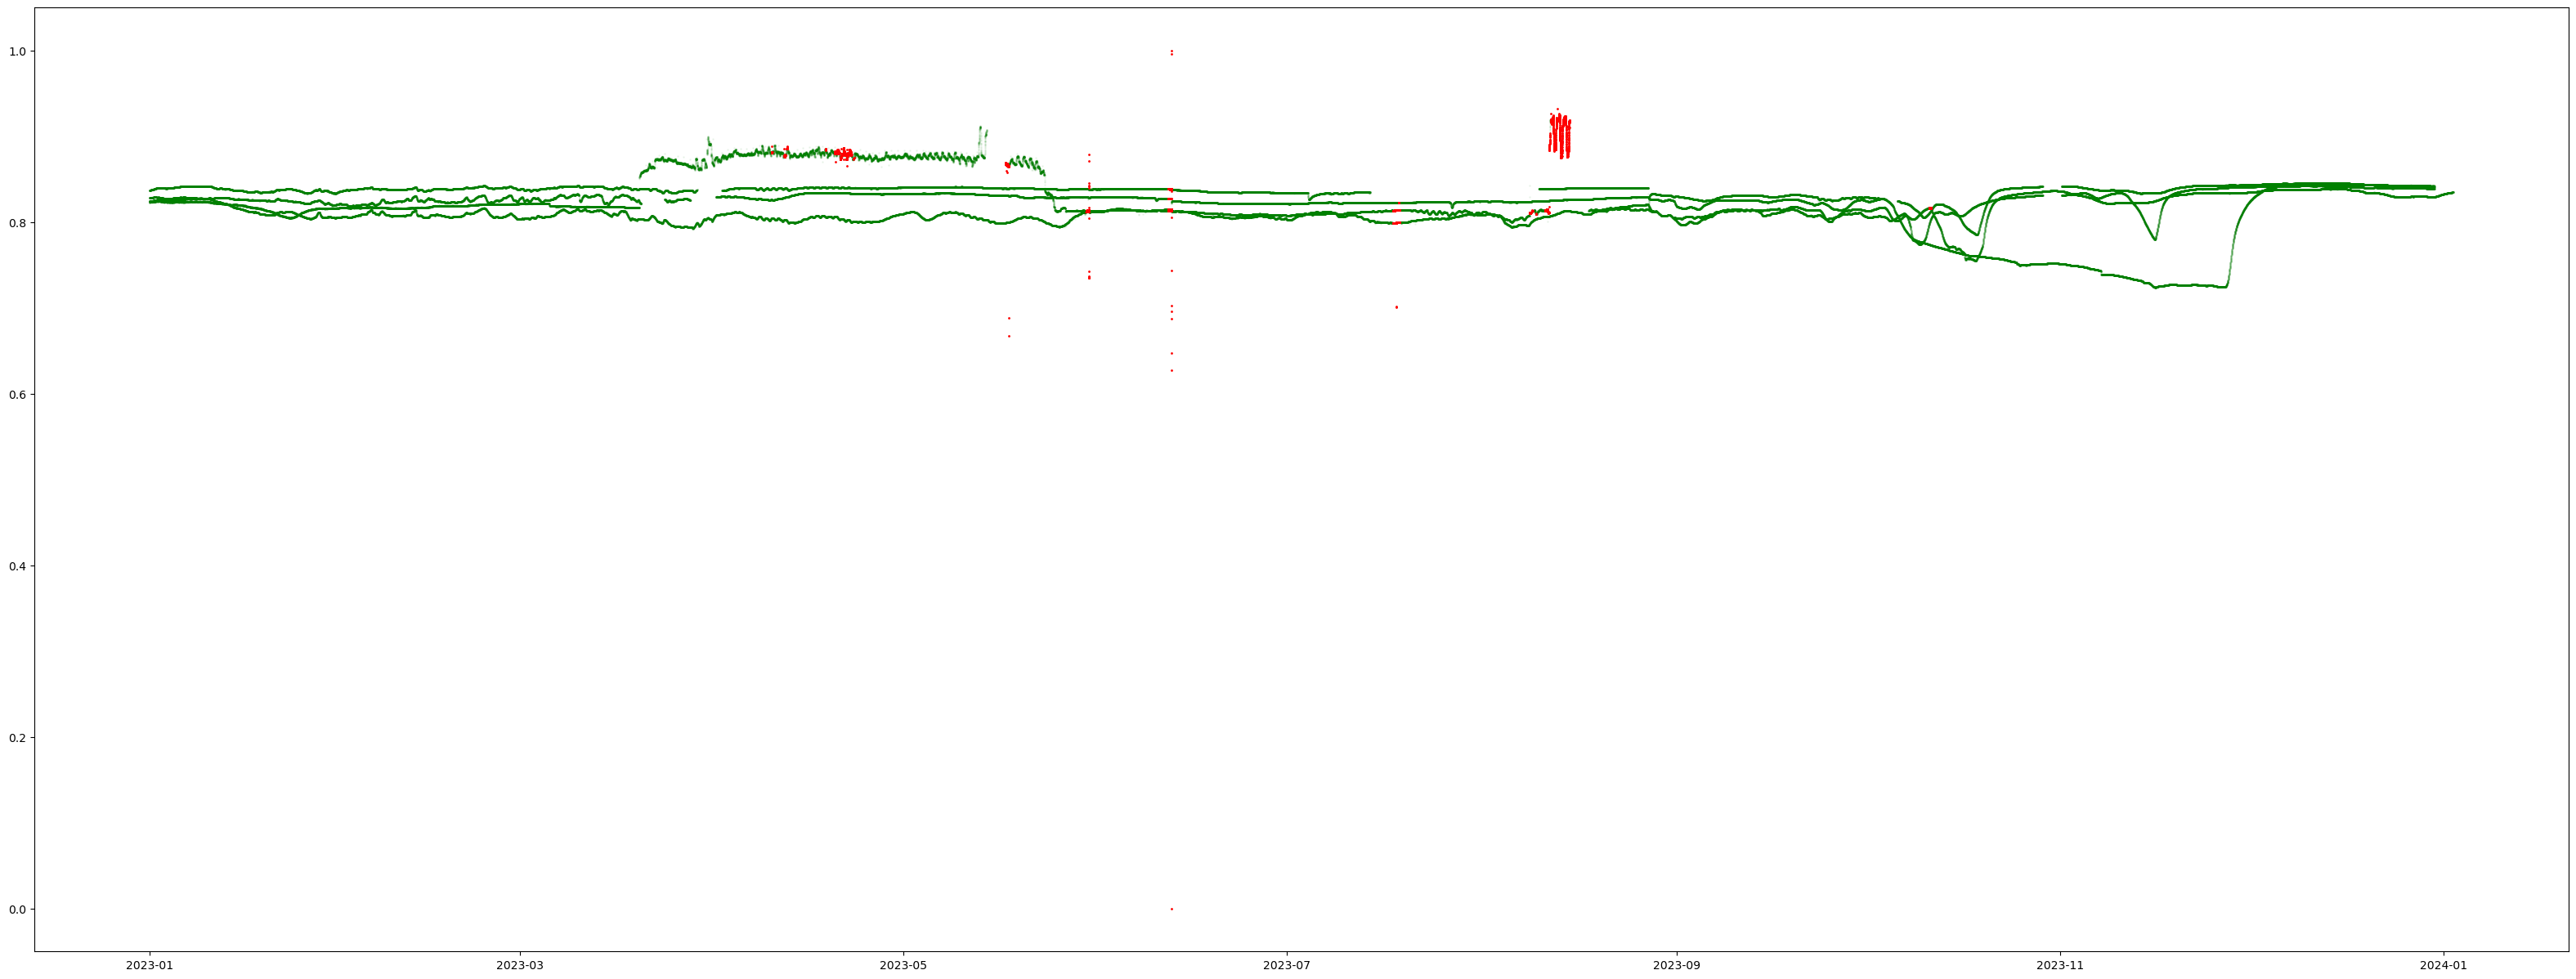

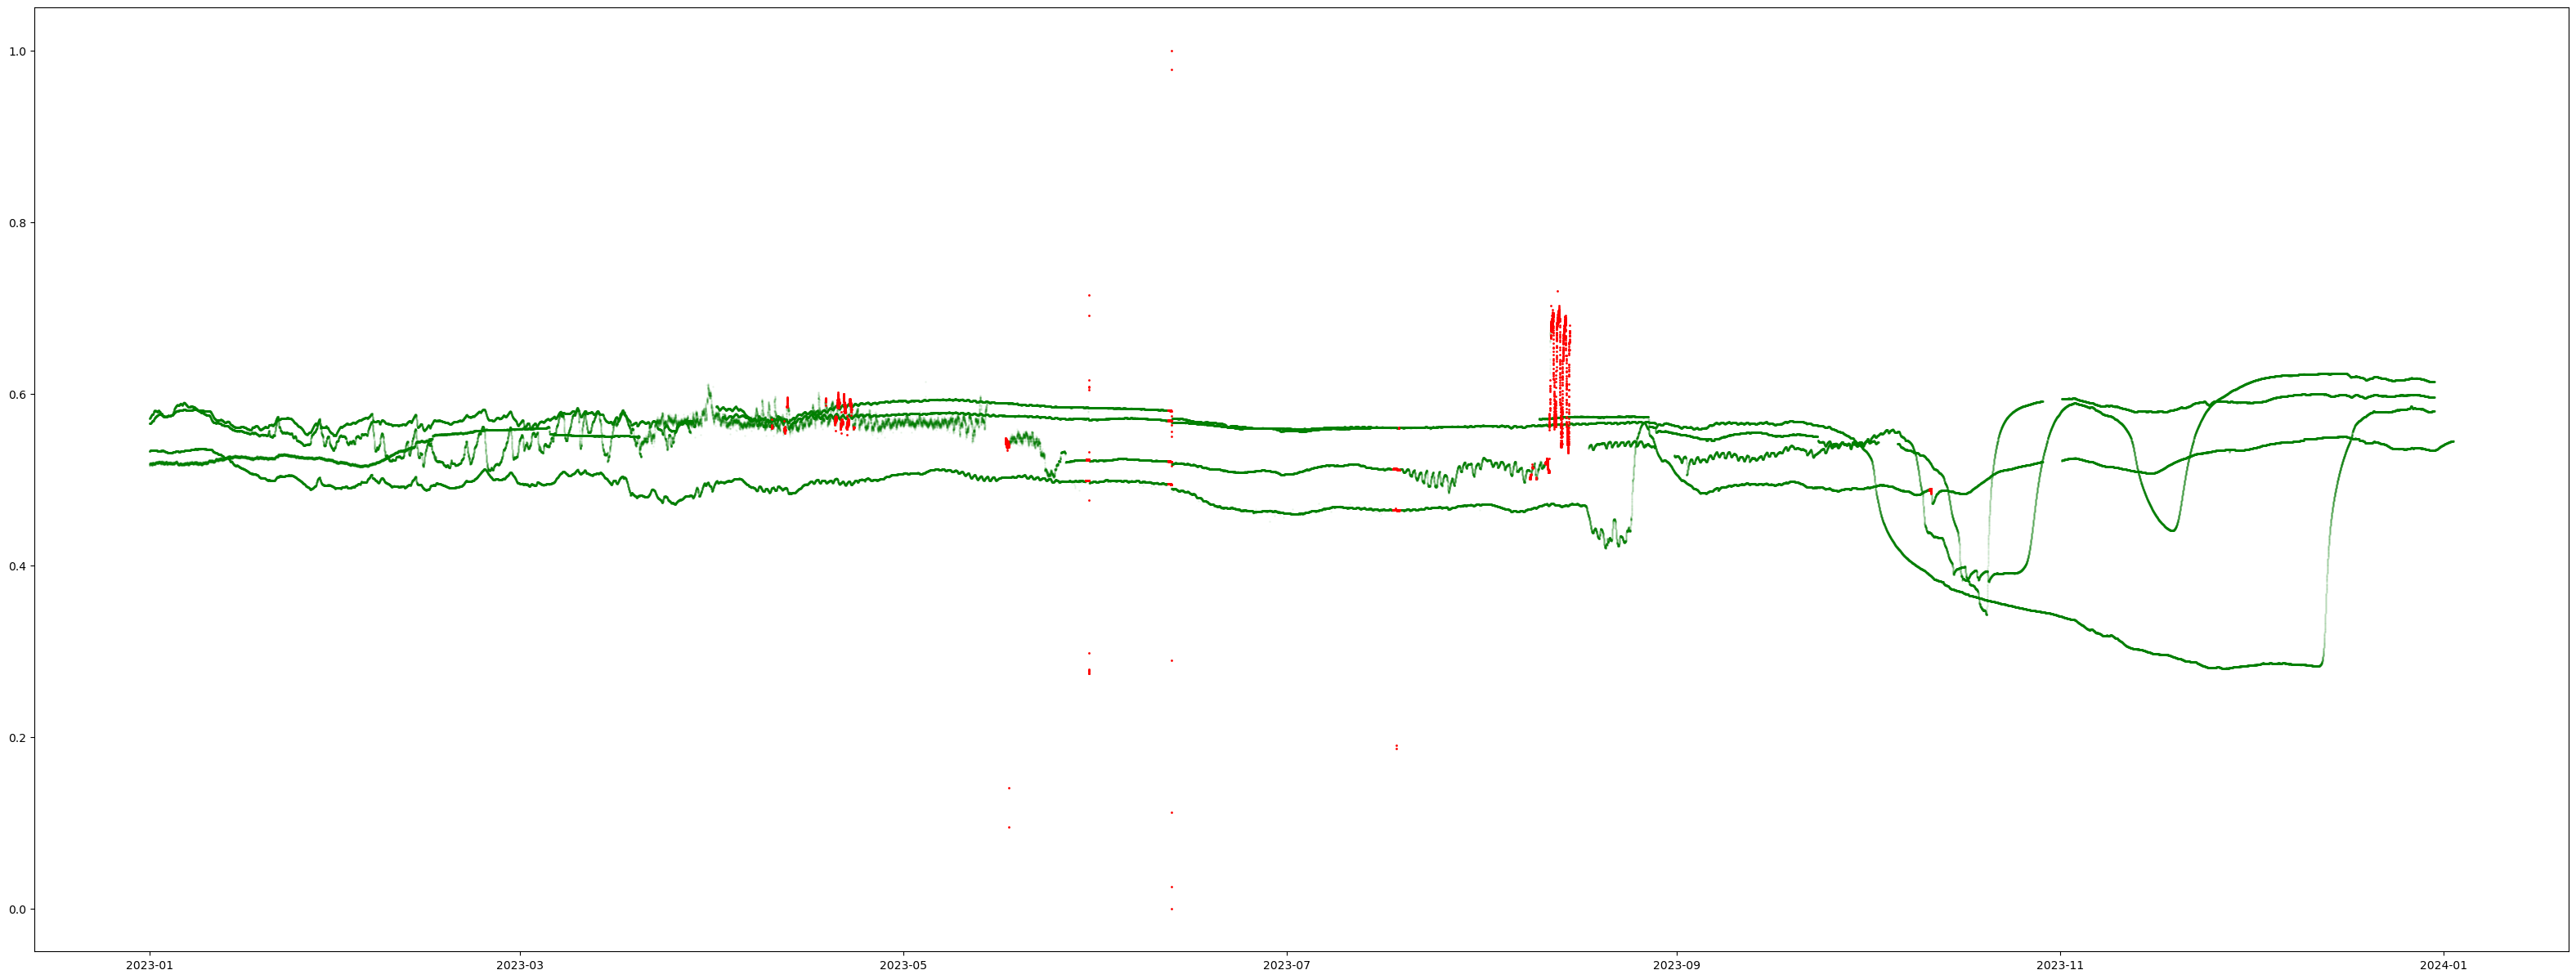

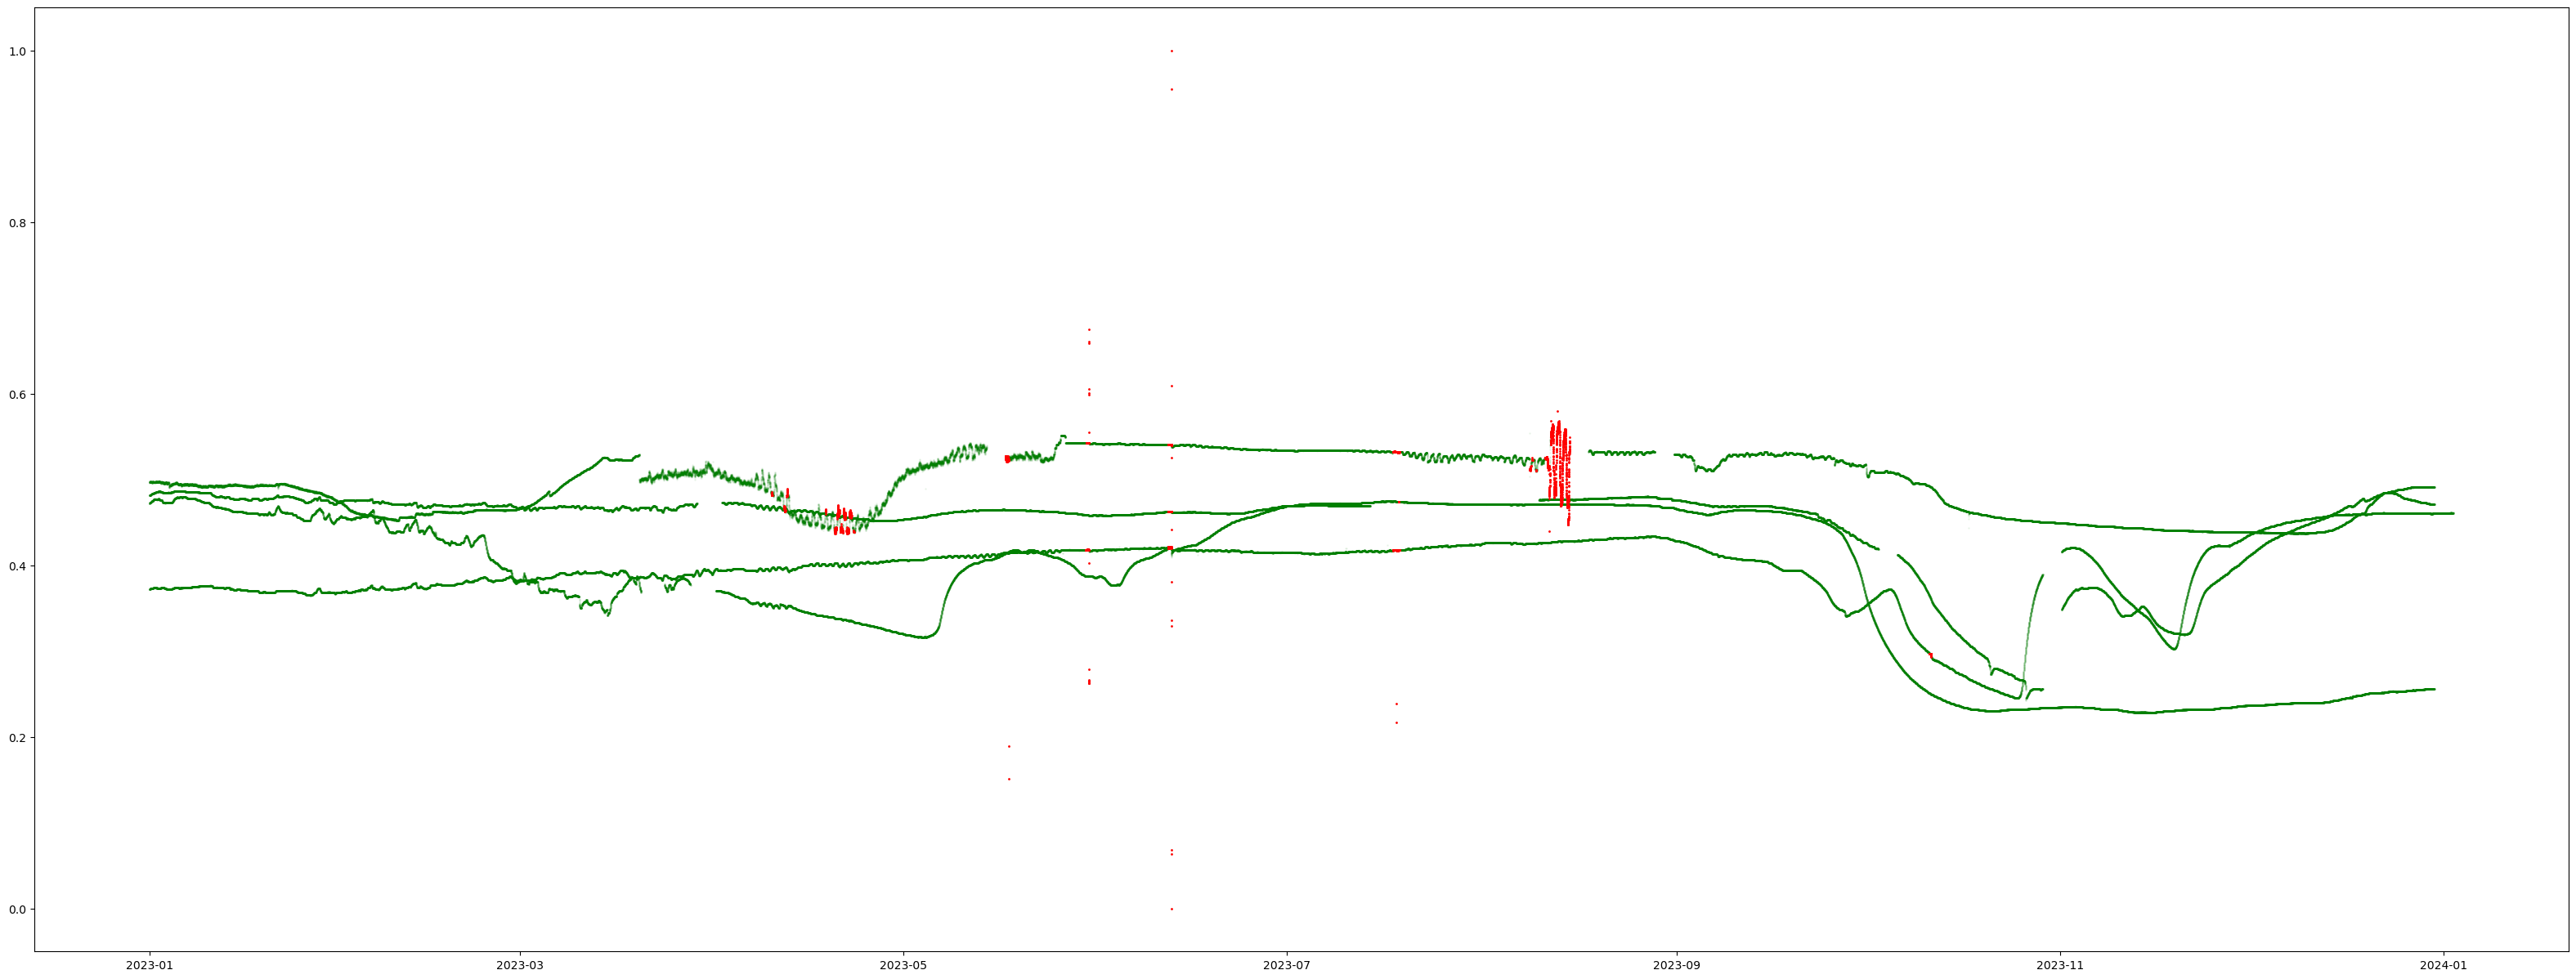

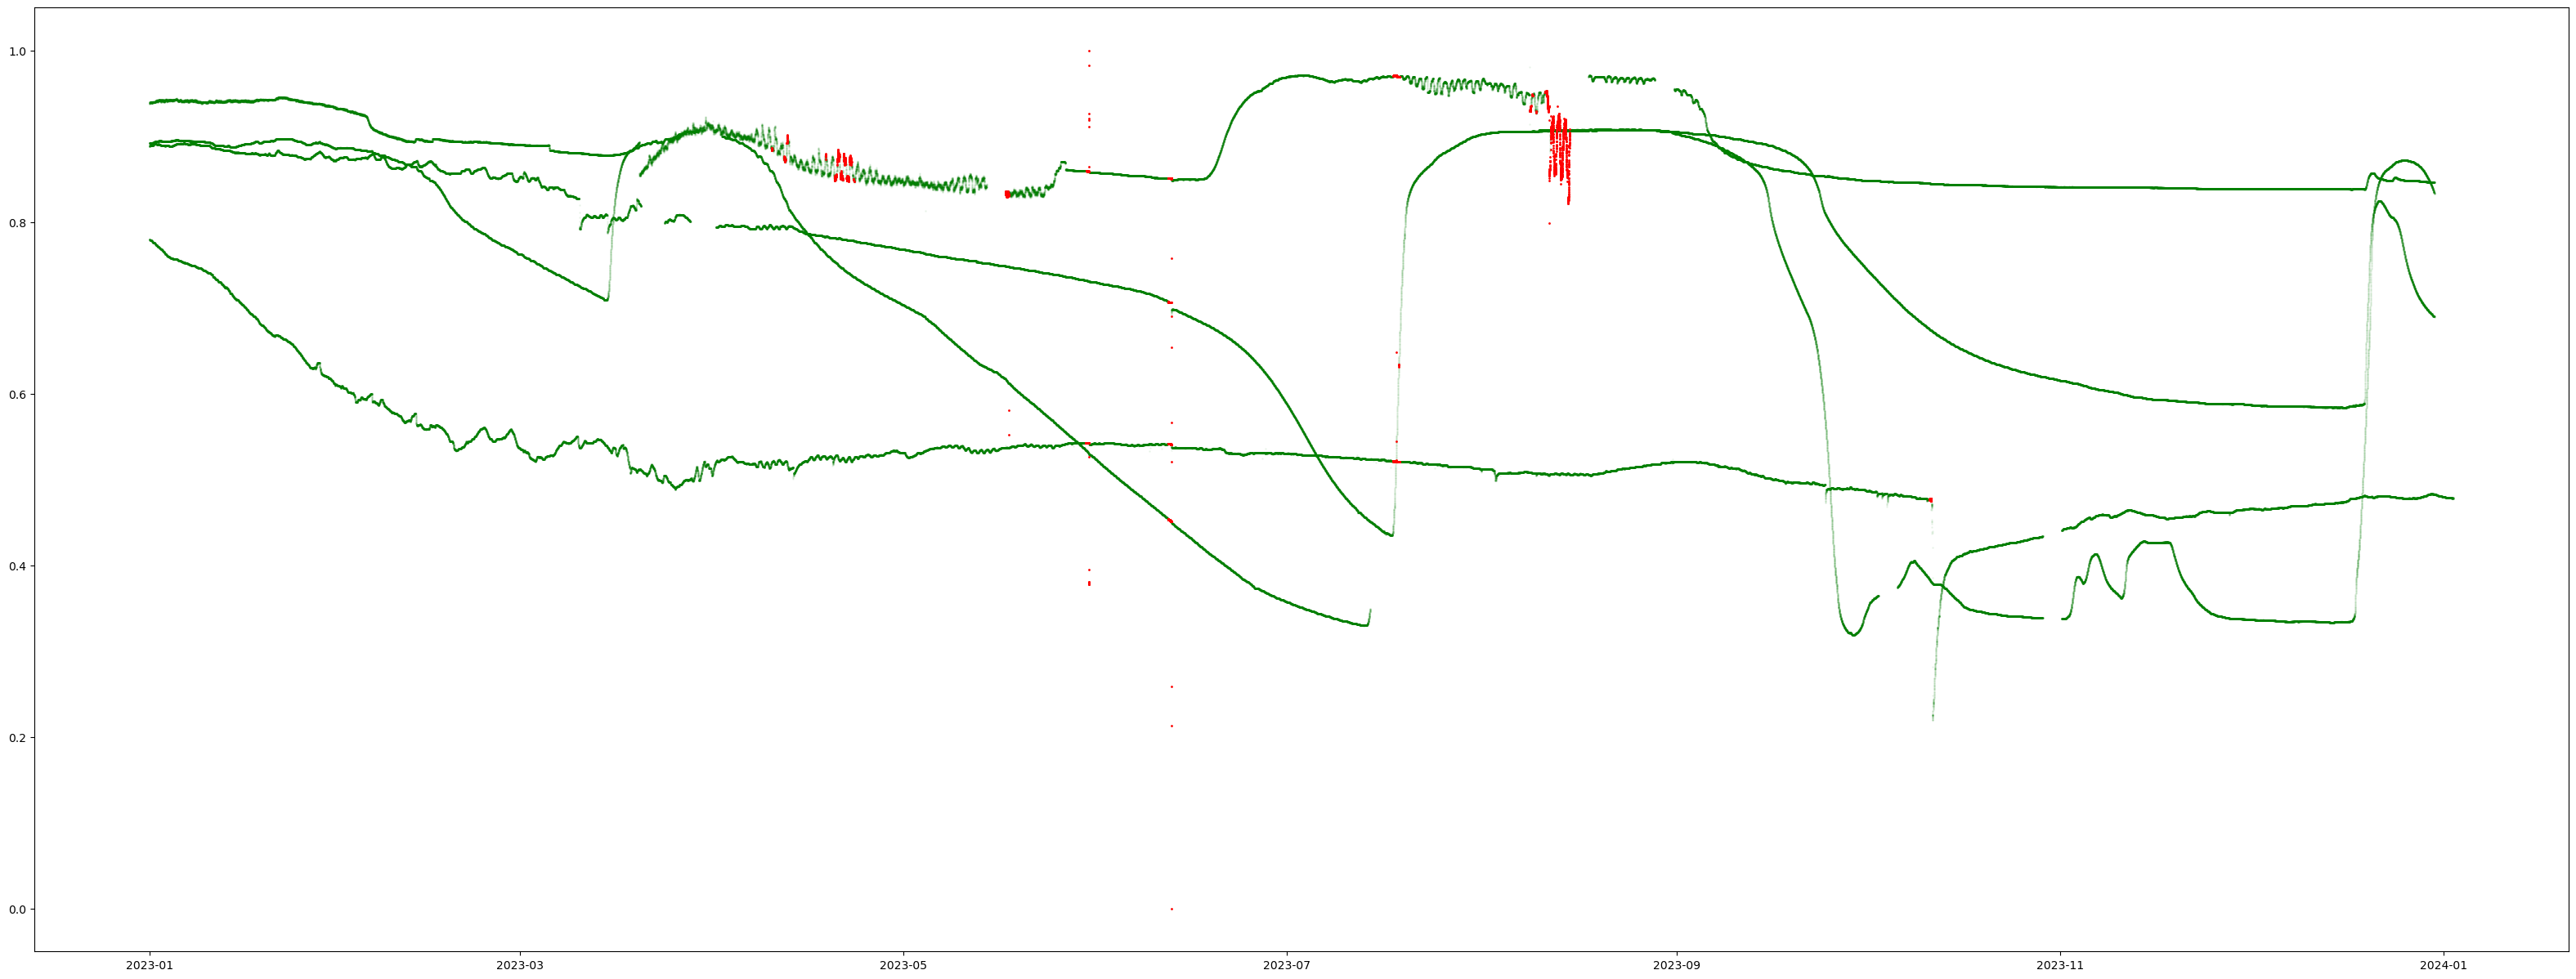

----------------------
calculating 'all-sensors' model for the following parameters: architecture - <class 'Net5.Net5'>, weight = [2.0, 4.0]
----------------------


100%|██████████| 30/30 [01:38<00:00,  3.30s/it]


Number of predicted anomalies for 2023 0


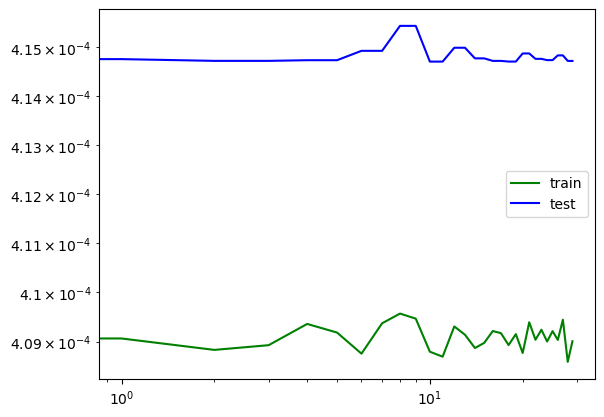

100%|██████████| 30/30 [01:38<00:00,  3.28s/it]


Number of predicted anomalies for 2023 5547


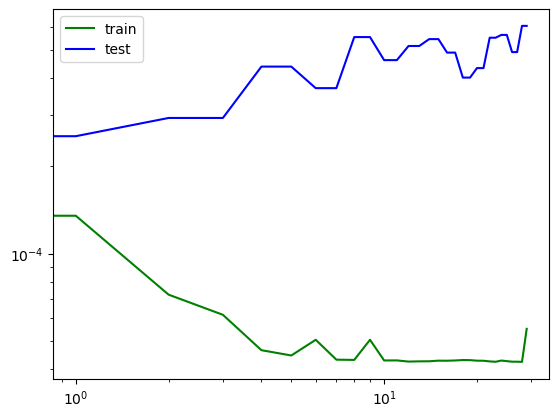

100%|██████████| 30/30 [01:40<00:00,  3.34s/it]


Number of predicted anomalies for 2023 7507


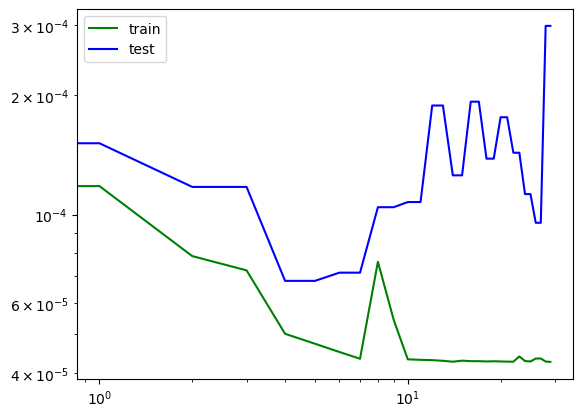

100%|██████████| 30/30 [01:39<00:00,  3.32s/it]


Number of predicted anomalies for 2023 428


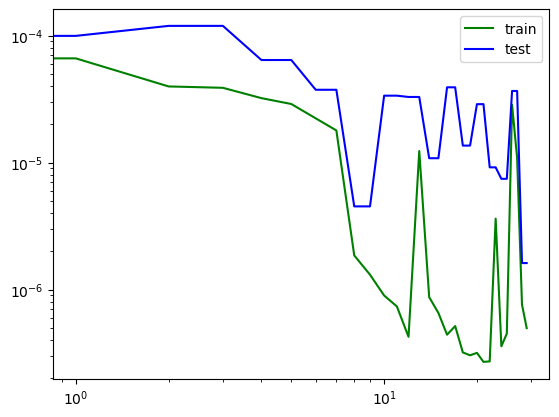

100%|██████████| 30/30 [01:36<00:00,  3.22s/it]


Number of predicted anomalies for 2023 6018


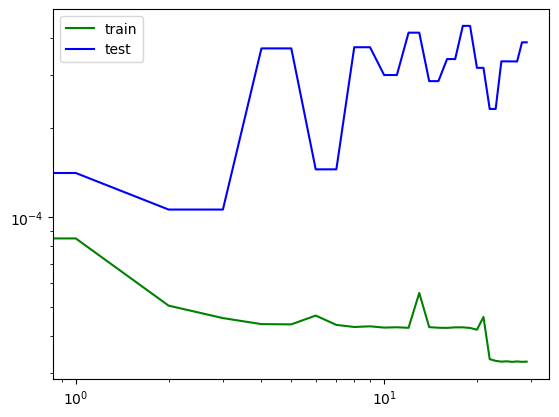

100%|██████████| 30/30 [01:37<00:00,  3.23s/it]


Number of predicted anomalies for 2023 0


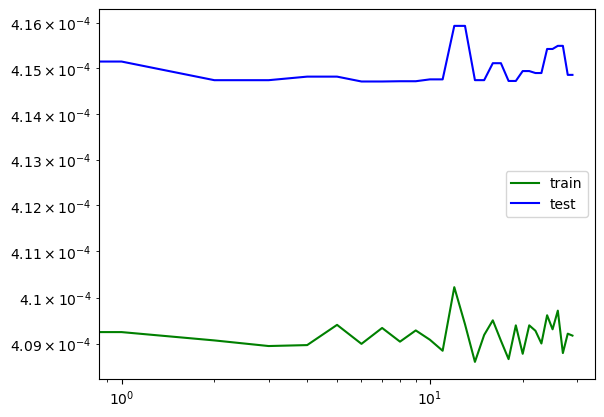

100%|██████████| 30/30 [01:36<00:00,  3.20s/it]


Number of predicted anomalies for 2023 141


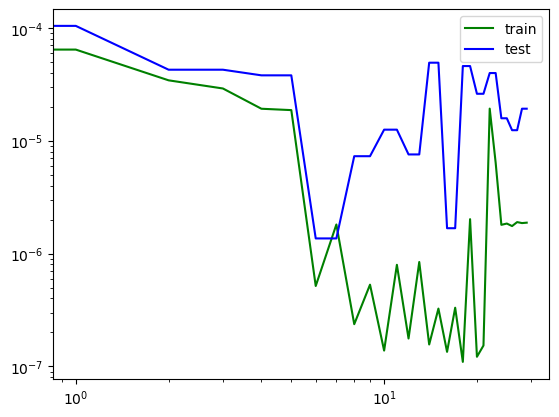

   architecture  weight_normal  weight_anomaly  number_of_units  \
0             5            2.0             4.0                3   
1             5            2.0             4.0                5   
2             5            2.0             4.0                7   
3             5            2.0             4.0                9   
4             5            2.0             4.0               11   
5             5            2.0             4.0               13   
6             5            2.0             4.0               15   

   train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  \
0          4.092813e-04        0.924015      0.000000             0.000415   
1          4.550770e-05        0.986328      0.999182             0.000478   
2          4.270189e-05        0.986949      0.999864             0.000331   
3          3.550742e-07        0.999969      0.999864             0.000002   
4          3.289190e-05        0.990885      0.999864             0.00035

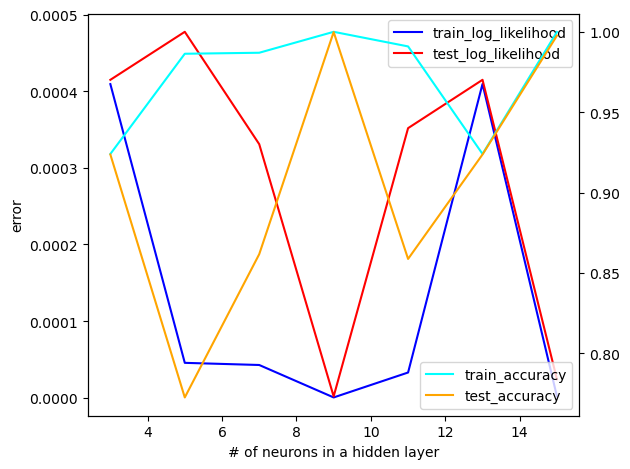

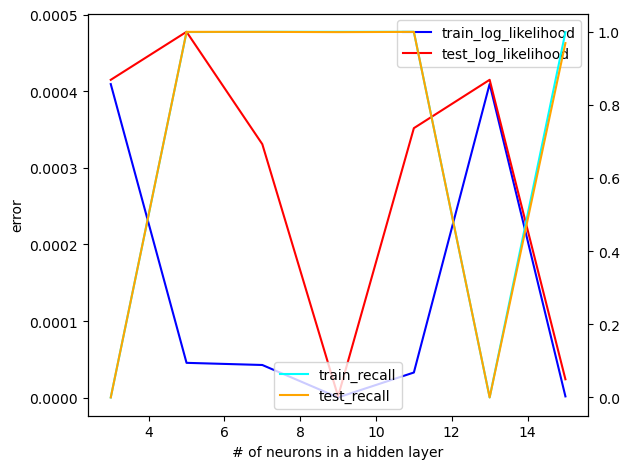

optimal value of the number of units per layer is 5


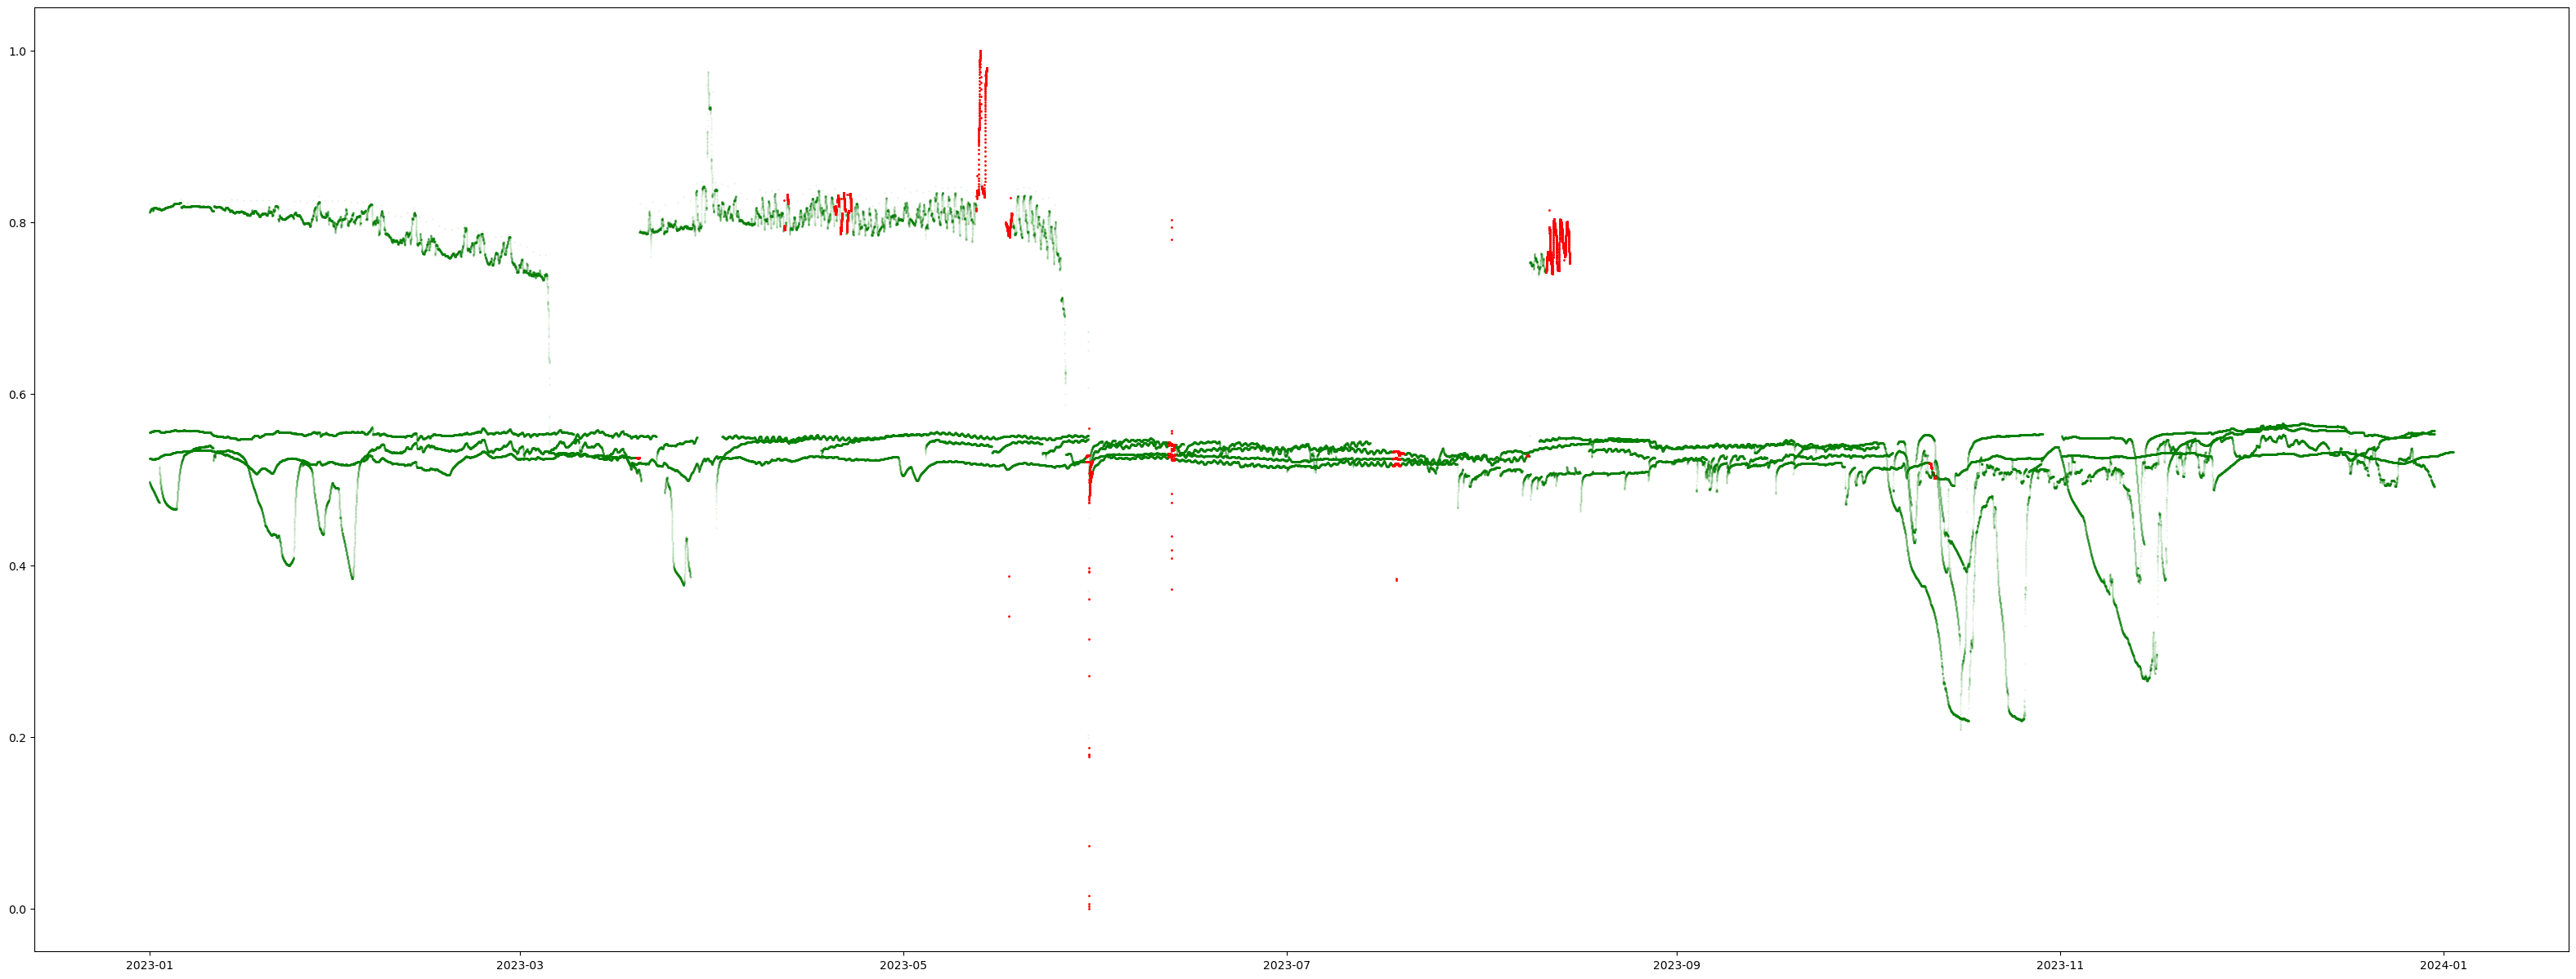

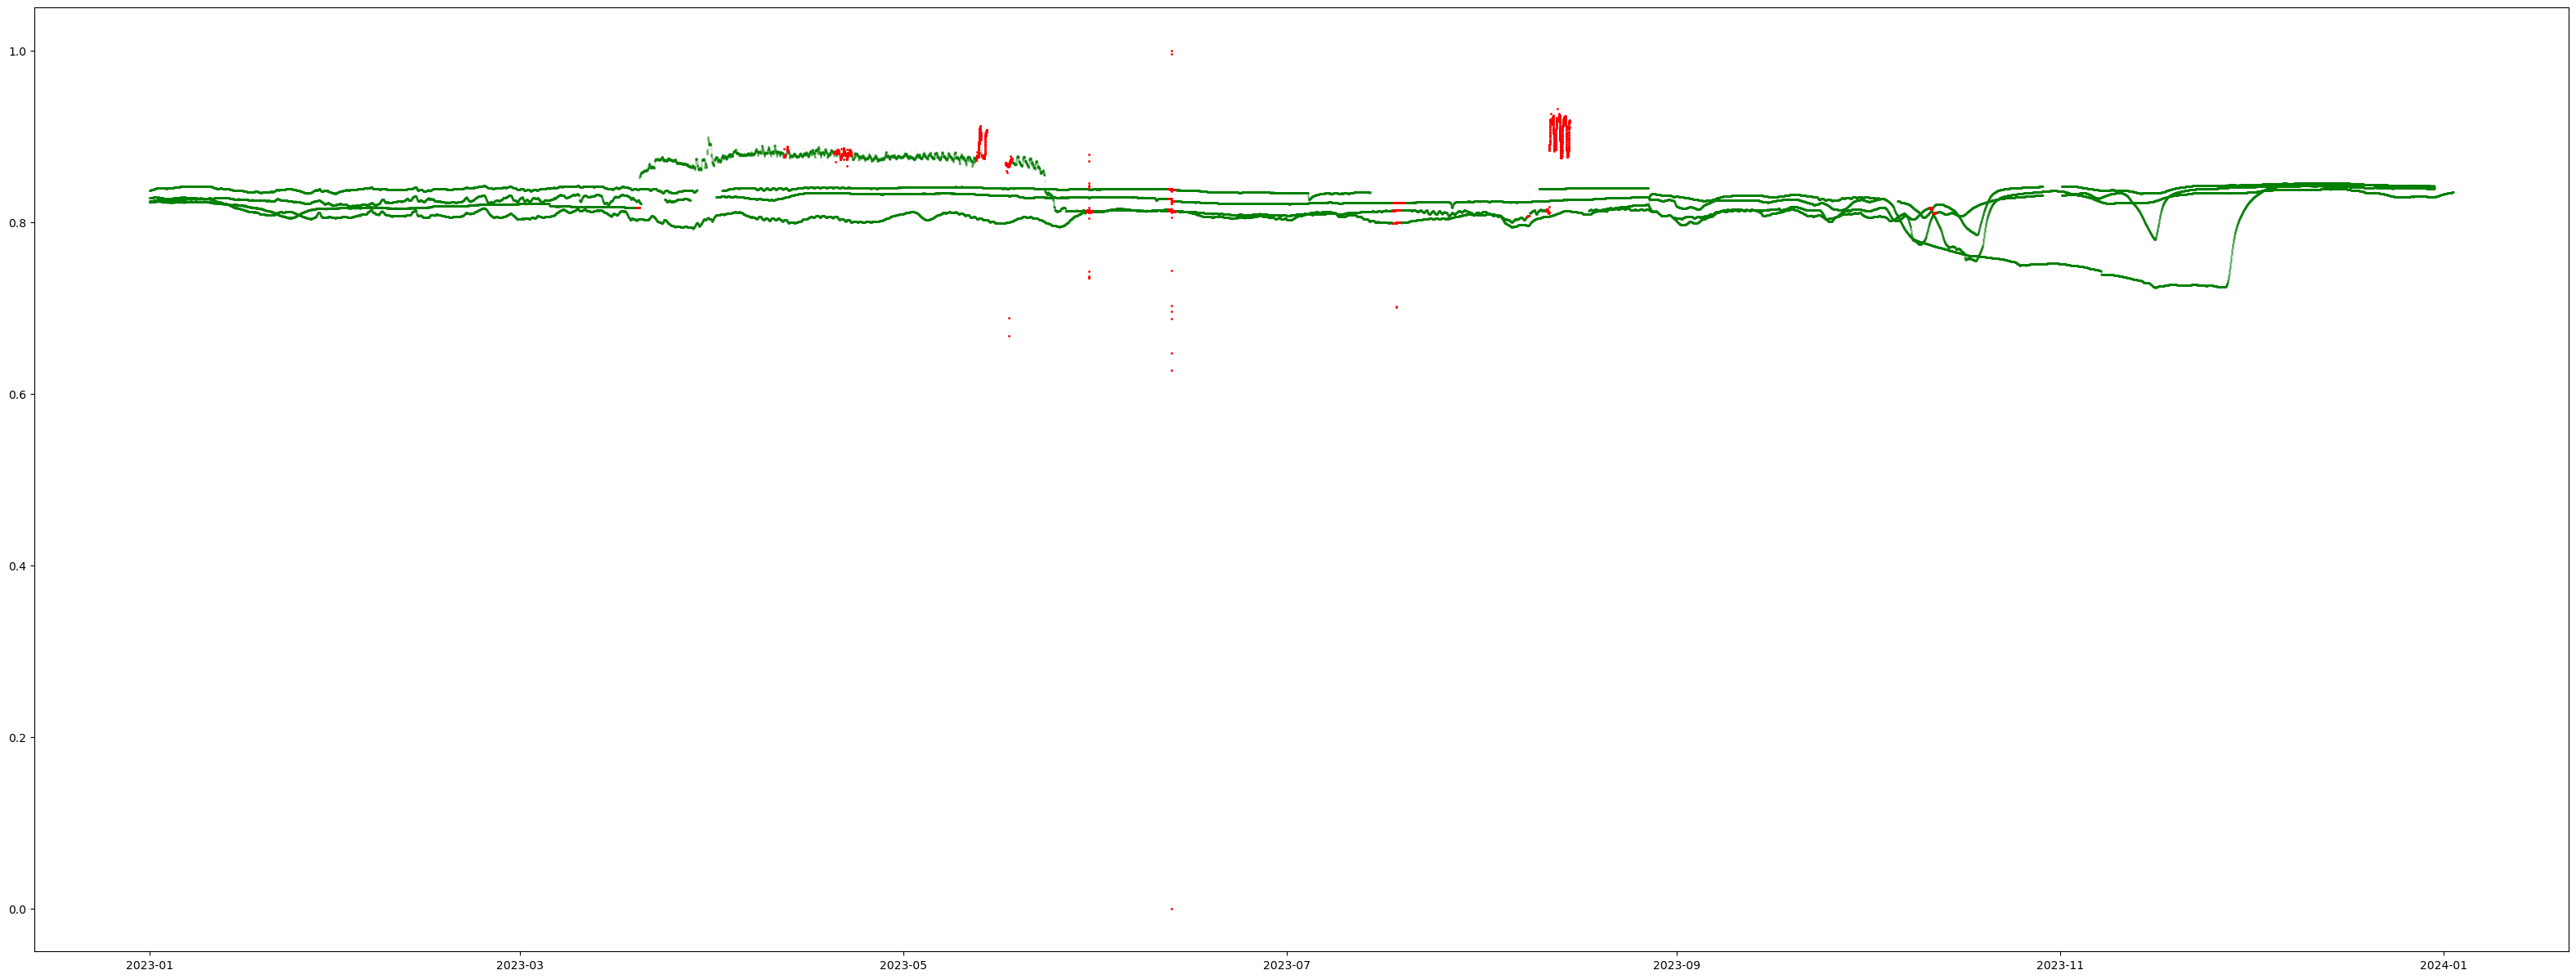

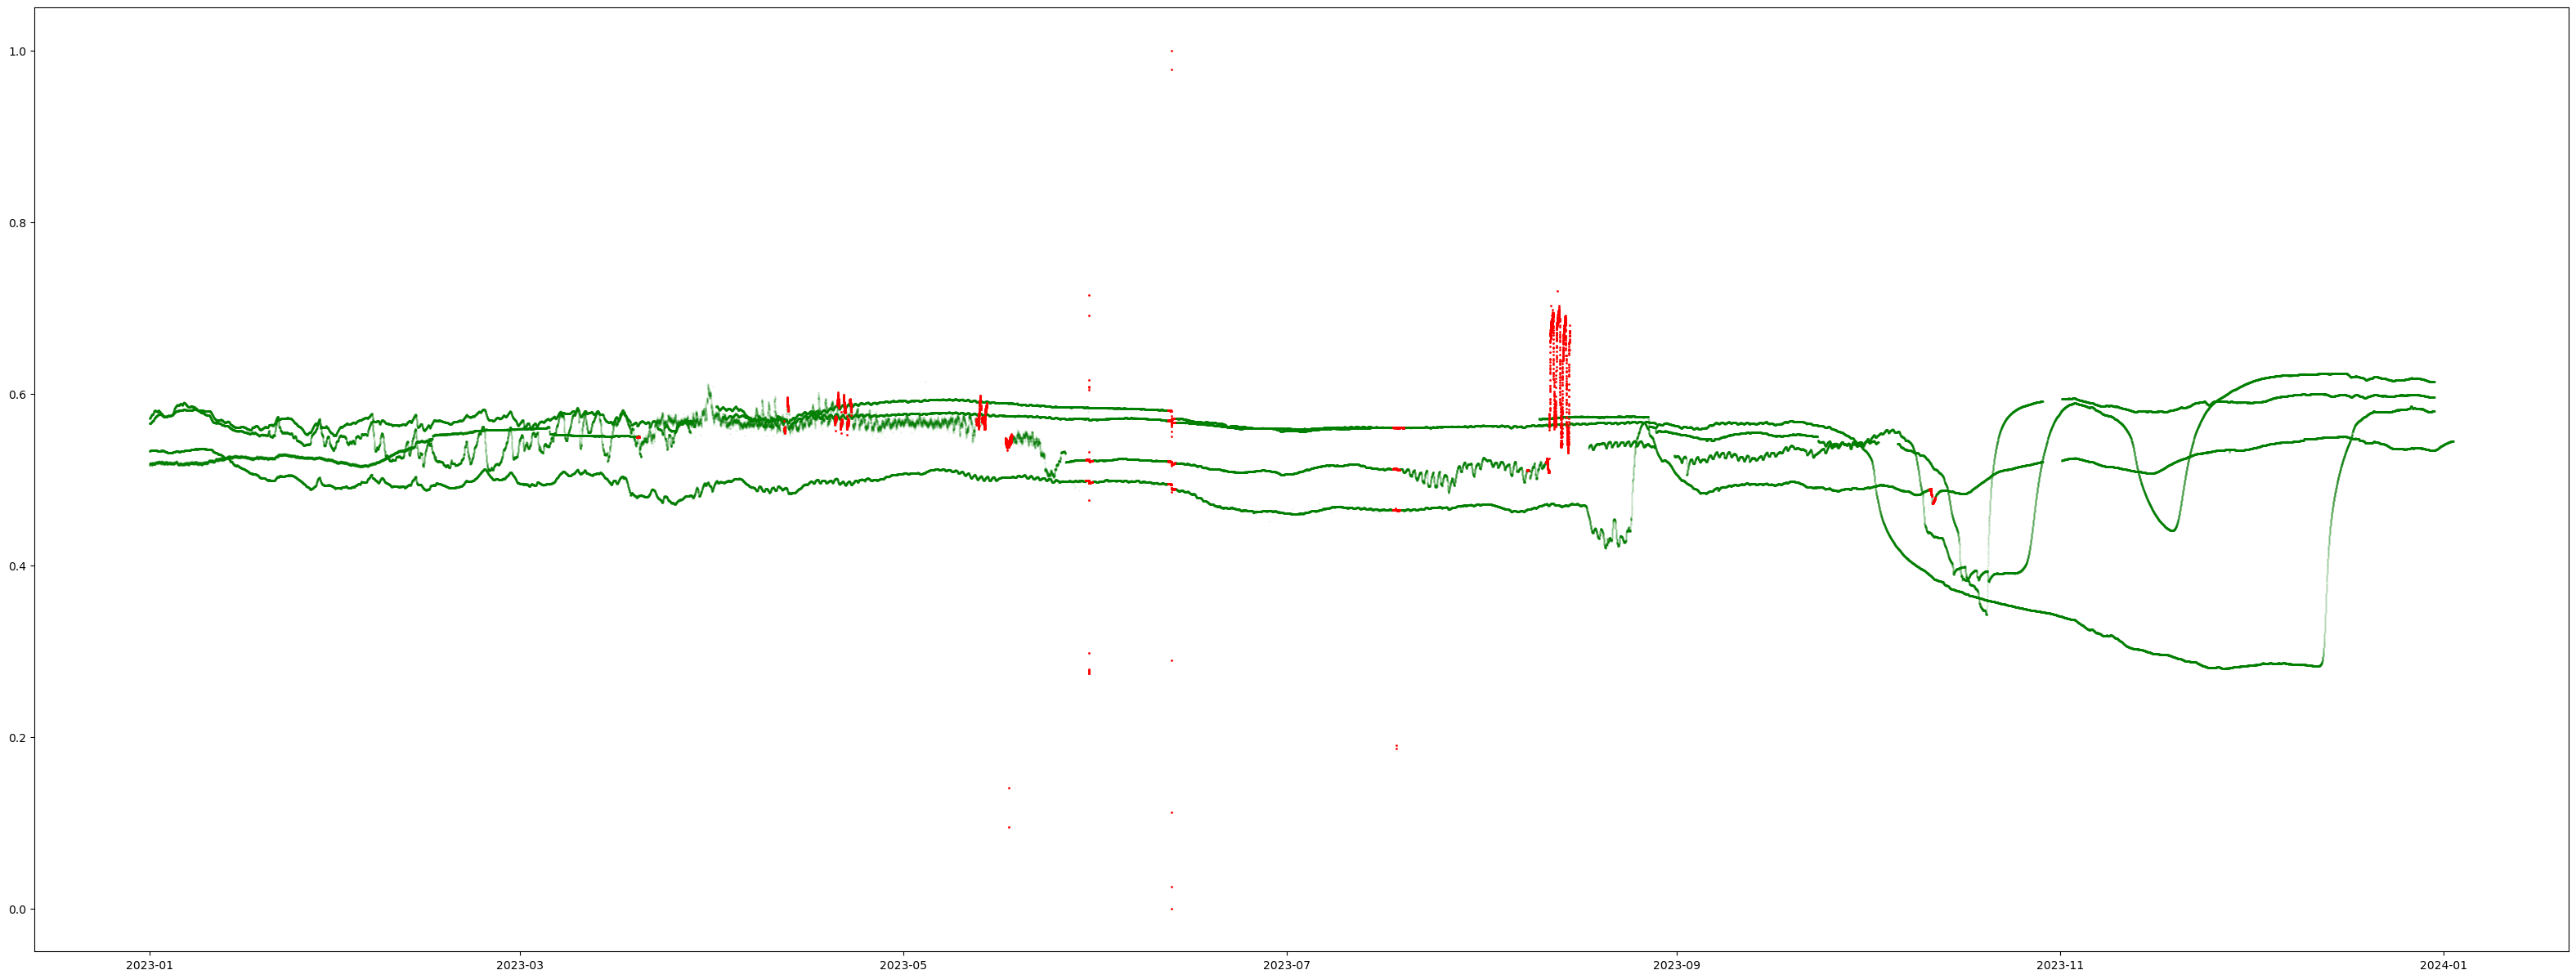

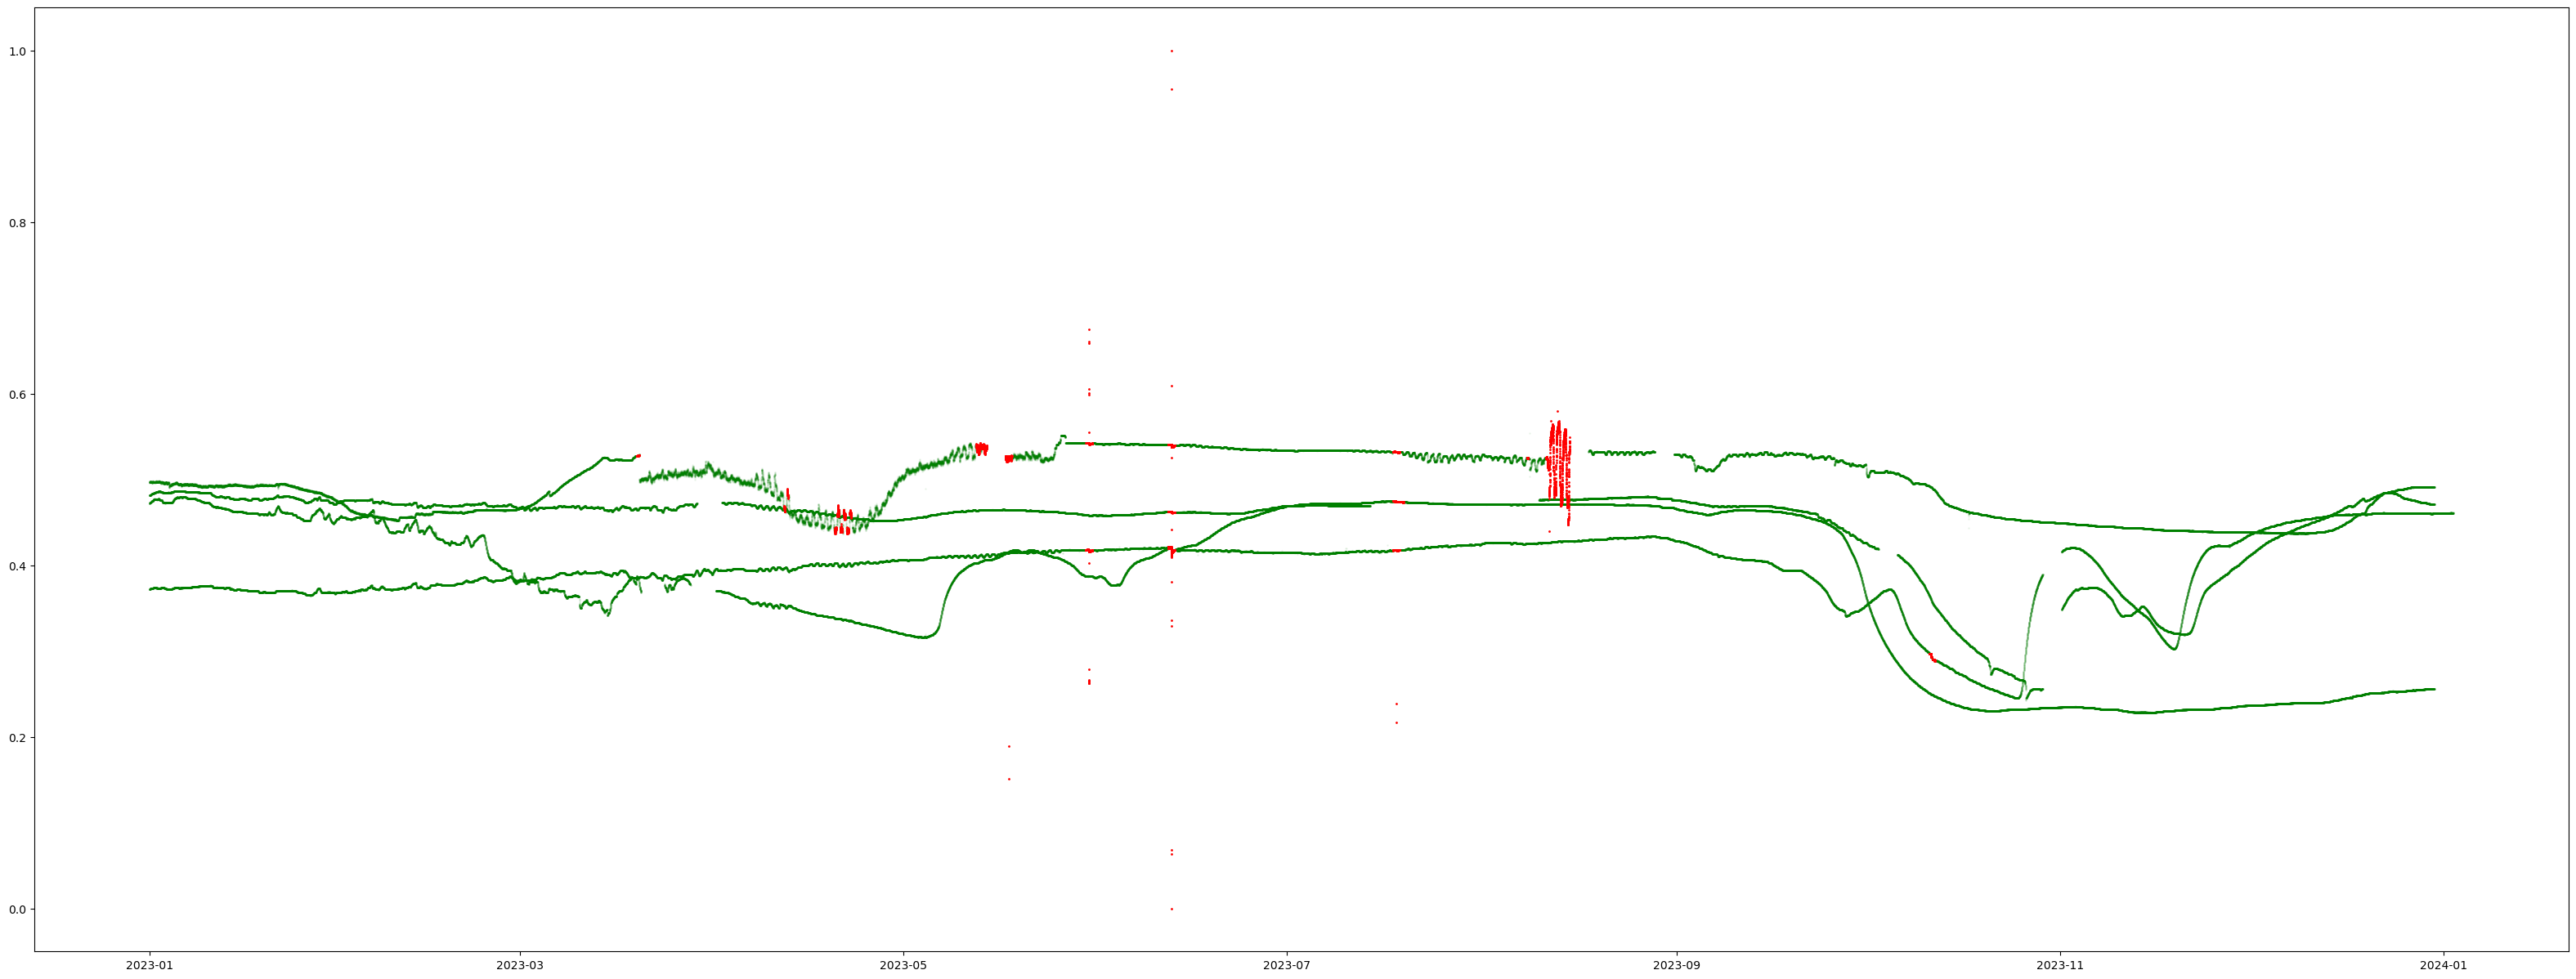

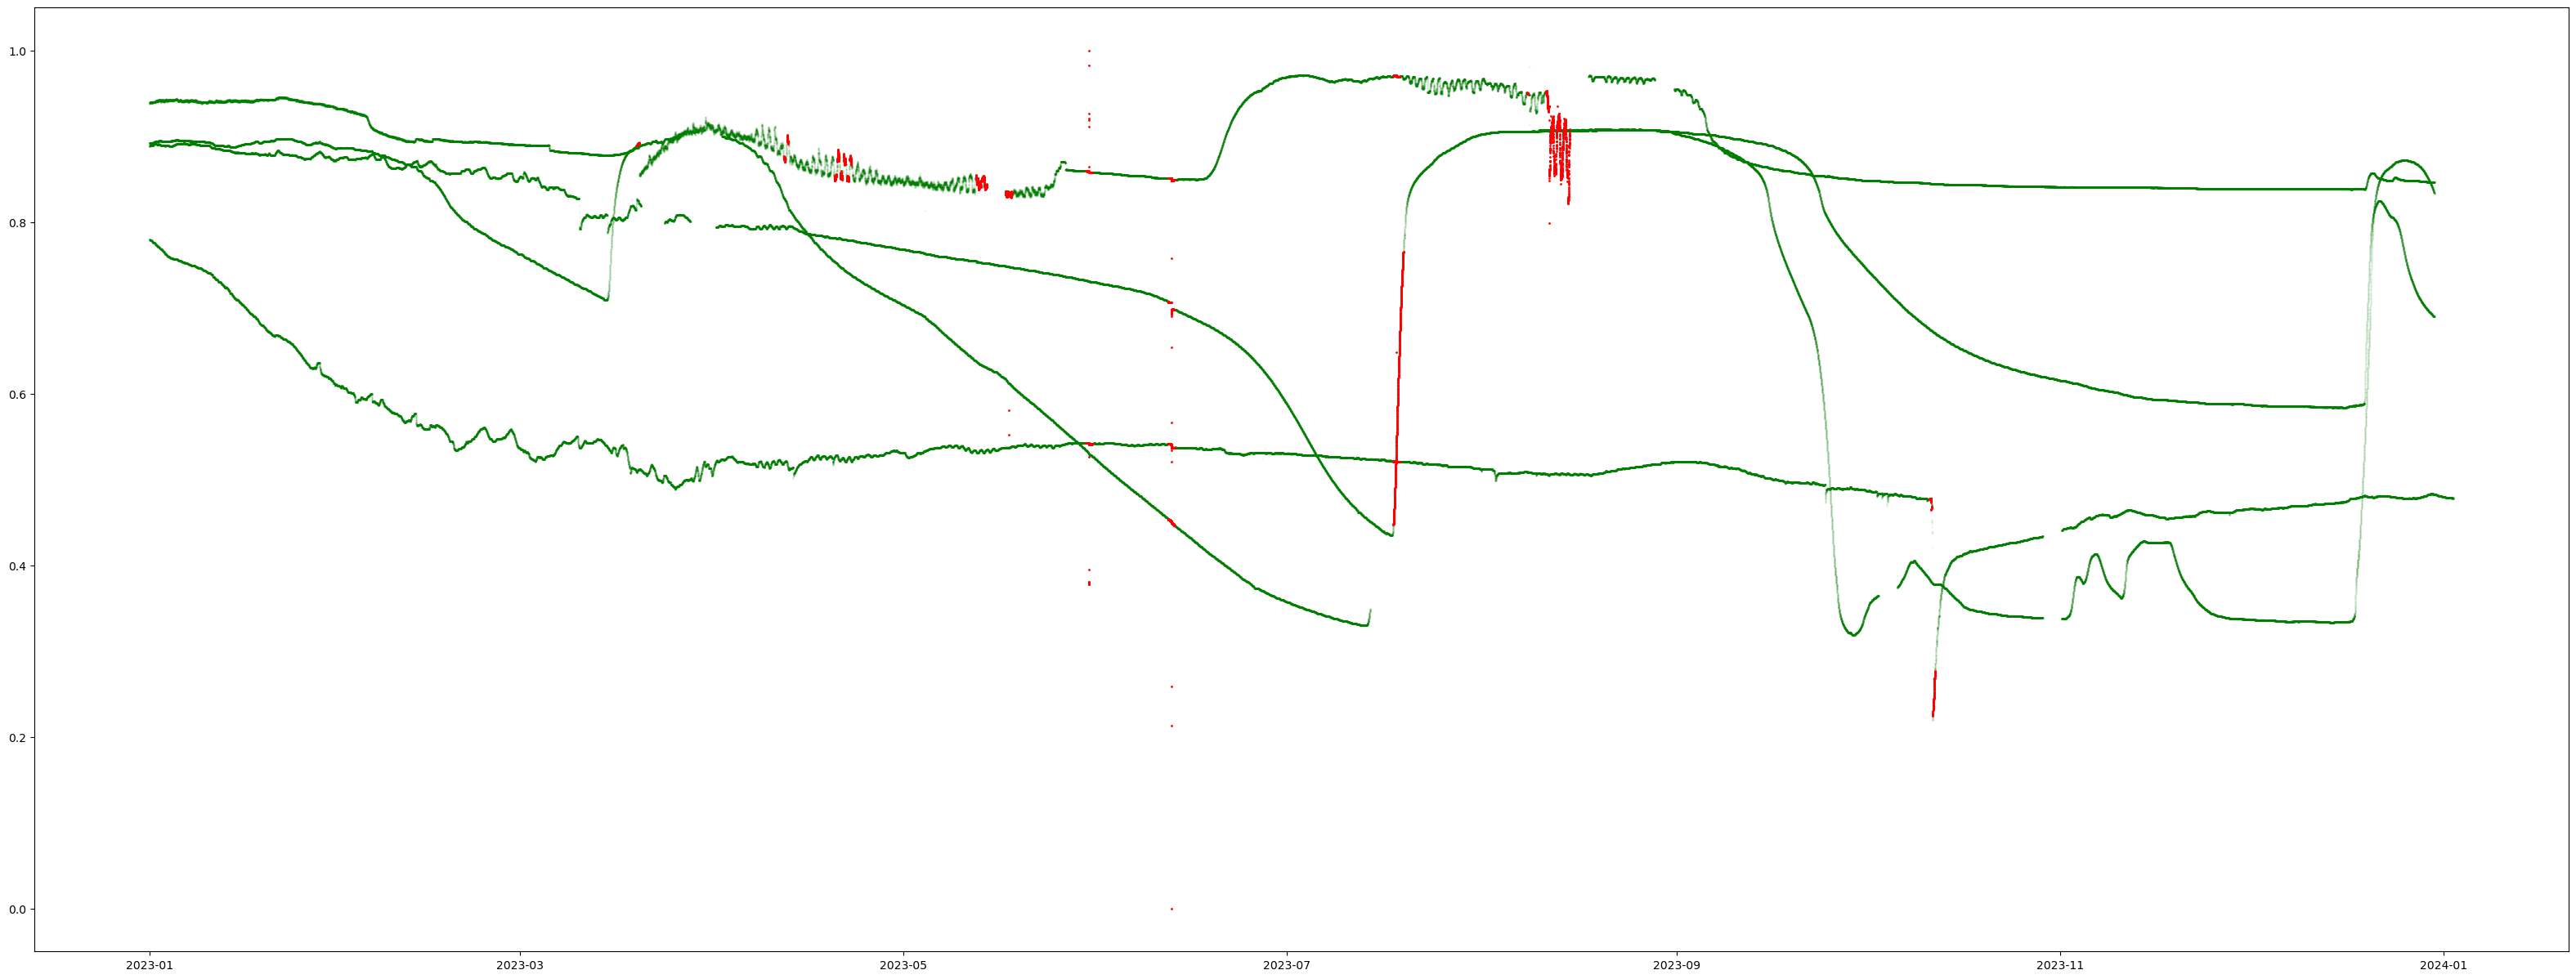

In [149]:
for i, parameters in enumerate(parameters_options):
        
        architecture = parameters[0]
        weight = parameters[1]

        print("----------------------")
        print(f"calculating 'all-sensors' model for the following parameters: architecture - {architecture}, weight = {weight}")
        print("----------------------")

        models, train_test_errors_df = model_comparison(Ms = Ms_all_sensors, lr = learning_rate_all_sensors, plotting_graphs = True, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.SGD, architecture = architecture, weight = weight, epochs = epochs_all_sensors)
        
        if i == 0:
                all_sensor_train_test_results_final_table_df = train_test_errors_df
        else:
                all_sensor_train_test_results_final_table_df = pd.concat([all_sensor_train_test_results_final_table_df, train_test_errors_df], axis = 0)
        
        # df_storing(train_test_errors_df, sensor, optimizer = "Adam", lr = learning_rate, architecture = architecture, weight = weight)

        models_all_sensors_dict[(architecture, weight[0], weight[1])] = models

        print(train_test_errors_df)

        comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_accuracy"], train_test_errors_df["test_accuracy"], "log_likelihood", "accuracy")
        comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_recall"], train_test_errors_df["test_recall"], "log_likelihood", "recall")

        M_opt = train_test_errors_df.loc[np.argmax(train_test_errors_df["test_recall"]), "number_of_units"].squeeze() 
        model_opt = models[M_opt]
        predicted = model_opt.predictions
        
        print(f"optimal value of the number of units per layer is {M_opt}")
        plot_predicted_2023(predicted, test_scaled_2023, sensor = None)

In [88]:
'''
models, train_test_errors_df = model_comparison(Ms = [3, 4, 5, 7, 9, 11, 13, 15], lr = 0.001, plotting_graphs = True, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.SGD, epochs = 2)

print(train_test_errors_df)

comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_accuracy"], train_test_errors_df["test_accuracy"], "log_likelihood", "accuracy")
comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_recall"], train_test_errors_df["test_recall"], "log_likelihood", "recall")

M_opt = train_test_errors_df.loc[np.argmax(train_test_errors_df["test_recall"]), "number_of_units"].squeeze() 

model_opt = models[M_opt]
predicted = model_opt.predictions 
print(f"optimal value of the number of units per layer is {M_opt}")

plot_predicted_2023(predicted, test_scaled_2023, sensor = None)
'''

'\nmodels, train_test_errors_df = model_comparison(Ms = [3, 4, 5, 7, 9, 11, 13, 15], lr = 0.001, plotting_graphs = True, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.SGD, epochs = 2)\n\nprint(train_test_errors_df)\n\ncomparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_accuracy"], train_test_errors_df["test_accuracy"], "log_likelihood", "accuracy")\ncomparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_recall"], train_test_errors_df["test_recall"], "log_likelihood", "recall")\n\nM_opt = train_test_errors_df.loc[np.argmax(train_test_errors_df["test_recall"]), "number_of_units"].squeeze() \n\nmodel_opt = models[M_opt]\npredicted = model_opt.predictions \nprint(f"optimal value of the number of units per layer is

In [150]:
all_sensor_train_test_results_final_table_df.reset_index()

index  architecture  weight_normal  weight_anomaly  number_of_units  \
0       0             3            2.0             2.0                3   
1       1             3            2.0             2.0                5   
2       2             3            2.0             2.0                7   
3       3             3            2.0             2.0                9   
4       4             3            2.0             2.0               11   
5       5             3            2.0             2.0               13   
6       6             3            2.0             2.0               15   
7       0             3            2.0             4.0                3   
8       1             3            2.0             4.0                5   
9       2             3            2.0             4.0                7   
10      3             3            2.0             4.0                9   
11      4             3            2.0             4.0               11   
12      5             3            2.0             4.0               13   
13      6             3            2.0             4.0               15   
14      0             5            2.0             2.0                3   
15      1             5            2.0             2.0                5   
16      2             5            2.0             2.0                7   
17      3             5            2.0             2.0                9   
18      4             5            2.0             2.0               11   
19      5             5            2.0             2.0               13   
20      6             5            2.0             2.0               15   
21      0             5            2.0             4.0                3   
22      1             5            2.0             4.0                5   
23      2             5            2.0             4.0                7   
24      3             5            2.0             4.0                9   
25      4             5            2.0             4.0               11   
26      5             5            2.0             4.0               13   
27      6             5            2.0             4.0               15   

    train_log_likelihood  train_accuracy  train_recall  test_log_likelihood  \
0           2.315954e-05        0.993412      0.999727         2.763904e-05   
1           2.701620e-04        0.924015      0.000000         2.742177e-04   
2           2.172878e-06        0.999648      0.998501         1.617238e-04   
3           1.320525e-06        0.999782      0.997137         3.874578e-05   
4           7.098957e-07        0.999917      0.999046         1.914633e-06   
5           2.519990e-07        0.999959      0.999591         1.042005e-05   
6           3.586729e-07        0.999834      1.000000         7.709906e-07   
7           4.088223e-04        0.924015      0.000000         4.147159e-04   
8           2.245791e-07        0.999959      0.999727         3.276381e-05   
9           1.983060e-05        0.993381      0.985414         3.739528e-04   
10          3.947287e-07        0.999948      0.999455         4.900496e-06   
11          1.432757e-07        0.999979      0.999864         1.763590e-05   
12          1.201567e-05        0.997701      0.994275         1.124283e-05   
13          4.379057e-07        0.999948      0.999455         1.553219e-05   
14          2.701763e-04        0.924015      0.000000         2.742050e-04   
15          2.568335e-05        0.992366      0.999727         1.445877e-04   
16          2.699180e-04        0.924015      0.000000         2.742085e-04   
17          2.701578e-04        0.924015      0.000000         2.742014e-04   
18          2.704878e-04        0.924015      0.000000         2.742947e-04   
19          2.357881e-05        0.993091      0.999864         1.750632e-04   
20          8.216383e-06        0.999078      0.993593         3.518615e-05   
21          4.092813e-04        0.924015      0.000000         4.148606e-04   
22         

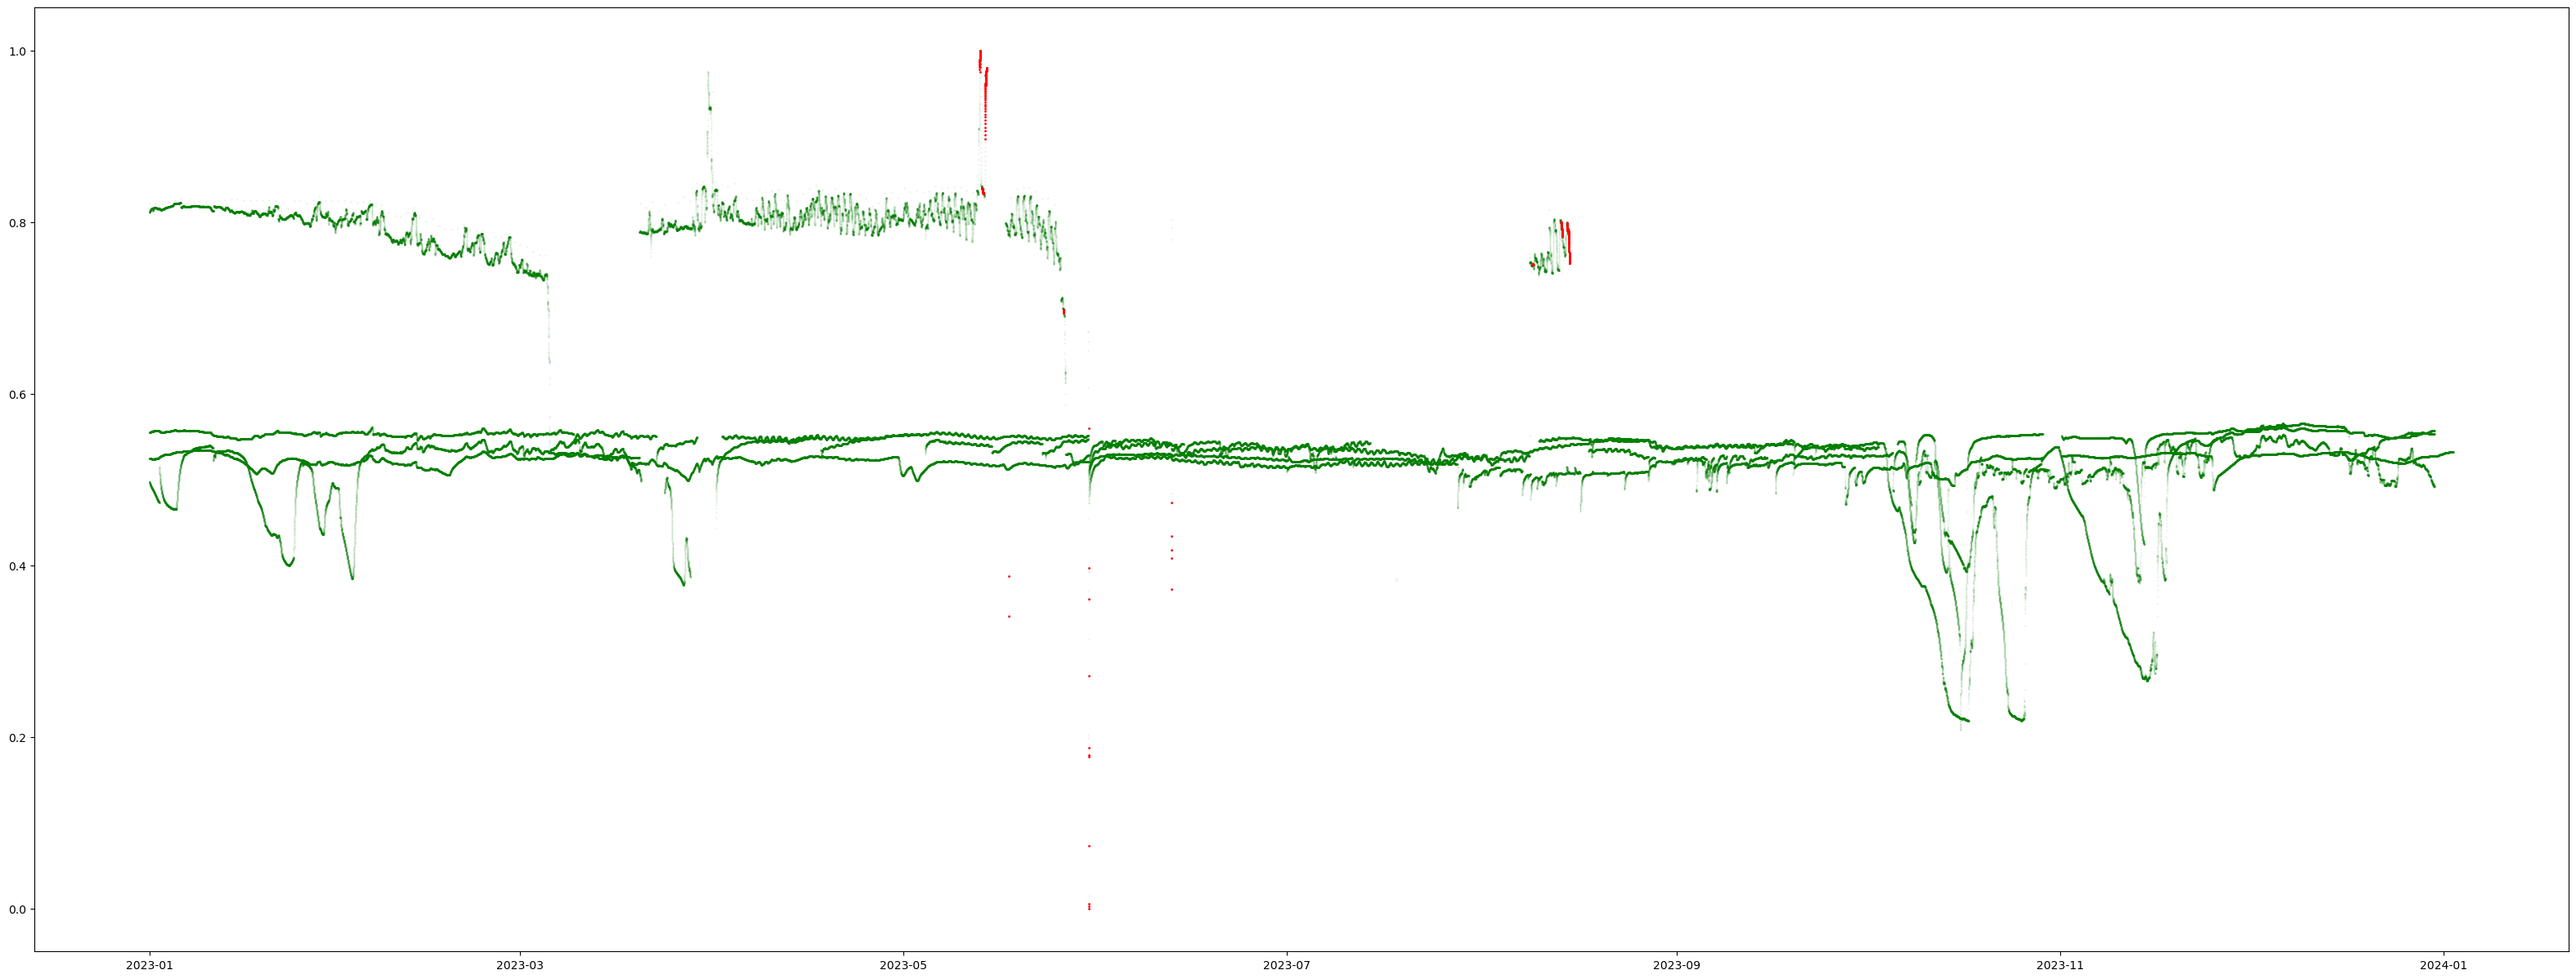

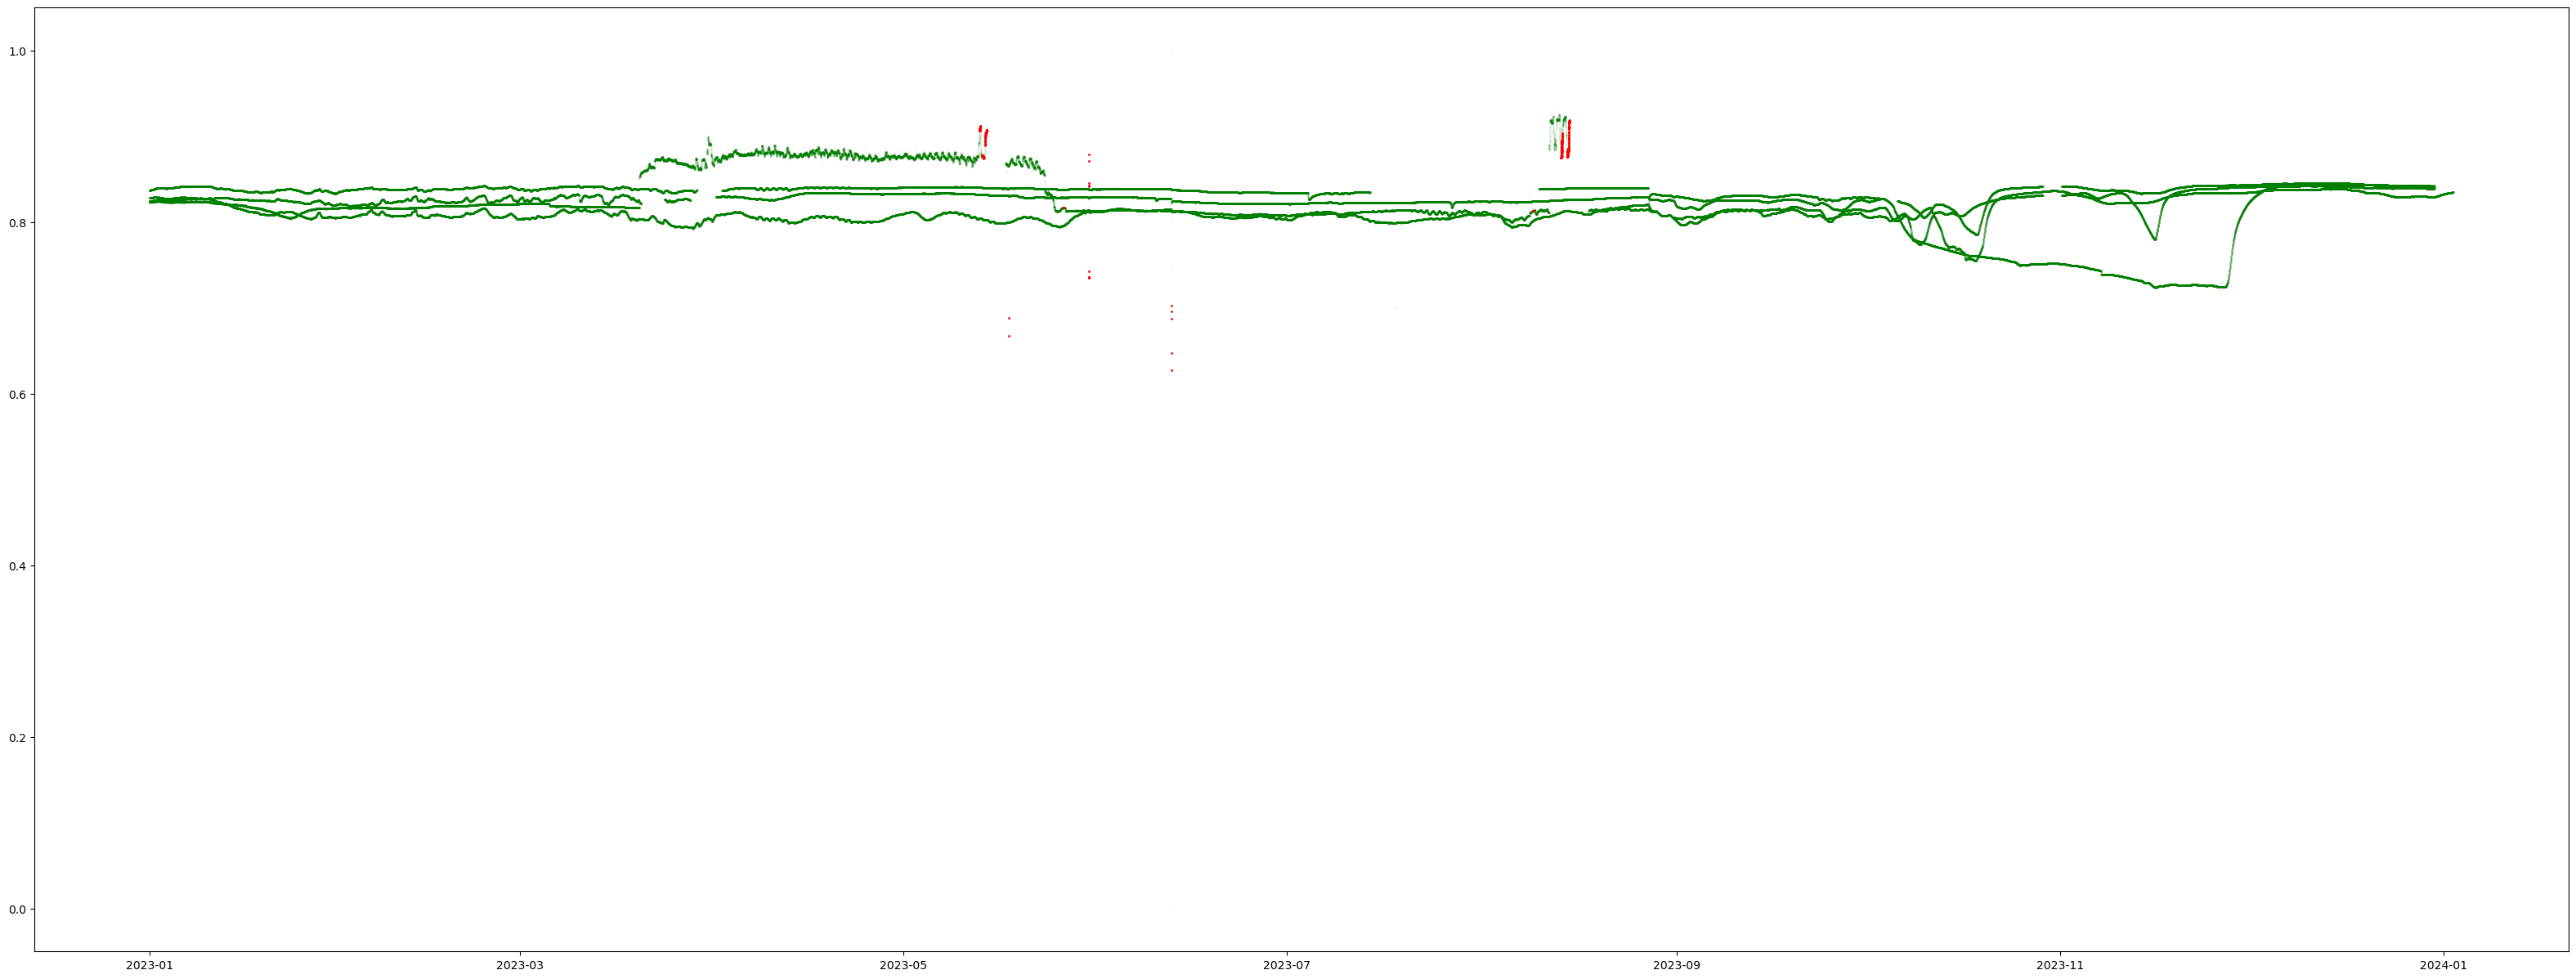

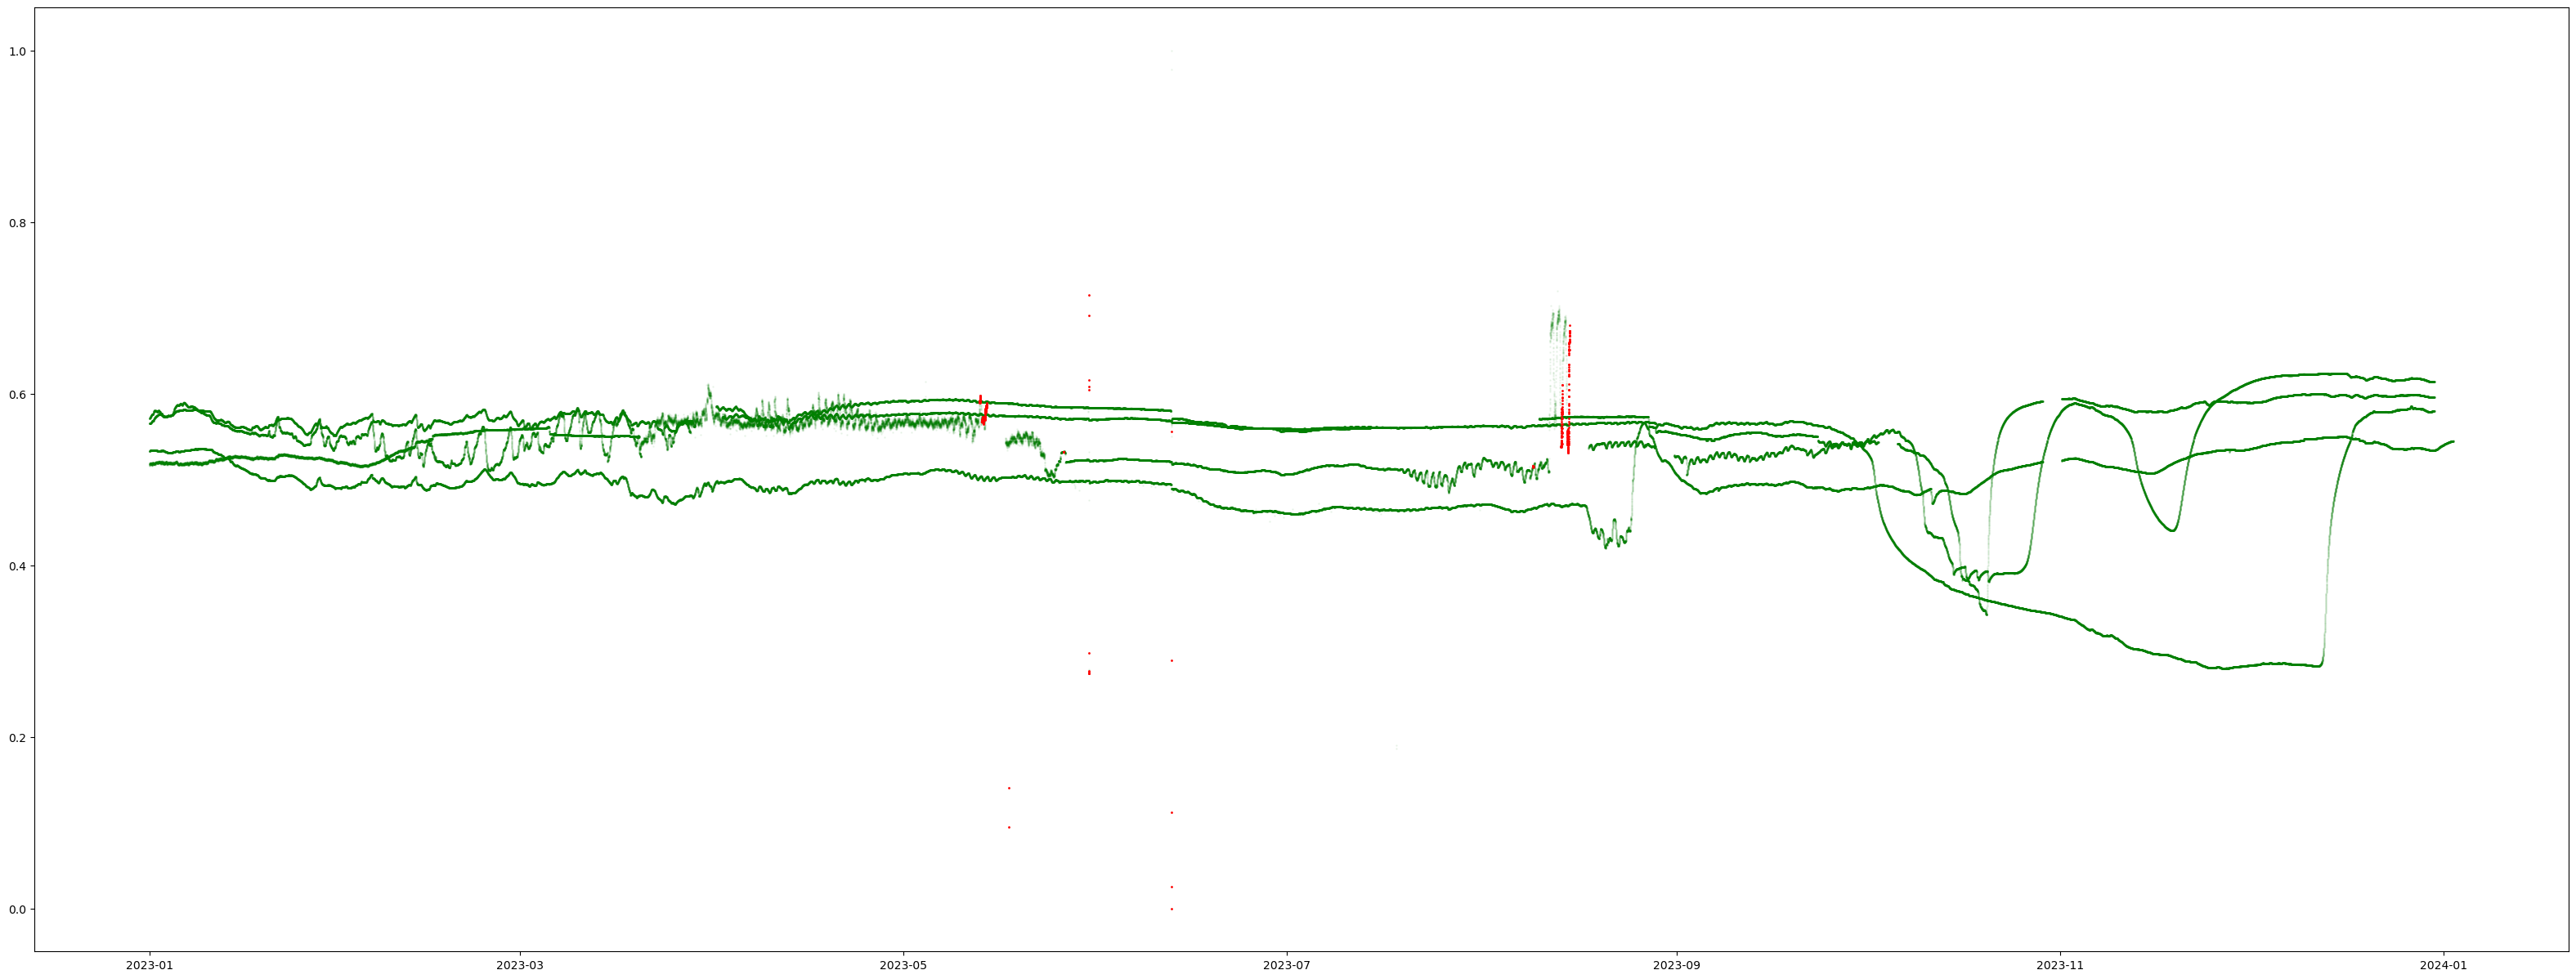

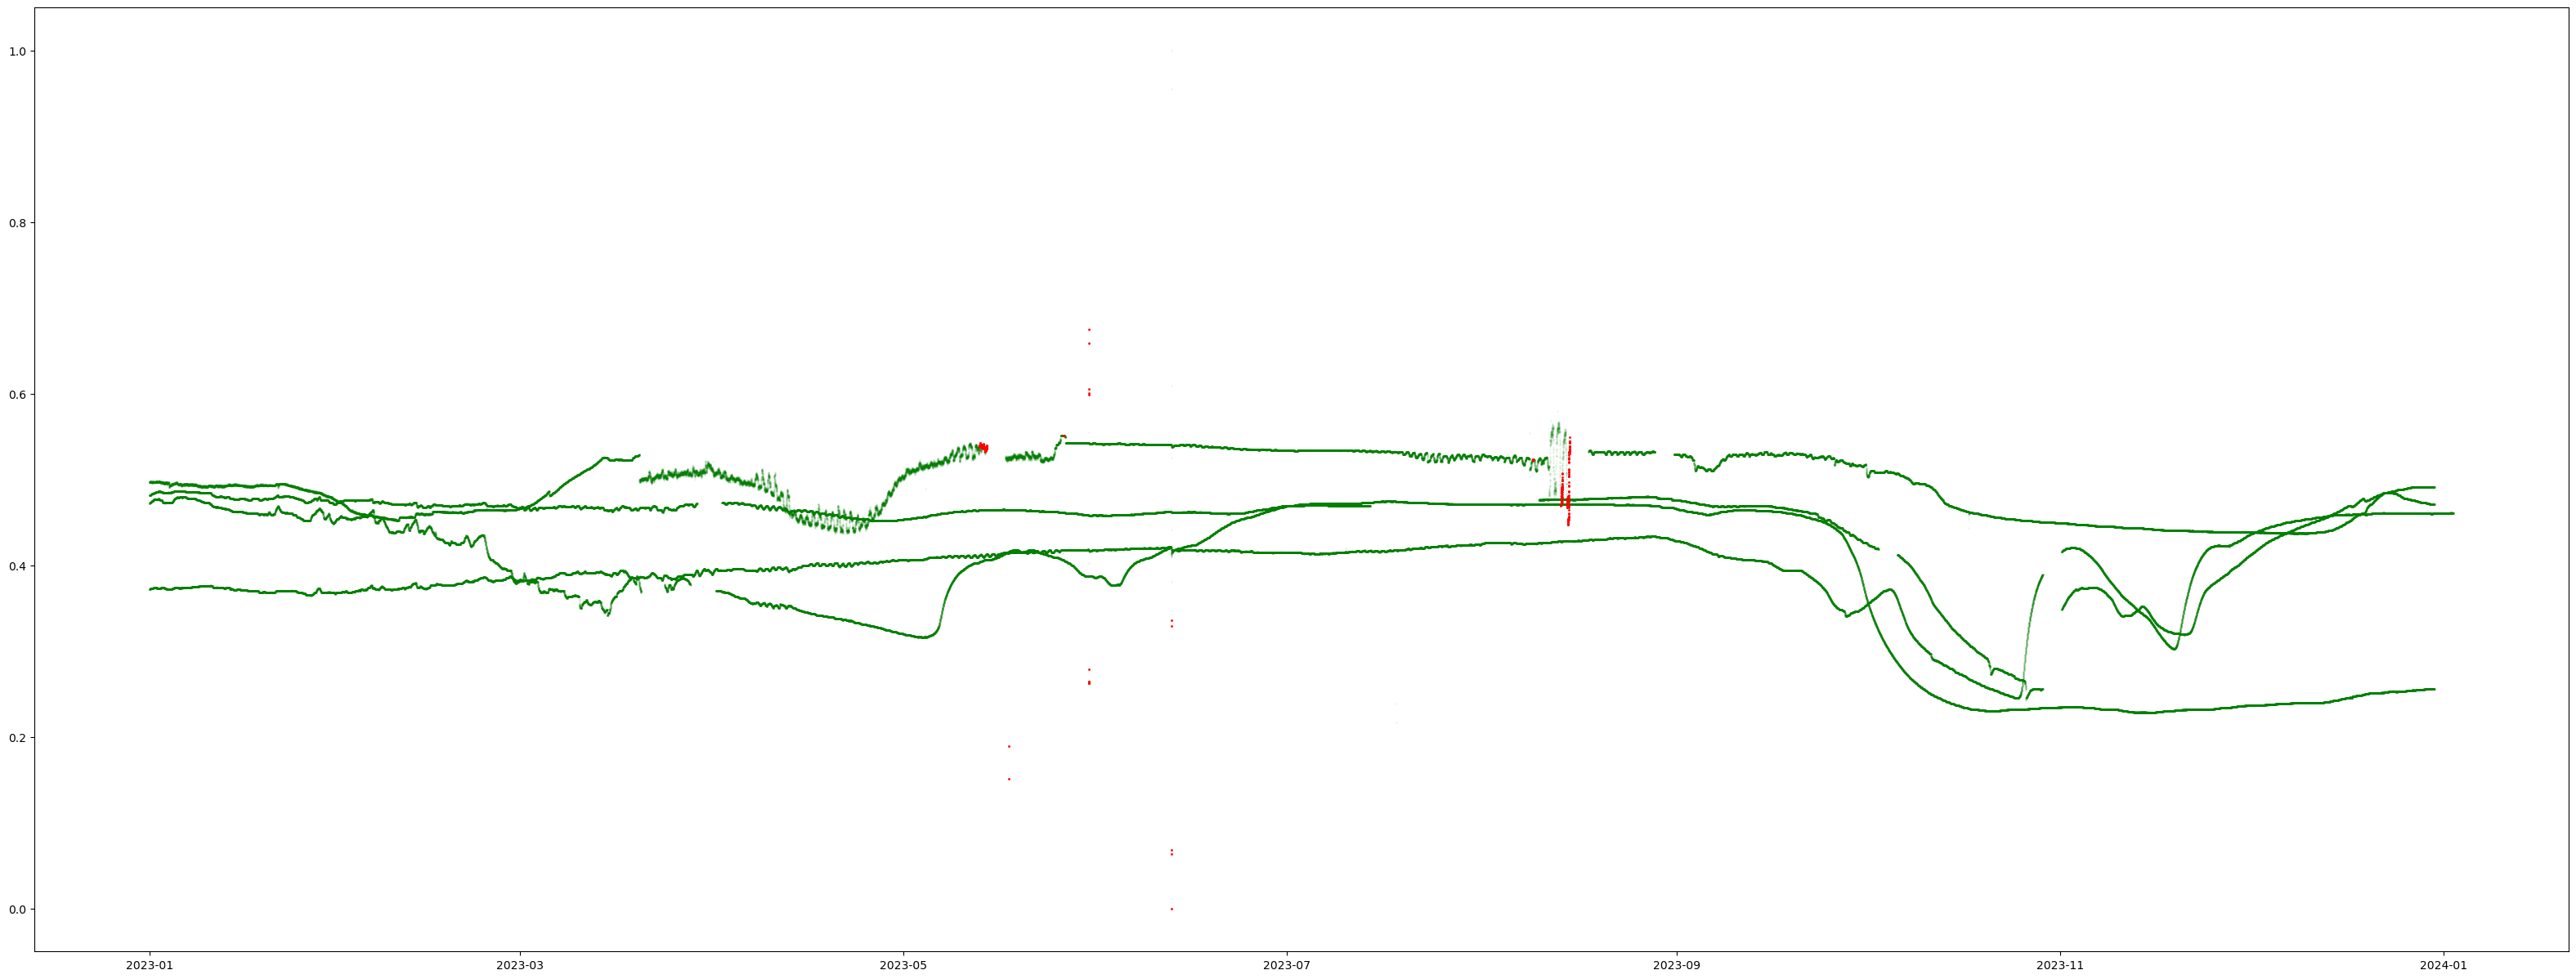

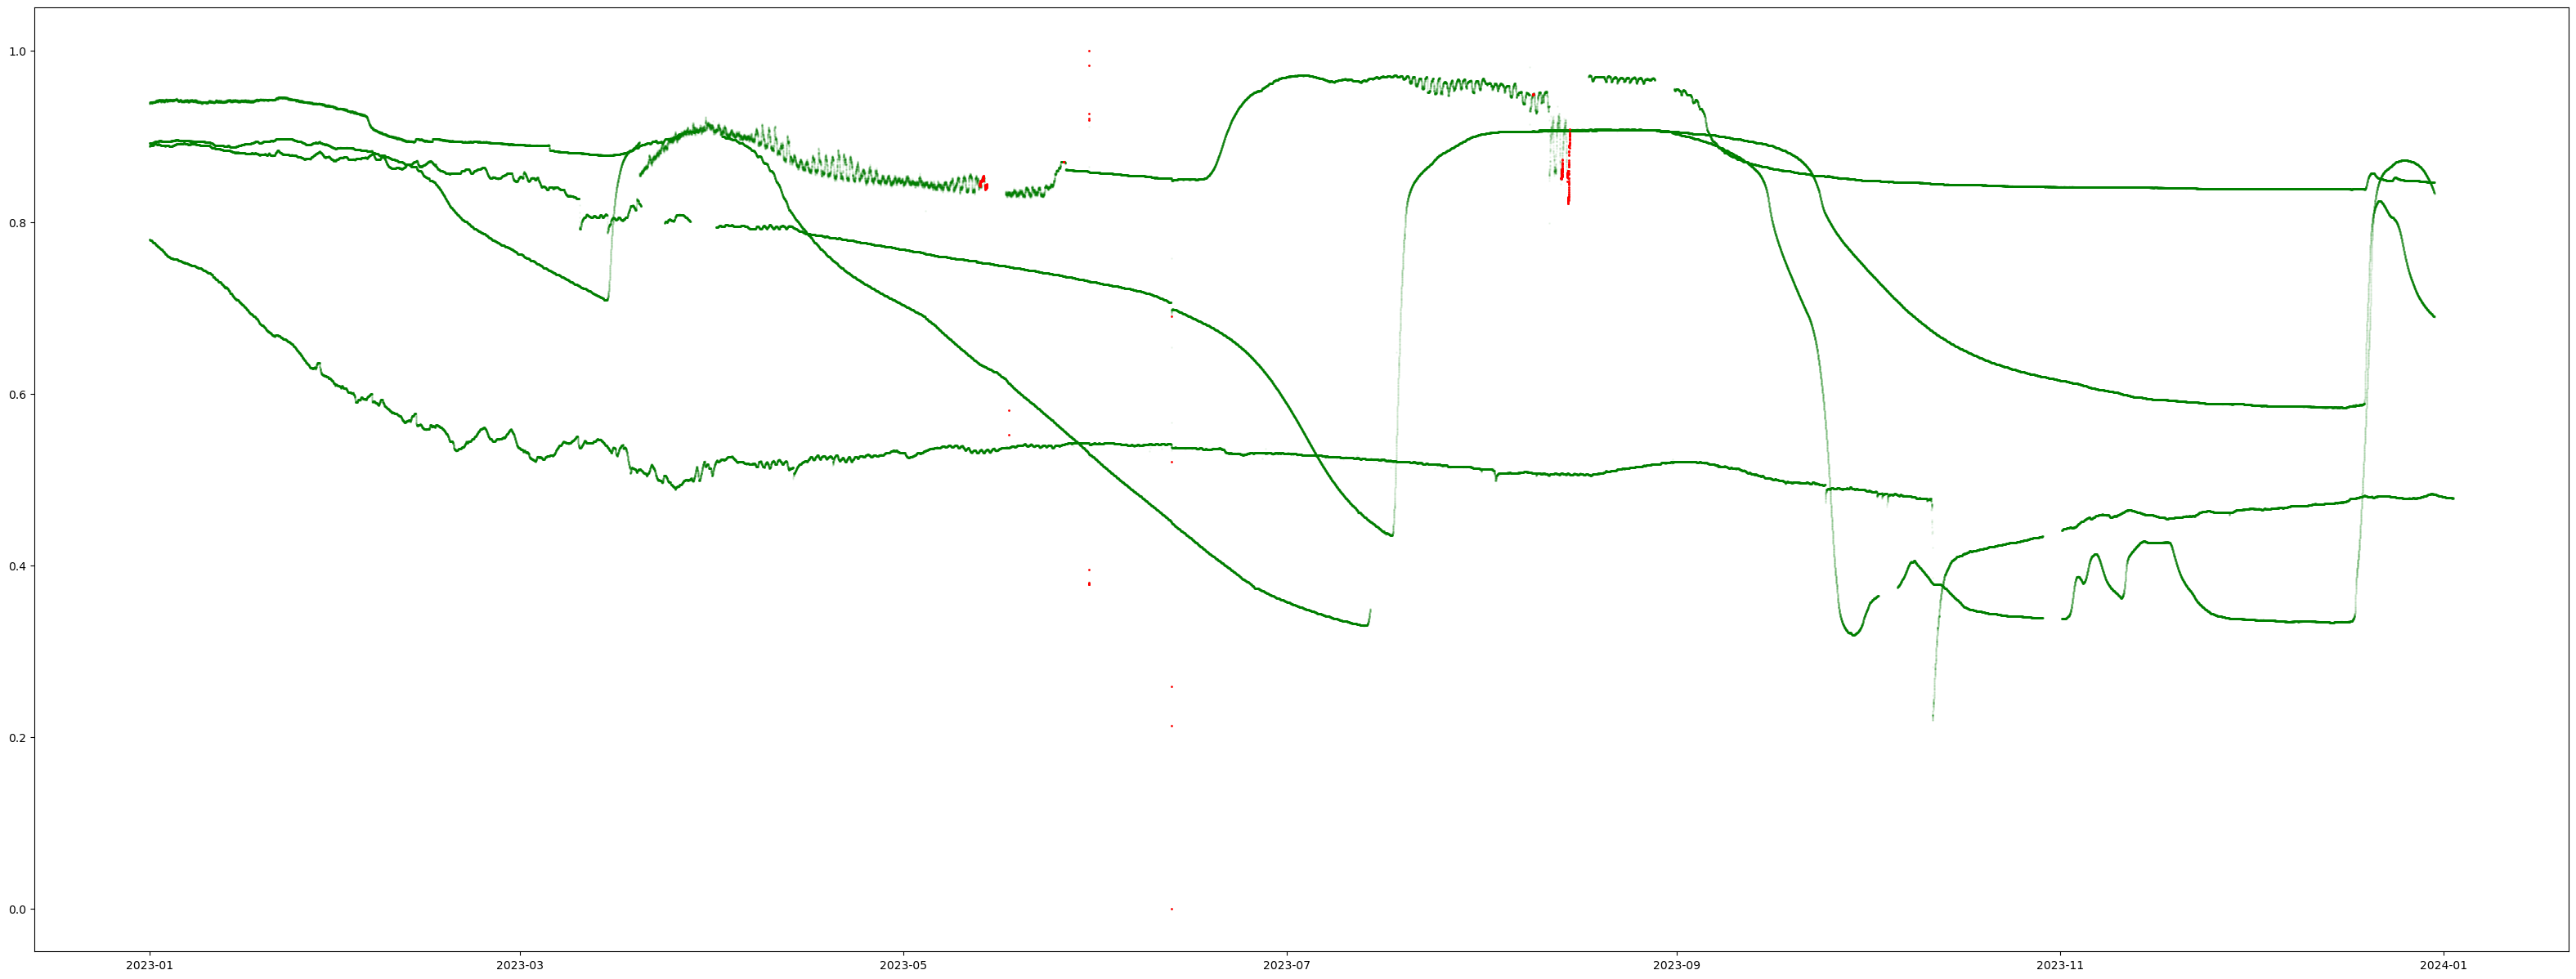

In [151]:
model_opt = models_all_sensors_dict[(Net5, 2.0, 4.0)][9]
predicted = model_opt.predictions
plot_predicted_2023(predicted, test_scaled_2023, sensor = None)

# 2022 sensor by sensor model training

In [53]:
def get_removable_sensor_columns(sensor):
    return [f'Redox_error_flag({sensor})', 'Redox_error_flag', 'pit_number', 'TIMESTAMP']

In [168]:
models_dict = dict()
train_test_results_final_table_df_dict = dict()

models for sensor 2
----------------------
calculating the sensor 2 model for the following parameters: architecture - <class 'Net3.Net3'>, weight = [2.0, 2.0]
----------------------


100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


Number of predicted anomalies for 2023 6530


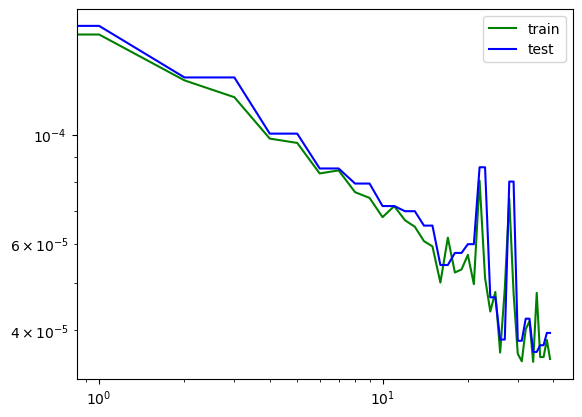

100%|██████████| 40/40 [02:16<00:00,  3.41s/it]


Number of predicted anomalies for 2023 5760


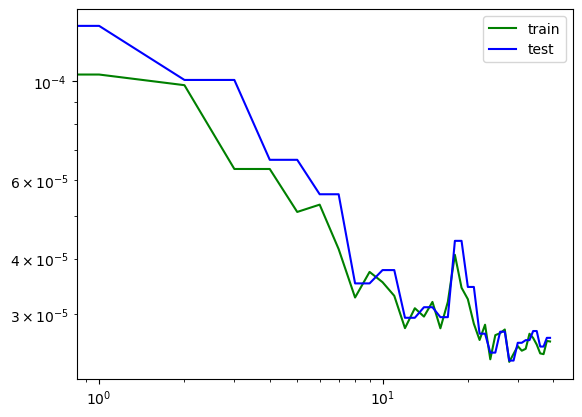

100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


Number of predicted anomalies for 2023 14040


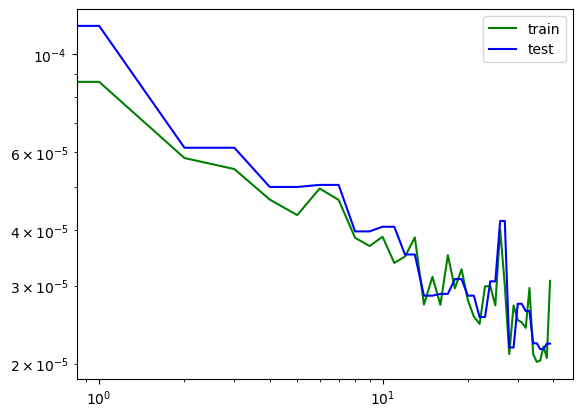

100%|██████████| 40/40 [02:24<00:00,  3.61s/it]


Number of predicted anomalies for 2023 3659


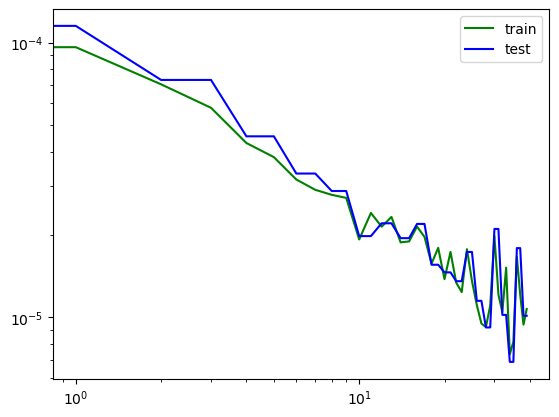

100%|██████████| 40/40 [02:13<00:00,  3.35s/it]


Number of predicted anomalies for 2023 6536


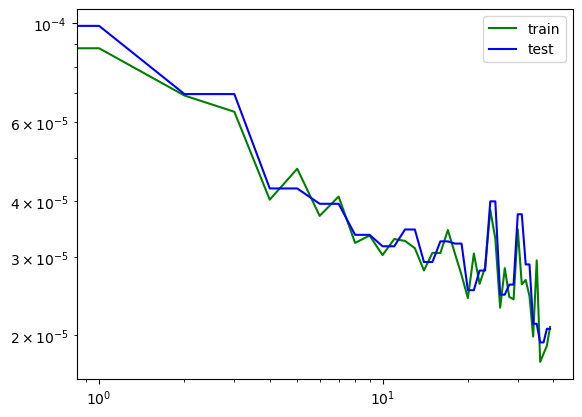

 75%|███████▌  | 30/40 [01:55<00:39,  3.99s/it]

In [170]:
Ms = [3, 5, 7, 9, 11, 13, 15]
learning_rate = 0.001

architecture_parameters = [Net3, Net5]
weight_parameters = [[2.0, 2.0], [2.0, 4.0]]

epochs = 40

for sensor in np.arange(2,6):

    print(f"models for sensor {sensor}")

    parameters_options = itertools.product(architecture_parameters, weight_parameters)

    removable_sensor_columns = get_removable_sensor_columns(sensor)

    sensor_specific_dict = sensor_data[f'sensor_{sensor}'] 
    train_X = sensor_specific_dict["X_train_scaled"]
    train_X = train_X.loc[:,~train_X.columns.isin(removable_sensor_columns)]
    train_X = torch.Tensor(train_X.to_numpy().astype("float32"))

    train_y = sensor_specific_dict["y_train"]
    train_y = torch.Tensor(train_y.to_numpy().ravel())
    train_y = train_y.to(dtype=torch.int32)

    test_X = sensor_specific_dict["X_test_scaled"]
    test_X = test_X.loc[:,~test_X.columns.isin(removable_sensor_columns)]
    test_X = torch.Tensor(test_X.to_numpy().astype("float32"))

    test_y = sensor_specific_dict["y_test"]
    test_y = torch.Tensor(test_y.to_numpy().ravel())
    test_y = test_y.to(dtype=torch.int32)

    test_scaled_2023 = sensor_specific_dict["test_scaled_2023"]
    test_X_scaled_2023 = test_scaled_2023.loc[:,~test_scaled_2023.columns.isin(exclude_features)]
    test_X_scaled_2023 = torch.Tensor(test_X_scaled_2023.to_numpy().astype("float32")).to(device)

    train_loader, test_loader = train_test_loaders(train_X, train_y, test_X, test_y, batch_size_train = 1000)
    
    for i, parameters in enumerate(parameters_options):
        
        architecture = parameters[0]
        weight = parameters[1]

        print("----------------------")
        print(f"calculating the sensor {sensor} model for the following parameters: architecture - {architecture}, weight = {weight}")
        print("----------------------")

        models, train_test_errors_df = model_comparison(Ms = Ms, lr = learning_rate, plotting_graphs = True, train_loader = train_loader, test_loader = test_loader, optimizer_f = torch.optim.SGD, architecture = architecture, weight = weight, epochs = epochs)
        
        if i == 0:
            train_test_results_final_table_df = train_test_errors_df
        else:
            train_test_results_final_table_df = pd.concat([train_test_results_final_table_df, train_test_errors_df], axis = 0)

        df_storing(train_test_errors_df, sensor, optimizer = "SGD_on_unscaled", lr = learning_rate, architecture = architecture, weight = weight)

        models_dict[(sensor, architecture, weight[0], weight[1])] = models

        print(f"table of errors for sensor {sensor}")
        print(train_test_errors_df)

        comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_accuracy"], train_test_errors_df["test_accuracy"], "log_likelihood", "accuracy")
        comparison_plot(train_test_errors_df["number_of_units"], train_test_errors_df["train_log_likelihood"], train_test_errors_df["test_log_likelihood"], train_test_errors_df["train_recall"], train_test_errors_df["test_recall"], "log_likelihood", "recall")

        M_opt = train_test_errors_df.loc[np.argmax(train_test_errors_df["test_recall"]), "number_of_units"].squeeze() 
        model_opt = models[M_opt]
        predicted = model_opt.predictions
        
        print(f"optimal value of the number of units per layer for sensor {sensor} is {M_opt}")
        plot_predicted_2023(predicted, test_scaled_2023, sensor = sensor)
        
    train_test_results_final_table_df_dict[sensor] = train_test_results_final_table_df


In [127]:
models_dict

{(1,
  Net3.Net3,
  2.0,
  2.0): {3: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, out_features=3, bias=True)
      (5): ReLU()
      (6): Linear(in_features=3, out_features=3, bias=True)
      (7): ReLU()
      (8): Linear(in_features=3, out_features=2, bias=True)
      (9): LogSoftmax(dim=-1)
    )
  ), 5: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=5, bias=True)
      (5): ReLU()
      (6): Linear(in_features=5, out_features=5, bias=True)
      (7): ReLU()
      (8): Linear(in_features=5, out_features=2, bias=True)
      (9): LogSoftmax(dim=-1)
    )
  ), 7: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_feature

In [161]:
pickle.dump(models_all_sensors_dict, open(results_folder + "all_sensors_Adam_0.01_models_dict", 'wb'))

In [162]:
pickle.dump(all_sensor_train_test_results_final_table_df, open(results_folder + "all_sensors_Adam_0.01_results_df", 'wb'))

In [163]:
pickle.dump(models_dict, open(results_folder + sensor_specific_folder + "all_models_Adam_0.01", 'wb'))

In [164]:
pickle.dump(train_test_results_final_table_df_dict, open(results_folder + sensor_specific_folder + "_Adam_0.01_results_df_dict", 'wb'))

In [132]:
df = pickle.load(open(results_folder + sensor_specific_folder + "SGD_0.001_results_df_dict", 'rb'))


In [133]:
df

{1:    architecture  weight_normal  weight_anomaly  number_of_units  \
 0             3            2.0             2.0                3   
 1             3            2.0             2.0                5   
 2             3            2.0             2.0                7   
 3             3            2.0             2.0                9   
 4             3            2.0             2.0               11   
 5             3            2.0             2.0               13   
 6             3            2.0             2.0               15   
 0             3            2.0             4.0                3   
 1             3            2.0             4.0                5   
 2             3            2.0             4.0                7   
 3             3            2.0             4.0                9   
 4             3            2.0             4.0               11   
 5             3            2.0             4.0               13   
 6             3            2.0             4

In [22]:
models_dict

{(1,
  Net3.Net3,
  2.0,
  2.0): {3: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, out_features=3, bias=True)
      (5): ReLU()
      (6): Linear(in_features=3, out_features=3, bias=True)
      (7): ReLU()
      (8): Linear(in_features=3, out_features=2, bias=True)
      (9): LogSoftmax(dim=-1)
    )
  ), 4: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=4, bias=True)
      (3): ReLU()
      (4): Linear(in_features=4, out_features=4, bias=True)
      (5): ReLU()
      (6): Linear(in_features=4, out_features=4, bias=True)
      (7): ReLU()
      (8): Linear(in_features=4, out_features=2, bias=True)
      (9): LogSoftmax(dim=-1)
    )
  ), 5: Net3(
    (fc): Sequential(
      (0): Linear(in_features=21, out_feature

In [23]:
#filename = "models"
# pickle.dump(models_dict, open(results_folder + sensor_specific_folder + filename, 'wb'))

In [24]:
filename = "models"

models_dict_loaded = pickle.load(open(results_folder + sensor_specific_folder + filename, 'rb'))

In [25]:
model_l = models_dict_loaded[1, Net3, 2.0, 2.0][3]

In [26]:
model_l.trajectory_train_loss

[0.0003502533270940148,
 0.00011820120963106899,
 0.00011813542661437495,
 0.0001182336870337551,
 0.0001182784804188755,
 0.00011824974612073064,
 0.00011829138887585088,
 0.00011826185361613696,
 0.00011827996745524443,
 0.00011827015444940696,
 0.00011831110275099451,
 0.00011827931866957991,
 0.00011831442571114848,
 0.00011835114848944178,
 0.00011830240426759296,
 0.00011823276695830835,
 0.00011824059427994677,
 0.00011830198985999572,
 0.00011831889217962494,
 0.00011821427675557979,
 0.00011832352380726766,
 0.00011832189871051706,
 0.00011824155896648458,
 0.00011825283341958797,
 0.0001182588950931195]

In [27]:
model_l.trajectory_test_loss

[2.7820058729086223e-06,
 2.781667026224411e-06,
 2.781529446729575e-06,
 2.7820141417529413e-06,
 2.781882895840988e-06,
 2.7815178351609574e-06,
 2.782445353187522e-06,
 2.782046161533069e-06,
 2.7822442619310037e-06,
 2.781516955496668e-06,
 2.784801446019797e-06,
 2.781672656075862e-06,
 2.783091378641533e-06,
 2.781571142816885e-06,
 2.781612311105621e-06,
 2.781655238722935e-06,
 2.781582402519787e-06,
 2.781565161099718e-06,
 2.7821888430807825e-06,
 2.7821344798277077e-06,
 2.781548799343938e-06,
 2.7816244504728122e-06,
 2.781838208895095e-06,
 2.7815692075554486e-06,
 2.7847810378082864e-06]

In [68]:
model = models[3]
predicted = model.predictions
    
print(f"optimal value of the number of units per layer for sensor {sensor} is {3}")
# plot_predicted_2023(predicted, test_scaled_2023, sensor = sensor)

optimal value of the number of units per layer for sensor 1 is 3


In [75]:
df = pickle.load(open(results_folder + sensor_specific_folder + filename, 'rb'))
df

number_of_units  train_log_likelihood  train_accuracy  train_recall  \
0                3          1.055555e-07        0.998460      0.990778   
1                4          2.903296e-06        0.974733      0.000000   
2                5          1.177063e-06        0.921878      0.999198   
3                6          1.603411e-07        0.995937      0.993585   
4                7          2.097675e-07        0.994630      0.998396   
5                8          4.973699e-07        0.990902      0.708099   

   test_log_likelihood  test_accuracy  test_recall  
0             0.000003       0.989280     0.613658  
1             0.000007       0.974757     0.000000  
2             0.000003       0.925264     0.683817  
3             0.000002       0.989421     0.624883  
4             0.000002       0.986446     0.662301  
5             0.000001       0.989350     0.659495

In [ ]:

            
            if (epoch > 0) & (epoch % 5 == 0) & (plotting_graphs == True):
                fig = plt.figure()
                ax1 = plt.gca()
                ax1.set_ylabel("error")
                ax1.plot(trajectory_train_loss, c = "blue", label = "train_loss")
                ax1.plot(trajectory_test_loss, c = "red", label = "test_loss")
                ax1.legend(loc = 0)
                
                ax2 = ax1.twinx() 
                ax2.set_ylabel("accuracy")
                ax2.plot(trajectory_train_acc, c = "green", label = "train_acc")
                ax2.plot(trajectory_test_acc, c = "cyan", label = "test_acc")
                ax2.legend(loc = 1)
                
                fig.tight_layout()
                plt.legend()
                plt.show(block = False)